In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from tqdm import tqdm
import os
import gc
from timm.scheduler.cosine_lr import CosineLRScheduler


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
! apt install tree -y ; tree "/kaggle/input/qwen-7b-fused-amlc-2025"; tree "/kaggle/input/train-test-text-embeddings-qwen0-6b"; tree "/kaggle/input/swin-embeddings-train-amlc-2025"




The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 132 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (429 kB/s)

78Selecting previously unselected package tree.
(Reading database ... 128639 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking tree (2.0.2-1) ...
7Progress: [ 40%] [#######################...................................] 8Setting up tree (2.0.2-1) ...
7Progress: [ 60%] [##################################........................] 87Progress: [ 80%] [##############################################............] 8Processing t

In [3]:
QWEN7B_TRAIN_DIR = '/kaggle/input/qwen-7b-fused-amlc-2025/train/'
embedding_file = os.path.join(QWEN7B_TRAIN_DIR, 'final_embeddings.npy')
embeddings = np.load(embedding_file)
print(f"Qwen-7B Embeddings Information:")
print(f"Full matrix shape: {embeddings.shape}")
print(f"Number of samples: {embeddings.shape[0]}")
print(f"Embedding dimension: {embeddings.shape[1]}")

QWEN4B_DIR = '/kaggle/input/qwen4b-embeddings/'
embedding_file = os.path.join(QWEN4B_DIR, 'qwen4b_train_embedding.npy')
embeddings = np.load(embedding_file)
    
print(f"Qwen-4B Embeddings Information:")
print(f"Full matrix shape: {embeddings.shape}")
print(f"Number of samples: {embeddings.shape[0]}")
print(f"Embedding dimension: {embeddings.shape[1]}")

DINO_DIR = '/kaggle/input/dino-vith16-amlc-2025/train/'
embedding_file = os.path.join(DINO_DIR, 'final_image_embeddings.npy')

embeddings = np.load(embedding_file)

print(f"DINOv3 Embeddings Information:")
print(f"Full matrix shape: {embeddings.shape}")
print(f"Number of samples: {embeddings.shape[0]}")
print(f"Embedding dimension: {embeddings.shape[1]}")

SIGLIP2_DIR = '/kaggle/input/siglip2-giant-amlc-2025/train'
embedding_file = os.path.join(SIGLIP2_DIR, 'final_image_embeddings.npy')

embeddings = np.load(embedding_file)

print(f"SIGLIPv2 Embeddings Information:")
print(f"Full matrix shape: {embeddings.shape}")
print(f"Number of samples: {embeddings.shape[0]}")
print(f"Embedding dimension: {embeddings.shape[1]}")

Qwen-7B Embeddings Information:
Full matrix shape: (75000, 3584)
Number of samples: 75000
Embedding dimension: 3584
Qwen-4B Embeddings Information:
Full matrix shape: (75000, 2560)
Number of samples: 75000
Embedding dimension: 2560
DINOv3 Embeddings Information:
Full matrix shape: (75000, 1280)
Number of samples: 75000
Embedding dimension: 1280
SIGLIPv2 Embeddings Information:
Full matrix shape: (75000, 1536)
Number of samples: 75000
Embedding dimension: 1536


In [4]:
# %% [code]
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from tqdm import tqdm
import os
import gc

# --- 1. Configuration ---

# Main dataset path
DATA_DIR = '/kaggle/input/amlc2025/student_resource/dataset/'

# Paths to embedding files
QWEN4B_DIR = '/kaggle/input/qwen4b-embeddings/'
DINO_DIR = '/kaggle/input/dino-vith16-amlc-2025/train/'
SIGLIP2_DIR = '/kaggle/input/siglip2-giant-amlc-2025/train/'

# --- Architecture Hyperparameters ---
# Define the input dimension for each modality
QWEN4B_DIM = 2560
DINO_DIM = 1280
SIGLIP2_DIM = 1536

# Output dimension for each tower
TOWER_OUTPUT_DIM = 768
ADAPTER_INPUT_DIM = TOWER_OUTPUT_DIM * 4  # 4 towers (Qwen4B, DINO, SigLIP2 text, SigLIP2 image)

# Model and Training Hyperparameters
HIDDEN_DIM_1 = 2048
HIDDEN_DIM_2 = 1024
HIDDEN_DIM_3 = 512
DROPOUT_RATE = 0.1 
BATCH_SIZE = 128
EPOCHS = 300
WARM_UP_EPOCHS = 20
LEARNING_RATE = 3e-4
N_SPLITS = 5 # Number of folds for cross-validation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")
print(f"Tower output dim: {TOWER_OUTPUT_DIM}, Adapter input dim: {ADAPTER_INPUT_DIM}")

# --- 2. Data Loading and Alignment ---
def load_and_align_embeddings():
    """
    Loads embeddings and aligns them with training labels.
    Returns separate numpy arrays for each modality.
    """
    print("Loading and aligning embeddings...")
    df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

    # Qwen4B
    qwen4b_emb = np.load(os.path.join(QWEN4B_DIR, 'qwen4b_train_embedding.npy'))
    qwen4b_ids = np.load(os.path.join(QWEN4B_DIR, 'qwen4b_train_sample_id.npy'))
    df_qwen4b = pd.DataFrame({'sample_id': qwen4b_ids, 'qwen4b_emb': list(qwen4b_emb)})

    # DINO
    dino_emb = np.load(os.path.join(DINO_DIR, 'final_image_embeddings.npy'))
    dino_ids = np.load(os.path.join(DINO_DIR, 'final_sample_ids.npy'))
    df_dino = pd.DataFrame({'sample_id': dino_ids, 'dino_emb': list(dino_emb)})

    # SigLIP-2
    siglip2_emb_img = np.load(os.path.join(SIGLIP2_DIR, 'final_image_embeddings.npy'))
    siglip2_emb_txt = np.load(os.path.join(SIGLIP2_DIR, 'final_text_embeddings.npy'))
    siglip2_ids = np.load(os.path.join(SIGLIP2_DIR, 'final_sample_ids.npy'))
    df_siglip2 = pd.DataFrame({'sample_id': siglip2_ids, 'siglip2_emb_img': list(siglip2_emb_img), 'siglip2_emb_txt': list(siglip2_emb_txt)})

    # Merge all
    print("Merging dataframes...")
    df_train = df_train.merge(df_qwen4b, on='sample_id', how='left')
    df_train = df_train.merge(df_dino, on='sample_id', how='left')
    df_train = df_train.merge(df_siglip2, on='sample_id', how='left')
    print(len(df_train),df_train.isna().any())
    del df_qwen4b, df_dino, df_siglip2, qwen4b_emb, dino_emb, siglip2_emb_img, siglip2_emb_txt
    gc.collect()

    # Extract arrays
    print("Extracting embeddings into separate arrays...")
    X_qwen4b = np.array(df_train['qwen4b_emb'].tolist(), dtype=np.float32)
    X_dino = np.array(df_train['dino_emb'].tolist(), dtype=np.float32)
    X_siglip2_txt = np.array(df_train['siglip2_emb_txt'].tolist(), dtype=np.float32)
    X_siglip2_img = np.array(df_train['siglip2_emb_img'].tolist(), dtype=np.float32)
    
    # Handle missing values
    X_qwen4b = np.nan_to_num(X_qwen4b, nan=0.0)
    X_dino = np.nan_to_num(X_dino, nan=0.0)
    X_siglip2_txt = np.nan_to_num(X_siglip2_txt, nan=0.0)
    X_siglip2_img = np.nan_to_num(X_siglip2_img, nan=0.0)

    y = np.log1p(df_train['price'].values.astype(np.float32))  # Log transform

    print("Data alignment and transformation complete.")
    return X_qwen4b, X_dino, X_siglip2_txt, X_siglip2_img, y, df_train

# --- 3. PyTorch Dataset Class ---
class ProductDataset(Dataset):
    def __init__(self, features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img, labels):
        self.features_qwen4b = torch.from_numpy(features_qwen4b)
        self.features_dino = torch.from_numpy(features_dino)
        self.features_siglip2_txt = torch.from_numpy(features_siglip2_txt)
        self.features_siglip2_img = torch.from_numpy(features_siglip2_img)
        self.labels = torch.from_numpy(labels)

    @property
    def max_label(self):
        return self.labels.quantile(0.99)

    @property
    def min_label(self):
        return min(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = (
            self.features_qwen4b[idx],
            self.features_dino[idx],
            self.features_siglip2_txt[idx],
            self.features_siglip2_img[idx]            
        )
        label = self.labels[idx]
        return features, label


Using device: cuda
Tower output dim: 768, Adapter input dim: 3072


In [5]:
# --- 4. Modal Tower Adapter Model Definition (UPDATED) ---
class ModalTowerAdapter(nn.Module):
    def __init__(self, qwen4b_dim, dino_dim, siglip2_dim, tower_output_dim, adapter_input_dim, h1, h2, h3, dropout_rate):
        super(ModalTowerAdapter, self).__init__()

        # Qwen-4B Tower
        self.qwen4b_tower = nn.Sequential(
            nn.Linear(qwen4b_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(tower_output_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(tower_output_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate)
        )

        # DINO Tower
        self.dino_tower = nn.Sequential(
            nn.Linear(dino_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(tower_output_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate)
        )

        # SigLIP Text Tower
        self.siglip2_txt_tower = nn.Sequential(
            nn.Linear(siglip2_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(tower_output_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate)
        )

        # SigLIP Image Tower
        self.siglip2_img_tower = nn.Sequential(
            nn.Linear(siglip2_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(tower_output_dim, tower_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(tower_output_dim),
            nn.Dropout(dropout_rate)
        )

        # Adapter (Final Fusion MLP)
        self.adapter_net = nn.Sequential(
            nn.Linear(adapter_input_dim, h1), nn.ReLU(), nn.BatchNorm1d(h1), nn.Dropout(dropout_rate),
            nn.Linear(h1, h2), nn.ReLU(), nn.BatchNorm1d(h2), nn.Dropout(dropout_rate),
            nn.Linear(h2, h3), nn.ReLU(), nn.BatchNorm1d(h3), nn.Dropout(dropout_rate),
            nn.Linear(h3, 1)
        )

    def forward(self, x_qwen4b, x_dino, x_siglip2_txt, x_siglip2_img):
        # Pass through individual towers
        out_qwen4b = self.qwen4b_tower(x_qwen4b)
        out_dino = self.dino_tower(x_dino)
        out_siglip2_txt = self.siglip2_txt_tower(x_siglip2_txt)
        out_siglip2_img = self.siglip2_img_tower(x_siglip2_img)

        # Concatenate tower outputs
        combined = torch.cat([out_qwen4b, out_dino, out_siglip2_txt, out_siglip2_img], dim=1)

        # Pass through adapter network
        return self.adapter_net(combined).squeeze(1)


In [6]:
# --- 5. SMAPE Metric ---
def smape_loss(y_pred, y_true):
    numerator = torch.abs(y_pred - y_true)
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    loss = torch.mean(numerator / (denominator + 1e-8)) * 100
    return loss
    
import torch.nn.functional as F
import torch
import torch.nn as nn

# --- 6. Training and Evaluation Loop (UPDATED) ---
def train_and_evaluate(train_loader, val_loader, fold, min_label, max_label):
    # Instantiate the new model (UPDATED PARAMS)
    model = ModalTowerAdapter(
        QWEN4B_DIM, DINO_DIM, SIGLIP2_DIM, TOWER_OUTPUT_DIM,
        ADAPTER_INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, HIDDEN_DIM_3, DROPOUT_RATE
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=WARM_UP_EPOCHS * len(train_loader))
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(EPOCHS - WARM_UP_EPOCHS), eta_min=1e-6)

    scheduler = CosineLRScheduler(optimizer, t_initial=EPOCHS, lr_min=1e-8,
                  cycle_mul=1.0, cycle_decay=1.0, cycle_limit=1,
                  warmup_t=WARM_UP_EPOCHS, warmup_lr_init=1e-6, warmup_prefix=False, t_in_epochs=True,
                  noise_range_t=None, noise_pct=0.67, noise_std=1.0,
                  noise_seed=42, k_decay=1.0, initialize=True)

    best_val_smape = float('inf')
    print(f"\n--- Starting Fold {fold+1}/{N_SPLITS} ---")
    for epoch in range(EPOCHS):
        model.train()
        train_loss_mae = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)

        for (features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img), log_prices in progress_bar:
            features_qwen4b = features_qwen4b.to(DEVICE)
            features_dino = features_dino.to(DEVICE)
            features_siglip2_txt = features_siglip2_txt.to(DEVICE)
            features_siglip2_img = features_siglip2_img.to(DEVICE)
            log_prices = log_prices.to(DEVICE)

            optimizer.zero_grad()
            log_outputs = model(features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img)
            loss = criterion(log_outputs, log_prices)
            loss.backward()
            optimizer.step()
            train_loss_mae += loss.item()

        model.eval()
        val_smape = 0.0
        val_loss = 0.0
        with torch.no_grad():
            for (features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img), log_prices in val_loader:
                features_qwen4b = features_qwen4b.to(DEVICE)
                features_dino = features_dino.to(DEVICE)
                features_siglip2_txt = features_siglip2_txt.to(DEVICE)
                features_siglip2_img = features_siglip2_img.to(DEVICE)
                log_prices = log_prices.to(DEVICE)

                log_outputs = model(features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img)
                original_scale_preds = torch.expm1(log_outputs)
                original_scale_prices = torch.expm1(log_prices)
                val_loss += criterion(log_outputs, log_prices).item()
                val_smape += smape_loss(original_scale_preds, original_scale_prices).item()

        avg_train_mae = train_loss_mae / len(train_loader)
        avg_val_smape = val_smape / len(val_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(epoch)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train MAE (log): {avg_train_mae:.5f} | Val Loss: {avg_val_loss:.5f} | Val SMAPE: {avg_val_smape:.2f}% | LR: {optimizer.param_groups[0]['lr']:.1e}")

        if avg_val_smape < best_val_smape:
            best_val_smape = avg_val_smape
            torch.save(model.state_dict(), f"modal_tower_model_fold_{fold+1}.pth")
            print(f"  -> New best validation SMAPE: {best_val_smape:.2f}%. Model saved.")

    return best_val_smape


# --- 7. Main Execution (UPDATED) ---
if __name__ == '__main__':
    # Load aligned features (UPDATED)
    X_qwen4b, X_dino, X_siglip2_txt, X_siglip2_img, y, df_train = load_and_align_embeddings()

    # Updated dataset
    full_dataset = ProductDataset(X_qwen4b, X_dino, X_siglip2_txt, X_siglip2_img, y)

    df_train['price_bin'] = pd.cut(df_train['price'], bins=15, labels=False)
    skf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df_train)):
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        train_labels = full_dataset.labels[train_idx]
        val_labels = full_dataset.labels[val_idx]

        train_min = train_labels.min().item()
        train_max = train_labels.quantile(0.97).item()

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        best_score = train_and_evaluate(train_loader, val_loader, fold, min_label=train_min, max_label=train_max)
        fold_scores.append(best_score)

    print("\n--- Cross-Validation Summary ---")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1} Best SMAPE: {score:.2f}%")
    print(f"\nAverage SMAPE across all folds: {np.mean(fold_scores):.2f}%")
    print(f"Standard Deviation of SMAPE: {np.std(fold_scores):.2f}%")


Loading and aligning embeddings...
Merging dataframes...
75000 sample_id          False
catalog_content    False
image_link         False
price              False
qwen4b_emb         False
dino_emb           False
siglip2_emb_img    False
siglip2_emb_txt    False
dtype: bool
Extracting embeddings into separate arrays...
Data alignment and transformation complete.

--- Starting Fold 1/5 ---


Epoch 1/300 | Train MAE (log): 8.29937 | Val Loss: 8.39565 | Val SMAPE: 192.85% | LR: 1.0e-06
  -> New best validation SMAPE: 192.85%. Model saved.


Epoch 2/300 | Train MAE (log): 8.12210 | Val Loss: 8.14893 | Val SMAPE: 192.39% | LR: 1.6e-05
  -> New best validation SMAPE: 192.39%. Model saved.


Epoch 3/300 | Train MAE (log): 7.71660 | Val Loss: 7.34694 | Val SMAPE: 190.85% | LR: 3.1e-05
  -> New best validation SMAPE: 190.85%. Model saved.


Epoch 4/300 | Train MAE (log): 6.84049 | Val Loss: 6.15252 | Val SMAPE: 184.02% | LR: 4.6e-05
  -> New best validation SMAPE: 184.02%. Model saved.


Epoch 5/300 | Train MAE (log): 4.97219 | Val Loss: 3.64667 | Val SMAPE: 153.54% | LR: 6.1e-05
  -> New best validation SMAPE: 153.54%. Model saved.


Epoch 6/300 | Train MAE (log): 2.09738 | Val Loss: 1.11561 | Val SMAPE: 81.02% | LR: 7.6e-05
  -> New best validation SMAPE: 81.02%. Model saved.


Epoch 7/300 | Train MAE (log): 0.77442 | Val Loss: 0.60952 | Val SMAPE: 58.99% | LR: 9.1e-05
  -> New best validation SMAPE: 58.99%. Model saved.


Epoch 8/300 | Train MAE (log): 0.59416 | Val Loss: 0.49855 | Val SMAPE: 54.19% | LR: 1.1e-04
  -> New best validation SMAPE: 54.19%. Model saved.


Epoch 9/300 | Train MAE (log): 0.53257 | Val Loss: 0.49231 | Val SMAPE: 53.59% | LR: 1.2e-04
  -> New best validation SMAPE: 53.59%. Model saved.


Epoch 10/300 | Train MAE (log): 0.49117 | Val Loss: 0.47750 | Val SMAPE: 52.40% | LR: 1.4e-04
  -> New best validation SMAPE: 52.40%. Model saved.


Epoch 11/300 | Train MAE (log): 0.45372 | Val Loss: 0.47300 | Val SMAPE: 51.97% | LR: 1.5e-04
  -> New best validation SMAPE: 51.97%. Model saved.


Epoch 12/300 | Train MAE (log): 0.42461 | Val Loss: 0.48059 | Val SMAPE: 52.63% | LR: 1.7e-04


Epoch 13/300 | Train MAE (log): 0.39034 | Val Loss: 0.49156 | Val SMAPE: 52.81% | LR: 1.8e-04


Epoch 14/300 | Train MAE (log): 0.36282 | Val Loss: 0.46876 | Val SMAPE: 50.38% | LR: 2.0e-04
  -> New best validation SMAPE: 50.38%. Model saved.


Epoch 15/300 | Train MAE (log): 0.33528 | Val Loss: 0.47524 | Val SMAPE: 51.03% | LR: 2.1e-04


Epoch 16/300 | Train MAE (log): 0.31181 | Val Loss: 0.45720 | Val SMAPE: 49.84% | LR: 2.3e-04
  -> New best validation SMAPE: 49.84%. Model saved.


Epoch 17/300 | Train MAE (log): 0.28972 | Val Loss: 0.52229 | Val SMAPE: 53.30% | LR: 2.4e-04


Epoch 18/300 | Train MAE (log): 0.27297 | Val Loss: 0.48528 | Val SMAPE: 51.21% | LR: 2.6e-04


Epoch 19/300 | Train MAE (log): 0.26169 | Val Loss: 0.46488 | Val SMAPE: 49.99% | LR: 2.7e-04


Epoch 20/300 | Train MAE (log): 0.24078 | Val Loss: 0.48611 | Val SMAPE: 50.87% | LR: 2.9e-04


Epoch 21/300 | Train MAE (log): 0.23001 | Val Loss: 0.47133 | Val SMAPE: 49.41% | LR: 3.0e-04
  -> New best validation SMAPE: 49.41%. Model saved.


Epoch 22/300 | Train MAE (log): 0.21490 | Val Loss: 0.47599 | Val SMAPE: 50.84% | LR: 3.0e-04


Epoch 23/300 | Train MAE (log): 0.19863 | Val Loss: 0.46247 | Val SMAPE: 49.19% | LR: 3.0e-04
  -> New best validation SMAPE: 49.19%. Model saved.


Epoch 24/300 | Train MAE (log): 0.18706 | Val Loss: 0.45828 | Val SMAPE: 48.29% | LR: 3.0e-04
  -> New best validation SMAPE: 48.29%. Model saved.


Epoch 25/300 | Train MAE (log): 0.16508 | Val Loss: 0.45916 | Val SMAPE: 48.38% | LR: 3.0e-04


Epoch 26/300 | Train MAE (log): 0.15532 | Val Loss: 0.46161 | Val SMAPE: 49.29% | LR: 2.9e-04


Epoch 27/300 | Train MAE (log): 0.14733 | Val Loss: 0.44950 | Val SMAPE: 47.60% | LR: 2.9e-04
  -> New best validation SMAPE: 47.60%. Model saved.


Epoch 28/300 | Train MAE (log): 0.13752 | Val Loss: 0.46640 | Val SMAPE: 49.00% | LR: 2.9e-04


Epoch 29/300 | Train MAE (log): 0.13210 | Val Loss: 0.46046 | Val SMAPE: 49.20% | LR: 2.9e-04


Epoch 30/300 | Train MAE (log): 0.12426 | Val Loss: 0.45352 | Val SMAPE: 47.38% | LR: 2.9e-04
  -> New best validation SMAPE: 47.38%. Model saved.


Epoch 31/300 | Train MAE (log): 0.11666 | Val Loss: 0.45245 | Val SMAPE: 48.01% | LR: 2.9e-04


Epoch 32/300 | Train MAE (log): 0.10979 | Val Loss: 0.44427 | Val SMAPE: 47.29% | LR: 2.9e-04
  -> New best validation SMAPE: 47.29%. Model saved.


Epoch 33/300 | Train MAE (log): 0.10292 | Val Loss: 0.45475 | Val SMAPE: 47.39% | LR: 2.9e-04


Epoch 34/300 | Train MAE (log): 0.10024 | Val Loss: 0.43696 | Val SMAPE: 47.19% | LR: 2.9e-04
  -> New best validation SMAPE: 47.19%. Model saved.


Epoch 35/300 | Train MAE (log): 0.09268 | Val Loss: 0.43661 | Val SMAPE: 47.12% | LR: 2.9e-04
  -> New best validation SMAPE: 47.12%. Model saved.


Epoch 36/300 | Train MAE (log): 0.09009 | Val Loss: 0.45887 | Val SMAPE: 48.48% | LR: 2.9e-04


Epoch 37/300 | Train MAE (log): 0.08274 | Val Loss: 0.44078 | Val SMAPE: 46.55% | LR: 2.9e-04
  -> New best validation SMAPE: 46.55%. Model saved.


Epoch 38/300 | Train MAE (log): 0.08125 | Val Loss: 0.44067 | Val SMAPE: 46.89% | LR: 2.9e-04


Epoch 39/300 | Train MAE (log): 0.07875 | Val Loss: 0.44029 | Val SMAPE: 46.07% | LR: 2.9e-04
  -> New best validation SMAPE: 46.07%. Model saved.


Epoch 40/300 | Train MAE (log): 0.07567 | Val Loss: 0.42798 | Val SMAPE: 46.73% | LR: 2.9e-04


Epoch 41/300 | Train MAE (log): 0.07396 | Val Loss: 0.42929 | Val SMAPE: 45.73% | LR: 2.9e-04
  -> New best validation SMAPE: 45.73%. Model saved.


Epoch 42/300 | Train MAE (log): 0.07027 | Val Loss: 0.43838 | Val SMAPE: 46.01% | LR: 2.9e-04


Epoch 43/300 | Train MAE (log): 0.06732 | Val Loss: 0.43569 | Val SMAPE: 45.98% | LR: 2.9e-04


Epoch 44/300 | Train MAE (log): 0.06489 | Val Loss: 0.43502 | Val SMAPE: 45.80% | LR: 2.9e-04


Epoch 45/300 | Train MAE (log): 0.06631 | Val Loss: 0.44572 | Val SMAPE: 46.13% | LR: 2.8e-04


Epoch 46/300 | Train MAE (log): 0.06540 | Val Loss: 0.42583 | Val SMAPE: 45.85% | LR: 2.8e-04


Epoch 47/300 | Train MAE (log): 0.06244 | Val Loss: 0.42909 | Val SMAPE: 45.46% | LR: 2.8e-04
  -> New best validation SMAPE: 45.46%. Model saved.


Epoch 48/300 | Train MAE (log): 0.05741 | Val Loss: 0.43549 | Val SMAPE: 45.35% | LR: 2.8e-04
  -> New best validation SMAPE: 45.35%. Model saved.


Epoch 49/300 | Train MAE (log): 0.05574 | Val Loss: 0.43282 | Val SMAPE: 45.38% | LR: 2.8e-04


Epoch 50/300 | Train MAE (log): 0.05578 | Val Loss: 0.43009 | Val SMAPE: 45.29% | LR: 2.8e-04
  -> New best validation SMAPE: 45.29%. Model saved.


Epoch 51/300 | Train MAE (log): 0.05168 | Val Loss: 0.42786 | Val SMAPE: 45.11% | LR: 2.8e-04
  -> New best validation SMAPE: 45.11%. Model saved.


Epoch 52/300 | Train MAE (log): 0.05243 | Val Loss: 0.43221 | Val SMAPE: 44.81% | LR: 2.8e-04
  -> New best validation SMAPE: 44.81%. Model saved.


Epoch 53/300 | Train MAE (log): 0.05202 | Val Loss: 0.43533 | Val SMAPE: 45.12% | LR: 2.8e-04


Epoch 54/300 | Train MAE (log): 0.04901 | Val Loss: 0.43523 | Val SMAPE: 45.00% | LR: 2.8e-04


Epoch 55/300 | Train MAE (log): 0.05002 | Val Loss: 0.44203 | Val SMAPE: 45.45% | LR: 2.8e-04


Epoch 56/300 | Train MAE (log): 0.04908 | Val Loss: 0.43353 | Val SMAPE: 45.04% | LR: 2.8e-04


Epoch 57/300 | Train MAE (log): 0.04969 | Val Loss: 0.42786 | Val SMAPE: 44.78% | LR: 2.7e-04
  -> New best validation SMAPE: 44.78%. Model saved.


Epoch 58/300 | Train MAE (log): 0.04608 | Val Loss: 0.42653 | Val SMAPE: 44.91% | LR: 2.7e-04


Epoch 59/300 | Train MAE (log): 0.04387 | Val Loss: 0.42174 | Val SMAPE: 44.73% | LR: 2.7e-04
  -> New best validation SMAPE: 44.73%. Model saved.


Epoch 60/300 | Train MAE (log): 0.04309 | Val Loss: 0.42507 | Val SMAPE: 44.43% | LR: 2.7e-04
  -> New best validation SMAPE: 44.43%. Model saved.


Epoch 61/300 | Train MAE (log): 0.03959 | Val Loss: 0.41615 | Val SMAPE: 44.12% | LR: 2.7e-04
  -> New best validation SMAPE: 44.12%. Model saved.


Epoch 62/300 | Train MAE (log): 0.04194 | Val Loss: 0.43569 | Val SMAPE: 44.69% | LR: 2.7e-04


Epoch 63/300 | Train MAE (log): 0.04371 | Val Loss: 0.42024 | Val SMAPE: 44.30% | LR: 2.7e-04


Epoch 64/300 | Train MAE (log): 0.04296 | Val Loss: 0.43324 | Val SMAPE: 44.59% | LR: 2.7e-04


Epoch 65/300 | Train MAE (log): 0.04048 | Val Loss: 0.42079 | Val SMAPE: 44.14% | LR: 2.7e-04


Epoch 66/300 | Train MAE (log): 0.03812 | Val Loss: 0.42161 | Val SMAPE: 44.12% | LR: 2.7e-04


Epoch 67/300 | Train MAE (log): 0.03920 | Val Loss: 0.42614 | Val SMAPE: 44.76% | LR: 2.7e-04


Epoch 68/300 | Train MAE (log): 0.03891 | Val Loss: 0.42473 | Val SMAPE: 44.36% | LR: 2.6e-04


Epoch 69/300 | Train MAE (log): 0.03793 | Val Loss: 0.42527 | Val SMAPE: 44.42% | LR: 2.6e-04


Epoch 70/300 | Train MAE (log): 0.03756 | Val Loss: 0.42844 | Val SMAPE: 44.22% | LR: 2.6e-04


Epoch 71/300 | Train MAE (log): 0.03615 | Val Loss: 0.42380 | Val SMAPE: 44.36% | LR: 2.6e-04


Epoch 72/300 | Train MAE (log): 0.03432 | Val Loss: 0.42563 | Val SMAPE: 43.98% | LR: 2.6e-04
  -> New best validation SMAPE: 43.98%. Model saved.


Epoch 73/300 | Train MAE (log): 0.03368 | Val Loss: 0.41795 | Val SMAPE: 43.86% | LR: 2.6e-04
  -> New best validation SMAPE: 43.86%. Model saved.


Epoch 74/300 | Train MAE (log): 0.03555 | Val Loss: 0.42679 | Val SMAPE: 44.18% | LR: 2.6e-04


Epoch 75/300 | Train MAE (log): 0.03631 | Val Loss: 0.43787 | Val SMAPE: 44.27% | LR: 2.6e-04


Epoch 76/300 | Train MAE (log): 0.03517 | Val Loss: 0.42294 | Val SMAPE: 43.98% | LR: 2.6e-04


Epoch 77/300 | Train MAE (log): 0.03342 | Val Loss: 0.42292 | Val SMAPE: 43.83% | LR: 2.5e-04
  -> New best validation SMAPE: 43.83%. Model saved.


Epoch 78/300 | Train MAE (log): 0.03305 | Val Loss: 0.43082 | Val SMAPE: 44.07% | LR: 2.5e-04


Epoch 79/300 | Train MAE (log): 0.03250 | Val Loss: 0.41993 | Val SMAPE: 44.05% | LR: 2.5e-04


Epoch 80/300 | Train MAE (log): 0.03269 | Val Loss: 0.42322 | Val SMAPE: 44.43% | LR: 2.5e-04


Epoch 81/300 | Train MAE (log): 0.03194 | Val Loss: 0.43618 | Val SMAPE: 44.33% | LR: 2.5e-04


Epoch 82/300 | Train MAE (log): 0.03124 | Val Loss: 0.42211 | Val SMAPE: 43.88% | LR: 2.5e-04


Epoch 83/300 | Train MAE (log): 0.03009 | Val Loss: 0.42445 | Val SMAPE: 43.80% | LR: 2.5e-04
  -> New best validation SMAPE: 43.80%. Model saved.


Epoch 84/300 | Train MAE (log): 0.03119 | Val Loss: 0.42132 | Val SMAPE: 43.77% | LR: 2.5e-04
  -> New best validation SMAPE: 43.77%. Model saved.


Epoch 85/300 | Train MAE (log): 0.02974 | Val Loss: 0.42670 | Val SMAPE: 43.82% | LR: 2.5e-04


Epoch 86/300 | Train MAE (log): 0.02846 | Val Loss: 0.41571 | Val SMAPE: 43.65% | LR: 2.4e-04
  -> New best validation SMAPE: 43.65%. Model saved.


Epoch 87/300 | Train MAE (log): 0.02788 | Val Loss: 0.43298 | Val SMAPE: 44.15% | LR: 2.4e-04


Epoch 88/300 | Train MAE (log): 0.03013 | Val Loss: 0.42739 | Val SMAPE: 43.74% | LR: 2.4e-04


Epoch 89/300 | Train MAE (log): 0.02997 | Val Loss: 0.42066 | Val SMAPE: 43.83% | LR: 2.4e-04


Epoch 90/300 | Train MAE (log): 0.02721 | Val Loss: 0.42519 | Val SMAPE: 43.57% | LR: 2.4e-04
  -> New best validation SMAPE: 43.57%. Model saved.


Epoch 91/300 | Train MAE (log): 0.02774 | Val Loss: 0.42092 | Val SMAPE: 43.67% | LR: 2.4e-04


Epoch 92/300 | Train MAE (log): 0.02750 | Val Loss: 0.41822 | Val SMAPE: 43.57% | LR: 2.4e-04


Epoch 93/300 | Train MAE (log): 0.02596 | Val Loss: 0.43218 | Val SMAPE: 43.71% | LR: 2.4e-04


Epoch 94/300 | Train MAE (log): 0.02730 | Val Loss: 0.42383 | Val SMAPE: 43.55% | LR: 2.3e-04
  -> New best validation SMAPE: 43.55%. Model saved.


Epoch 95/300 | Train MAE (log): 0.02845 | Val Loss: 0.42369 | Val SMAPE: 43.45% | LR: 2.3e-04
  -> New best validation SMAPE: 43.45%. Model saved.


Epoch 96/300 | Train MAE (log): 0.02707 | Val Loss: 0.42625 | Val SMAPE: 43.41% | LR: 2.3e-04
  -> New best validation SMAPE: 43.41%. Model saved.


Epoch 97/300 | Train MAE (log): 0.02614 | Val Loss: 0.42553 | Val SMAPE: 43.59% | LR: 2.3e-04


Epoch 98/300 | Train MAE (log): 0.02560 | Val Loss: 0.42292 | Val SMAPE: 43.71% | LR: 2.3e-04


Epoch 99/300 | Train MAE (log): 0.02576 | Val Loss: 0.42872 | Val SMAPE: 43.83% | LR: 2.3e-04


Epoch 100/300 | Train MAE (log): 0.02559 | Val Loss: 0.41491 | Val SMAPE: 43.38% | LR: 2.3e-04
  -> New best validation SMAPE: 43.38%. Model saved.


Epoch 101/300 | Train MAE (log): 0.02486 | Val Loss: 0.42158 | Val SMAPE: 43.24% | LR: 2.3e-04
  -> New best validation SMAPE: 43.24%. Model saved.


Epoch 102/300 | Train MAE (log): 0.02529 | Val Loss: 0.43047 | Val SMAPE: 43.60% | LR: 2.2e-04


Epoch 103/300 | Train MAE (log): 0.02385 | Val Loss: 0.42533 | Val SMAPE: 43.39% | LR: 2.2e-04


Epoch 104/300 | Train MAE (log): 0.02269 | Val Loss: 0.41577 | Val SMAPE: 43.24% | LR: 2.2e-04
  -> New best validation SMAPE: 43.24%. Model saved.


Epoch 105/300 | Train MAE (log): 0.02422 | Val Loss: 0.42154 | Val SMAPE: 43.41% | LR: 2.2e-04


Epoch 106/300 | Train MAE (log): 0.02438 | Val Loss: 0.42727 | Val SMAPE: 43.55% | LR: 2.2e-04


Epoch 107/300 | Train MAE (log): 0.02617 | Val Loss: 0.42744 | Val SMAPE: 43.64% | LR: 2.2e-04


Epoch 108/300 | Train MAE (log): 0.02338 | Val Loss: 0.42665 | Val SMAPE: 43.38% | LR: 2.2e-04


Epoch 109/300 | Train MAE (log): 0.02309 | Val Loss: 0.42227 | Val SMAPE: 43.09% | LR: 2.1e-04
  -> New best validation SMAPE: 43.09%. Model saved.


Epoch 110/300 | Train MAE (log): 0.02222 | Val Loss: 0.41790 | Val SMAPE: 43.32% | LR: 2.1e-04


Epoch 111/300 | Train MAE (log): 0.02313 | Val Loss: 0.42742 | Val SMAPE: 43.35% | LR: 2.1e-04


Epoch 112/300 | Train MAE (log): 0.02348 | Val Loss: 0.43013 | Val SMAPE: 43.42% | LR: 2.1e-04


Epoch 113/300 | Train MAE (log): 0.02202 | Val Loss: 0.42352 | Val SMAPE: 43.34% | LR: 2.1e-04


Epoch 114/300 | Train MAE (log): 0.02298 | Val Loss: 0.43544 | Val SMAPE: 43.34% | LR: 2.1e-04


Epoch 115/300 | Train MAE (log): 0.02280 | Val Loss: 0.42388 | Val SMAPE: 43.32% | LR: 2.1e-04


Epoch 116/300 | Train MAE (log): 0.02047 | Val Loss: 0.42183 | Val SMAPE: 42.93% | LR: 2.0e-04
  -> New best validation SMAPE: 42.93%. Model saved.


Epoch 117/300 | Train MAE (log): 0.02176 | Val Loss: 0.41454 | Val SMAPE: 43.26% | LR: 2.0e-04


Epoch 118/300 | Train MAE (log): 0.02226 | Val Loss: 0.42308 | Val SMAPE: 43.36% | LR: 2.0e-04


Epoch 119/300 | Train MAE (log): 0.02116 | Val Loss: 0.41951 | Val SMAPE: 43.18% | LR: 2.0e-04


Epoch 120/300 | Train MAE (log): 0.02094 | Val Loss: 0.41920 | Val SMAPE: 43.30% | LR: 2.0e-04


Epoch 121/300 | Train MAE (log): 0.02169 | Val Loss: 0.42137 | Val SMAPE: 43.31% | LR: 2.0e-04


Epoch 122/300 | Train MAE (log): 0.02056 | Val Loss: 0.42567 | Val SMAPE: 43.45% | LR: 1.9e-04


Epoch 123/300 | Train MAE (log): 0.02010 | Val Loss: 0.42514 | Val SMAPE: 43.30% | LR: 1.9e-04


Epoch 124/300 | Train MAE (log): 0.02070 | Val Loss: 0.42416 | Val SMAPE: 43.53% | LR: 1.9e-04


Epoch 125/300 | Train MAE (log): 0.02079 | Val Loss: 0.42512 | Val SMAPE: 43.04% | LR: 1.9e-04


Epoch 126/300 | Train MAE (log): 0.01966 | Val Loss: 0.41587 | Val SMAPE: 42.79% | LR: 1.9e-04
  -> New best validation SMAPE: 42.79%. Model saved.


Epoch 127/300 | Train MAE (log): 0.01911 | Val Loss: 0.41888 | Val SMAPE: 42.91% | LR: 1.9e-04


Epoch 128/300 | Train MAE (log): 0.01953 | Val Loss: 0.42296 | Val SMAPE: 43.04% | LR: 1.9e-04


Epoch 129/300 | Train MAE (log): 0.01938 | Val Loss: 0.41924 | Val SMAPE: 42.96% | LR: 1.8e-04


Epoch 130/300 | Train MAE (log): 0.02022 | Val Loss: 0.41820 | Val SMAPE: 43.24% | LR: 1.8e-04


Epoch 131/300 | Train MAE (log): 0.01856 | Val Loss: 0.42405 | Val SMAPE: 42.94% | LR: 1.8e-04


Epoch 132/300 | Train MAE (log): 0.01845 | Val Loss: 0.41974 | Val SMAPE: 42.85% | LR: 1.8e-04


Epoch 133/300 | Train MAE (log): 0.01895 | Val Loss: 0.42179 | Val SMAPE: 42.83% | LR: 1.8e-04


Epoch 134/300 | Train MAE (log): 0.01912 | Val Loss: 0.41660 | Val SMAPE: 42.75% | LR: 1.8e-04
  -> New best validation SMAPE: 42.75%. Model saved.


Epoch 135/300 | Train MAE (log): 0.01837 | Val Loss: 0.42040 | Val SMAPE: 42.62% | LR: 1.8e-04
  -> New best validation SMAPE: 42.62%. Model saved.


Epoch 136/300 | Train MAE (log): 0.01748 | Val Loss: 0.41405 | Val SMAPE: 42.69% | LR: 1.7e-04


Epoch 137/300 | Train MAE (log): 0.01931 | Val Loss: 0.41944 | Val SMAPE: 42.69% | LR: 1.7e-04


Epoch 138/300 | Train MAE (log): 0.01937 | Val Loss: 0.41446 | Val SMAPE: 42.94% | LR: 1.7e-04


Epoch 139/300 | Train MAE (log): 0.01796 | Val Loss: 0.41840 | Val SMAPE: 42.75% | LR: 1.7e-04


Epoch 140/300 | Train MAE (log): 0.01797 | Val Loss: 0.42119 | Val SMAPE: 42.82% | LR: 1.7e-04


Epoch 141/300 | Train MAE (log): 0.02071 | Val Loss: 0.42042 | Val SMAPE: 42.72% | LR: 1.7e-04


Epoch 142/300 | Train MAE (log): 0.01718 | Val Loss: 0.41667 | Val SMAPE: 42.62% | LR: 1.6e-04


Epoch 143/300 | Train MAE (log): 0.01895 | Val Loss: 0.42610 | Val SMAPE: 42.74% | LR: 1.6e-04


Epoch 144/300 | Train MAE (log): 0.01801 | Val Loss: 0.42291 | Val SMAPE: 42.59% | LR: 1.6e-04
  -> New best validation SMAPE: 42.59%. Model saved.


Epoch 145/300 | Train MAE (log): 0.01761 | Val Loss: 0.42204 | Val SMAPE: 42.53% | LR: 1.6e-04
  -> New best validation SMAPE: 42.53%. Model saved.


Epoch 146/300 | Train MAE (log): 0.01752 | Val Loss: 0.42468 | Val SMAPE: 42.53% | LR: 1.6e-04
  -> New best validation SMAPE: 42.53%. Model saved.


Epoch 147/300 | Train MAE (log): 0.01738 | Val Loss: 0.42354 | Val SMAPE: 42.58% | LR: 1.6e-04


Epoch 148/300 | Train MAE (log): 0.01654 | Val Loss: 0.42187 | Val SMAPE: 42.77% | LR: 1.5e-04


Epoch 149/300 | Train MAE (log): 0.01778 | Val Loss: 0.41904 | Val SMAPE: 43.14% | LR: 1.5e-04


Epoch 150/300 | Train MAE (log): 0.01737 | Val Loss: 0.42252 | Val SMAPE: 42.61% | LR: 1.5e-04


Epoch 151/300 | Train MAE (log): 0.01677 | Val Loss: 0.41911 | Val SMAPE: 42.63% | LR: 1.5e-04


Epoch 152/300 | Train MAE (log): 0.01704 | Val Loss: 0.42152 | Val SMAPE: 42.42% | LR: 1.5e-04
  -> New best validation SMAPE: 42.42%. Model saved.


Epoch 153/300 | Train MAE (log): 0.01713 | Val Loss: 0.41742 | Val SMAPE: 42.69% | LR: 1.5e-04


Epoch 154/300 | Train MAE (log): 0.01792 | Val Loss: 0.41929 | Val SMAPE: 42.52% | LR: 1.5e-04


Epoch 155/300 | Train MAE (log): 0.01565 | Val Loss: 0.42206 | Val SMAPE: 42.69% | LR: 1.4e-04


Epoch 156/300 | Train MAE (log): 0.01659 | Val Loss: 0.41927 | Val SMAPE: 42.66% | LR: 1.4e-04


Epoch 157/300 | Train MAE (log): 0.01577 | Val Loss: 0.41469 | Val SMAPE: 42.51% | LR: 1.4e-04


Epoch 158/300 | Train MAE (log): 0.01584 | Val Loss: 0.42019 | Val SMAPE: 42.45% | LR: 1.4e-04


Epoch 159/300 | Train MAE (log): 0.01599 | Val Loss: 0.42025 | Val SMAPE: 42.58% | LR: 1.4e-04


Epoch 160/300 | Train MAE (log): 0.01623 | Val Loss: 0.41831 | Val SMAPE: 42.64% | LR: 1.4e-04


Epoch 161/300 | Train MAE (log): 0.01744 | Val Loss: 0.42275 | Val SMAPE: 42.56% | LR: 1.3e-04


Epoch 162/300 | Train MAE (log): 0.01707 | Val Loss: 0.41627 | Val SMAPE: 42.58% | LR: 1.3e-04


Epoch 163/300 | Train MAE (log): 0.01559 | Val Loss: 0.42370 | Val SMAPE: 42.57% | LR: 1.3e-04


Epoch 164/300 | Train MAE (log): 0.01544 | Val Loss: 0.41535 | Val SMAPE: 42.51% | LR: 1.3e-04


Epoch 165/300 | Train MAE (log): 0.01518 | Val Loss: 0.41803 | Val SMAPE: 42.41% | LR: 1.3e-04
  -> New best validation SMAPE: 42.41%. Model saved.


Epoch 166/300 | Train MAE (log): 0.01502 | Val Loss: 0.41831 | Val SMAPE: 42.47% | LR: 1.3e-04


Epoch 167/300 | Train MAE (log): 0.01576 | Val Loss: 0.42185 | Val SMAPE: 42.53% | LR: 1.2e-04


Epoch 168/300 | Train MAE (log): 0.01575 | Val Loss: 0.41717 | Val SMAPE: 42.33% | LR: 1.2e-04
  -> New best validation SMAPE: 42.33%. Model saved.


Epoch 169/300 | Train MAE (log): 0.01525 | Val Loss: 0.41990 | Val SMAPE: 42.35% | LR: 1.2e-04


Epoch 170/300 | Train MAE (log): 0.01456 | Val Loss: 0.41628 | Val SMAPE: 42.60% | LR: 1.2e-04


Epoch 171/300 | Train MAE (log): 0.01476 | Val Loss: 0.41733 | Val SMAPE: 42.54% | LR: 1.2e-04


Epoch 172/300 | Train MAE (log): 0.01463 | Val Loss: 0.41893 | Val SMAPE: 42.52% | LR: 1.2e-04


Epoch 173/300 | Train MAE (log): 0.01480 | Val Loss: 0.42255 | Val SMAPE: 42.38% | LR: 1.2e-04


Epoch 174/300 | Train MAE (log): 0.01464 | Val Loss: 0.41623 | Val SMAPE: 42.34% | LR: 1.1e-04


Epoch 175/300 | Train MAE (log): 0.01517 | Val Loss: 0.42050 | Val SMAPE: 42.41% | LR: 1.1e-04


Epoch 176/300 | Train MAE (log): 0.01472 | Val Loss: 0.41879 | Val SMAPE: 42.30% | LR: 1.1e-04
  -> New best validation SMAPE: 42.30%. Model saved.


Epoch 177/300 | Train MAE (log): 0.01466 | Val Loss: 0.41669 | Val SMAPE: 42.33% | LR: 1.1e-04


Epoch 178/300 | Train MAE (log): 0.01474 | Val Loss: 0.42137 | Val SMAPE: 42.44% | LR: 1.1e-04


Epoch 179/300 | Train MAE (log): 0.01484 | Val Loss: 0.41823 | Val SMAPE: 42.33% | LR: 1.1e-04


Epoch 180/300 | Train MAE (log): 0.01378 | Val Loss: 0.41878 | Val SMAPE: 42.40% | LR: 1.1e-04


Epoch 181/300 | Train MAE (log): 0.01344 | Val Loss: 0.41662 | Val SMAPE: 42.27% | LR: 1.0e-04
  -> New best validation SMAPE: 42.27%. Model saved.


Epoch 182/300 | Train MAE (log): 0.01390 | Val Loss: 0.41593 | Val SMAPE: 42.37% | LR: 1.0e-04


Epoch 183/300 | Train MAE (log): 0.01462 | Val Loss: 0.41388 | Val SMAPE: 42.39% | LR: 1.0e-04


Epoch 184/300 | Train MAE (log): 0.01378 | Val Loss: 0.41476 | Val SMAPE: 42.24% | LR: 9.9e-05
  -> New best validation SMAPE: 42.24%. Model saved.


Epoch 185/300 | Train MAE (log): 0.01401 | Val Loss: 0.41142 | Val SMAPE: 42.31% | LR: 9.8e-05


Epoch 186/300 | Train MAE (log): 0.01422 | Val Loss: 0.41291 | Val SMAPE: 42.10% | LR: 9.6e-05
  -> New best validation SMAPE: 42.10%. Model saved.


Epoch 187/300 | Train MAE (log): 0.01358 | Val Loss: 0.41315 | Val SMAPE: 42.16% | LR: 9.5e-05


Epoch 188/300 | Train MAE (log): 0.01415 | Val Loss: 0.41646 | Val SMAPE: 42.09% | LR: 9.3e-05
  -> New best validation SMAPE: 42.09%. Model saved.


Epoch 189/300 | Train MAE (log): 0.01374 | Val Loss: 0.41546 | Val SMAPE: 42.23% | LR: 9.2e-05


Epoch 190/300 | Train MAE (log): 0.01321 | Val Loss: 0.41374 | Val SMAPE: 42.02% | LR: 9.0e-05
  -> New best validation SMAPE: 42.02%. Model saved.


Epoch 191/300 | Train MAE (log): 0.01313 | Val Loss: 0.41618 | Val SMAPE: 42.08% | LR: 8.9e-05


Epoch 192/300 | Train MAE (log): 0.01286 | Val Loss: 0.41587 | Val SMAPE: 42.17% | LR: 8.8e-05


Epoch 193/300 | Train MAE (log): 0.01374 | Val Loss: 0.41584 | Val SMAPE: 42.24% | LR: 8.6e-05


Epoch 194/300 | Train MAE (log): 0.01544 | Val Loss: 0.41943 | Val SMAPE: 42.25% | LR: 8.5e-05


Epoch 195/300 | Train MAE (log): 0.01375 | Val Loss: 0.41530 | Val SMAPE: 42.49% | LR: 8.3e-05


Epoch 196/300 | Train MAE (log): 0.01372 | Val Loss: 0.41825 | Val SMAPE: 42.51% | LR: 8.2e-05


Epoch 197/300 | Train MAE (log): 0.01278 | Val Loss: 0.41891 | Val SMAPE: 42.06% | LR: 8.1e-05


Epoch 198/300 | Train MAE (log): 0.01290 | Val Loss: 0.41415 | Val SMAPE: 42.16% | LR: 7.9e-05


Epoch 199/300 | Train MAE (log): 0.01317 | Val Loss: 0.41451 | Val SMAPE: 42.05% | LR: 7.8e-05


Epoch 200/300 | Train MAE (log): 0.01417 | Val Loss: 0.41443 | Val SMAPE: 42.03% | LR: 7.6e-05


Epoch 201/300 | Train MAE (log): 0.01210 | Val Loss: 0.41299 | Val SMAPE: 42.12% | LR: 7.5e-05


Epoch 202/300 | Train MAE (log): 0.01379 | Val Loss: 0.41322 | Val SMAPE: 42.24% | LR: 7.4e-05


Epoch 203/300 | Train MAE (log): 0.01339 | Val Loss: 0.41690 | Val SMAPE: 42.05% | LR: 7.2e-05


Epoch 204/300 | Train MAE (log): 0.01290 | Val Loss: 0.41556 | Val SMAPE: 42.03% | LR: 7.1e-05


Epoch 205/300 | Train MAE (log): 0.01287 | Val Loss: 0.41361 | Val SMAPE: 42.16% | LR: 7.0e-05


Epoch 206/300 | Train MAE (log): 0.01428 | Val Loss: 0.41846 | Val SMAPE: 42.13% | LR: 6.8e-05


Epoch 207/300 | Train MAE (log): 0.01229 | Val Loss: 0.41252 | Val SMAPE: 42.20% | LR: 6.7e-05


Epoch 208/300 | Train MAE (log): 0.01286 | Val Loss: 0.41336 | Val SMAPE: 42.19% | LR: 6.6e-05


Epoch 209/300 | Train MAE (log): 0.01343 | Val Loss: 0.41187 | Val SMAPE: 42.29% | LR: 6.4e-05


Epoch 210/300 | Train MAE (log): 0.01220 | Val Loss: 0.41416 | Val SMAPE: 42.01% | LR: 6.3e-05
  -> New best validation SMAPE: 42.01%. Model saved.


Epoch 211/300 | Train MAE (log): 0.01291 | Val Loss: 0.41329 | Val SMAPE: 41.94% | LR: 6.2e-05
  -> New best validation SMAPE: 41.94%. Model saved.


Epoch 212/300 | Train MAE (log): 0.01285 | Val Loss: 0.41211 | Val SMAPE: 42.02% | LR: 6.1e-05


Epoch 213/300 | Train MAE (log): 0.01219 | Val Loss: 0.41416 | Val SMAPE: 41.99% | LR: 5.9e-05


Epoch 214/300 | Train MAE (log): 0.01253 | Val Loss: 0.41648 | Val SMAPE: 42.05% | LR: 5.8e-05


Epoch 215/300 | Train MAE (log): 0.01266 | Val Loss: 0.41709 | Val SMAPE: 41.95% | LR: 5.7e-05


Epoch 216/300 | Train MAE (log): 0.01243 | Val Loss: 0.41470 | Val SMAPE: 41.96% | LR: 5.6e-05


Epoch 217/300 | Train MAE (log): 0.01277 | Val Loss: 0.41387 | Val SMAPE: 41.92% | LR: 5.4e-05
  -> New best validation SMAPE: 41.92%. Model saved.


Epoch 218/300 | Train MAE (log): 0.01223 | Val Loss: 0.41286 | Val SMAPE: 42.01% | LR: 5.3e-05


Epoch 219/300 | Train MAE (log): 0.01370 | Val Loss: 0.41387 | Val SMAPE: 41.96% | LR: 5.2e-05


Epoch 220/300 | Train MAE (log): 0.01212 | Val Loss: 0.41335 | Val SMAPE: 42.05% | LR: 5.1e-05


Epoch 221/300 | Train MAE (log): 0.01228 | Val Loss: 0.41478 | Val SMAPE: 42.04% | LR: 5.0e-05


Epoch 222/300 | Train MAE (log): 0.01218 | Val Loss: 0.41275 | Val SMAPE: 42.13% | LR: 4.8e-05


Epoch 223/300 | Train MAE (log): 0.01207 | Val Loss: 0.41457 | Val SMAPE: 42.01% | LR: 4.7e-05


Epoch 224/300 | Train MAE (log): 0.01206 | Val Loss: 0.41499 | Val SMAPE: 41.97% | LR: 4.6e-05


Epoch 225/300 | Train MAE (log): 0.01282 | Val Loss: 0.41444 | Val SMAPE: 41.98% | LR: 4.5e-05


Epoch 226/300 | Train MAE (log): 0.01226 | Val Loss: 0.41426 | Val SMAPE: 42.07% | LR: 4.4e-05


Epoch 227/300 | Train MAE (log): 0.01220 | Val Loss: 0.41695 | Val SMAPE: 41.95% | LR: 4.3e-05


Epoch 228/300 | Train MAE (log): 0.01267 | Val Loss: 0.41431 | Val SMAPE: 42.00% | LR: 4.2e-05


Epoch 229/300 | Train MAE (log): 0.01186 | Val Loss: 0.41472 | Val SMAPE: 41.97% | LR: 4.1e-05


Epoch 230/300 | Train MAE (log): 0.01214 | Val Loss: 0.41698 | Val SMAPE: 41.90% | LR: 4.0e-05
  -> New best validation SMAPE: 41.90%. Model saved.


Epoch 231/300 | Train MAE (log): 0.01170 | Val Loss: 0.41388 | Val SMAPE: 41.88% | LR: 3.9e-05
  -> New best validation SMAPE: 41.88%. Model saved.


Epoch 232/300 | Train MAE (log): 0.01252 | Val Loss: 0.41482 | Val SMAPE: 41.96% | LR: 3.7e-05


Epoch 233/300 | Train MAE (log): 0.01189 | Val Loss: 0.41203 | Val SMAPE: 41.94% | LR: 3.6e-05


Epoch 234/300 | Train MAE (log): 0.01159 | Val Loss: 0.41617 | Val SMAPE: 42.02% | LR: 3.5e-05


Epoch 235/300 | Train MAE (log): 0.01188 | Val Loss: 0.41202 | Val SMAPE: 41.94% | LR: 3.4e-05


Epoch 236/300 | Train MAE (log): 0.01199 | Val Loss: 0.41377 | Val SMAPE: 41.89% | LR: 3.3e-05


Epoch 237/300 | Train MAE (log): 0.01227 | Val Loss: 0.41447 | Val SMAPE: 41.89% | LR: 3.2e-05


Epoch 238/300 | Train MAE (log): 0.01196 | Val Loss: 0.41424 | Val SMAPE: 41.90% | LR: 3.1e-05


Epoch 239/300 | Train MAE (log): 0.01188 | Val Loss: 0.41115 | Val SMAPE: 42.09% | LR: 3.1e-05


Epoch 240/300 | Train MAE (log): 0.01207 | Val Loss: 0.41720 | Val SMAPE: 41.94% | LR: 3.0e-05


Epoch 241/300 | Train MAE (log): 0.01194 | Val Loss: 0.41289 | Val SMAPE: 42.06% | LR: 2.9e-05


Epoch 242/300 | Train MAE (log): 0.01196 | Val Loss: 0.41332 | Val SMAPE: 41.86% | LR: 2.8e-05
  -> New best validation SMAPE: 41.86%. Model saved.


Epoch 243/300 | Train MAE (log): 0.01128 | Val Loss: 0.41036 | Val SMAPE: 41.99% | LR: 2.7e-05


Epoch 244/300 | Train MAE (log): 0.01161 | Val Loss: 0.41279 | Val SMAPE: 41.86% | LR: 2.6e-05
  -> New best validation SMAPE: 41.86%. Model saved.


Epoch 245/300 | Train MAE (log): 0.01297 | Val Loss: 0.41369 | Val SMAPE: 41.89% | LR: 2.5e-05


Epoch 246/300 | Train MAE (log): 0.01124 | Val Loss: 0.41220 | Val SMAPE: 41.95% | LR: 2.4e-05


Epoch 247/300 | Train MAE (log): 0.01094 | Val Loss: 0.41200 | Val SMAPE: 41.89% | LR: 2.3e-05


Epoch 248/300 | Train MAE (log): 0.01176 | Val Loss: 0.41121 | Val SMAPE: 41.86% | LR: 2.3e-05


Epoch 249/300 | Train MAE (log): 0.01035 | Val Loss: 0.41283 | Val SMAPE: 41.89% | LR: 2.2e-05


Epoch 250/300 | Train MAE (log): 0.01104 | Val Loss: 0.41211 | Val SMAPE: 41.88% | LR: 2.1e-05


Epoch 251/300 | Train MAE (log): 0.01216 | Val Loss: 0.41518 | Val SMAPE: 41.94% | LR: 2.0e-05


Epoch 252/300 | Train MAE (log): 0.01127 | Val Loss: 0.41142 | Val SMAPE: 41.89% | LR: 1.9e-05


Epoch 253/300 | Train MAE (log): 0.01173 | Val Loss: 0.41679 | Val SMAPE: 41.93% | LR: 1.9e-05


Epoch 254/300 | Train MAE (log): 0.01158 | Val Loss: 0.41680 | Val SMAPE: 41.88% | LR: 1.8e-05


Epoch 255/300 | Train MAE (log): 0.01107 | Val Loss: 0.41160 | Val SMAPE: 41.92% | LR: 1.7e-05


Epoch 256/300 | Train MAE (log): 0.01134 | Val Loss: 0.41657 | Val SMAPE: 41.81% | LR: 1.6e-05
  -> New best validation SMAPE: 41.81%. Model saved.


Epoch 257/300 | Train MAE (log): 0.01158 | Val Loss: 0.41515 | Val SMAPE: 42.11% | LR: 1.6e-05


Epoch 258/300 | Train MAE (log): 0.01142 | Val Loss: 0.41267 | Val SMAPE: 41.80% | LR: 1.5e-05
  -> New best validation SMAPE: 41.80%. Model saved.


Epoch 259/300 | Train MAE (log): 0.01149 | Val Loss: 0.41980 | Val SMAPE: 41.93% | LR: 1.4e-05


Epoch 260/300 | Train MAE (log): 0.01138 | Val Loss: 0.41634 | Val SMAPE: 41.77% | LR: 1.4e-05
  -> New best validation SMAPE: 41.77%. Model saved.


Epoch 261/300 | Train MAE (log): 0.01102 | Val Loss: 0.41322 | Val SMAPE: 41.78% | LR: 1.3e-05


Epoch 262/300 | Train MAE (log): 0.01214 | Val Loss: 0.41352 | Val SMAPE: 41.86% | LR: 1.2e-05


Epoch 263/300 | Train MAE (log): 0.01106 | Val Loss: 0.41262 | Val SMAPE: 41.82% | LR: 1.2e-05


Epoch 264/300 | Train MAE (log): 0.01109 | Val Loss: 0.40955 | Val SMAPE: 41.91% | LR: 1.1e-05


Epoch 265/300 | Train MAE (log): 0.01133 | Val Loss: 0.41230 | Val SMAPE: 41.77% | LR: 1.1e-05


Epoch 266/300 | Train MAE (log): 0.01146 | Val Loss: 0.41337 | Val SMAPE: 41.85% | LR: 1.0e-05


Epoch 267/300 | Train MAE (log): 0.01152 | Val Loss: 0.41352 | Val SMAPE: 41.85% | LR: 9.4e-06


Epoch 268/300 | Train MAE (log): 0.01079 | Val Loss: 0.41198 | Val SMAPE: 41.81% | LR: 8.9e-06


Epoch 269/300 | Train MAE (log): 0.01133 | Val Loss: 0.40929 | Val SMAPE: 41.90% | LR: 8.4e-06


Epoch 270/300 | Train MAE (log): 0.01091 | Val Loss: 0.41109 | Val SMAPE: 41.82% | LR: 7.8e-06


Epoch 271/300 | Train MAE (log): 0.01105 | Val Loss: 0.41342 | Val SMAPE: 41.78% | LR: 7.4e-06


Epoch 272/300 | Train MAE (log): 0.01168 | Val Loss: 0.41311 | Val SMAPE: 41.78% | LR: 6.9e-06


Epoch 273/300 | Train MAE (log): 0.01130 | Val Loss: 0.41176 | Val SMAPE: 41.85% | LR: 6.4e-06


Epoch 274/300 | Train MAE (log): 0.01155 | Val Loss: 0.40976 | Val SMAPE: 41.84% | LR: 6.0e-06


Epoch 275/300 | Train MAE (log): 0.01104 | Val Loss: 0.41375 | Val SMAPE: 41.80% | LR: 5.5e-06


Epoch 276/300 | Train MAE (log): 0.01133 | Val Loss: 0.41230 | Val SMAPE: 41.89% | LR: 5.1e-06


Epoch 277/300 | Train MAE (log): 0.01104 | Val Loss: 0.41501 | Val SMAPE: 41.85% | LR: 4.7e-06


Epoch 278/300 | Train MAE (log): 0.01236 | Val Loss: 0.41181 | Val SMAPE: 41.78% | LR: 4.3e-06


Epoch 279/300 | Train MAE (log): 0.01074 | Val Loss: 0.41048 | Val SMAPE: 41.83% | LR: 4.0e-06


Epoch 280/300 | Train MAE (log): 0.01015 | Val Loss: 0.41127 | Val SMAPE: 41.73% | LR: 3.6e-06
  -> New best validation SMAPE: 41.73%. Model saved.


Epoch 281/300 | Train MAE (log): 0.01112 | Val Loss: 0.41264 | Val SMAPE: 42.03% | LR: 3.3e-06


Epoch 282/300 | Train MAE (log): 0.01092 | Val Loss: 0.41612 | Val SMAPE: 41.91% | LR: 3.0e-06


Epoch 283/300 | Train MAE (log): 0.01080 | Val Loss: 0.41209 | Val SMAPE: 41.79% | LR: 2.7e-06


Epoch 284/300 | Train MAE (log): 0.01180 | Val Loss: 0.41397 | Val SMAPE: 42.31% | LR: 2.4e-06


Epoch 285/300 | Train MAE (log): 0.01105 | Val Loss: 0.41113 | Val SMAPE: 41.85% | LR: 2.1e-06


Epoch 286/300 | Train MAE (log): 0.01163 | Val Loss: 0.41411 | Val SMAPE: 41.85% | LR: 1.9e-06


Epoch 287/300 | Train MAE (log): 0.01137 | Val Loss: 0.41050 | Val SMAPE: 42.01% | LR: 1.6e-06


Epoch 288/300 | Train MAE (log): 0.01156 | Val Loss: 0.41141 | Val SMAPE: 41.86% | LR: 1.4e-06


Epoch 289/300 | Train MAE (log): 0.01169 | Val Loss: 0.41058 | Val SMAPE: 41.78% | LR: 1.2e-06


Epoch 290/300 | Train MAE (log): 0.01115 | Val Loss: 0.41095 | Val SMAPE: 41.79% | LR: 1.0e-06


Epoch 291/300 | Train MAE (log): 0.01152 | Val Loss: 0.41142 | Val SMAPE: 41.84% | LR: 8.3e-07


Epoch 292/300 | Train MAE (log): 0.01091 | Val Loss: 0.41287 | Val SMAPE: 41.95% | LR: 6.8e-07


Epoch 293/300 | Train MAE (log): 0.01096 | Val Loss: 0.41152 | Val SMAPE: 41.76% | LR: 5.4e-07


Epoch 294/300 | Train MAE (log): 0.01042 | Val Loss: 0.41422 | Val SMAPE: 42.18% | LR: 4.1e-07


Epoch 295/300 | Train MAE (log): 0.01109 | Val Loss: 0.41265 | Val SMAPE: 41.78% | LR: 3.1e-07


Epoch 296/300 | Train MAE (log): 0.01022 | Val Loss: 0.41058 | Val SMAPE: 41.79% | LR: 2.2e-07


Epoch 297/300 | Train MAE (log): 0.01124 | Val Loss: 0.41214 | Val SMAPE: 41.77% | LR: 1.4e-07


Epoch 298/300 | Train MAE (log): 0.00999 | Val Loss: 0.41164 | Val SMAPE: 41.78% | LR: 8.4e-08


Epoch 299/300 | Train MAE (log): 0.01147 | Val Loss: 0.41410 | Val SMAPE: 42.12% | LR: 4.3e-08


Epoch 300/300 | Train MAE (log): 0.01130 | Val Loss: 0.41258 | Val SMAPE: 41.80% | LR: 1.8e-08

--- Starting Fold 2/5 ---


Epoch 1/300 | Train MAE (log): 8.43448 | Val Loss: 8.35118 | Val SMAPE: 192.68% | LR: 1.0e-06
  -> New best validation SMAPE: 192.68%. Model saved.


Epoch 2/300 | Train MAE (log): 8.25440 | Val Loss: 8.42826 | Val SMAPE: 193.30% | LR: 1.6e-05


Epoch 3/300 | Train MAE (log): 7.82808 | Val Loss: 7.84233 | Val SMAPE: 192.78% | LR: 3.1e-05


Epoch 4/300 | Train MAE (log): 6.94598 | Val Loss: 6.33832 | Val SMAPE: 186.18% | LR: 4.6e-05
  -> New best validation SMAPE: 186.18%. Model saved.


Epoch 5/300 | Train MAE (log): 5.03670 | Val Loss: 3.75848 | Val SMAPE: 157.17% | LR: 6.1e-05
  -> New best validation SMAPE: 157.17%. Model saved.


Epoch 6/300 | Train MAE (log): 2.11574 | Val Loss: 0.97906 | Val SMAPE: 79.13% | LR: 7.6e-05
  -> New best validation SMAPE: 79.13%. Model saved.


Epoch 7/300 | Train MAE (log): 0.77617 | Val Loss: 0.54928 | Val SMAPE: 56.83% | LR: 9.1e-05
  -> New best validation SMAPE: 56.83%. Model saved.


Epoch 8/300 | Train MAE (log): 0.59829 | Val Loss: 0.46378 | Val SMAPE: 52.17% | LR: 1.1e-04
  -> New best validation SMAPE: 52.17%. Model saved.


Epoch 9/300 | Train MAE (log): 0.54246 | Val Loss: 0.45687 | Val SMAPE: 51.46% | LR: 1.2e-04
  -> New best validation SMAPE: 51.46%. Model saved.


Epoch 10/300 | Train MAE (log): 0.49699 | Val Loss: 0.44239 | Val SMAPE: 51.16% | LR: 1.4e-04
  -> New best validation SMAPE: 51.16%. Model saved.


Epoch 11/300 | Train MAE (log): 0.46661 | Val Loss: 0.45371 | Val SMAPE: 50.95% | LR: 1.5e-04
  -> New best validation SMAPE: 50.95%. Model saved.


Epoch 12/300 | Train MAE (log): 0.43223 | Val Loss: 0.44623 | Val SMAPE: 50.22% | LR: 1.7e-04
  -> New best validation SMAPE: 50.22%. Model saved.


Epoch 13/300 | Train MAE (log): 0.39693 | Val Loss: 0.44286 | Val SMAPE: 49.97% | LR: 1.8e-04
  -> New best validation SMAPE: 49.97%. Model saved.


Epoch 14/300 | Train MAE (log): 0.36966 | Val Loss: 0.46455 | Val SMAPE: 52.11% | LR: 2.0e-04


Epoch 15/300 | Train MAE (log): 0.34179 | Val Loss: 0.44167 | Val SMAPE: 50.50% | LR: 2.1e-04


Epoch 16/300 | Train MAE (log): 0.32451 | Val Loss: 0.44236 | Val SMAPE: 50.21% | LR: 2.3e-04


Epoch 17/300 | Train MAE (log): 0.29658 | Val Loss: 0.43794 | Val SMAPE: 48.80% | LR: 2.4e-04
  -> New best validation SMAPE: 48.80%. Model saved.


Epoch 18/300 | Train MAE (log): 0.28195 | Val Loss: 0.43860 | Val SMAPE: 48.95% | LR: 2.6e-04


Epoch 19/300 | Train MAE (log): 0.26140 | Val Loss: 0.46079 | Val SMAPE: 50.37% | LR: 2.7e-04


Epoch 20/300 | Train MAE (log): 0.25014 | Val Loss: 0.43105 | Val SMAPE: 48.35% | LR: 2.9e-04
  -> New best validation SMAPE: 48.35%. Model saved.


Epoch 21/300 | Train MAE (log): 0.23380 | Val Loss: 0.44089 | Val SMAPE: 49.84% | LR: 3.0e-04


Epoch 22/300 | Train MAE (log): 0.21828 | Val Loss: 0.44140 | Val SMAPE: 48.38% | LR: 3.0e-04


Epoch 23/300 | Train MAE (log): 0.19935 | Val Loss: 0.43959 | Val SMAPE: 47.87% | LR: 3.0e-04
  -> New best validation SMAPE: 47.87%. Model saved.


Epoch 24/300 | Train MAE (log): 0.18607 | Val Loss: 0.45515 | Val SMAPE: 49.16% | LR: 3.0e-04


Epoch 25/300 | Train MAE (log): 0.17271 | Val Loss: 0.44120 | Val SMAPE: 48.40% | LR: 3.0e-04


Epoch 26/300 | Train MAE (log): 0.15836 | Val Loss: 0.44303 | Val SMAPE: 49.09% | LR: 2.9e-04


Epoch 27/300 | Train MAE (log): 0.14876 | Val Loss: 0.42953 | Val SMAPE: 47.88% | LR: 2.9e-04


Epoch 28/300 | Train MAE (log): 0.13820 | Val Loss: 0.43507 | Val SMAPE: 47.51% | LR: 2.9e-04
  -> New best validation SMAPE: 47.51%. Model saved.


Epoch 29/300 | Train MAE (log): 0.13335 | Val Loss: 0.42798 | Val SMAPE: 47.21% | LR: 2.9e-04
  -> New best validation SMAPE: 47.21%. Model saved.


Epoch 30/300 | Train MAE (log): 0.12352 | Val Loss: 0.41987 | Val SMAPE: 46.68% | LR: 2.9e-04
  -> New best validation SMAPE: 46.68%. Model saved.


Epoch 31/300 | Train MAE (log): 0.11784 | Val Loss: 0.42428 | Val SMAPE: 46.47% | LR: 2.9e-04
  -> New best validation SMAPE: 46.47%. Model saved.


Epoch 32/300 | Train MAE (log): 0.11332 | Val Loss: 0.42327 | Val SMAPE: 47.02% | LR: 2.9e-04


Epoch 33/300 | Train MAE (log): 0.10621 | Val Loss: 0.41998 | Val SMAPE: 46.83% | LR: 2.9e-04


Epoch 34/300 | Train MAE (log): 0.10205 | Val Loss: 0.42024 | Val SMAPE: 46.53% | LR: 2.9e-04


Epoch 35/300 | Train MAE (log): 0.09682 | Val Loss: 0.43191 | Val SMAPE: 46.63% | LR: 2.9e-04


Epoch 36/300 | Train MAE (log): 0.09308 | Val Loss: 0.43425 | Val SMAPE: 46.39% | LR: 2.9e-04
  -> New best validation SMAPE: 46.39%. Model saved.


Epoch 37/300 | Train MAE (log): 0.08774 | Val Loss: 0.42748 | Val SMAPE: 46.84% | LR: 2.9e-04


Epoch 38/300 | Train MAE (log): 0.08730 | Val Loss: 0.43210 | Val SMAPE: 46.28% | LR: 2.9e-04
  -> New best validation SMAPE: 46.28%. Model saved.


Epoch 39/300 | Train MAE (log): 0.08440 | Val Loss: 0.41508 | Val SMAPE: 46.10% | LR: 2.9e-04
  -> New best validation SMAPE: 46.10%. Model saved.


Epoch 40/300 | Train MAE (log): 0.07957 | Val Loss: 0.41864 | Val SMAPE: 46.23% | LR: 2.9e-04


Epoch 41/300 | Train MAE (log): 0.07411 | Val Loss: 0.41701 | Val SMAPE: 45.90% | LR: 2.9e-04
  -> New best validation SMAPE: 45.90%. Model saved.


Epoch 42/300 | Train MAE (log): 0.07177 | Val Loss: 0.42857 | Val SMAPE: 46.64% | LR: 2.9e-04


Epoch 43/300 | Train MAE (log): 0.06916 | Val Loss: 0.42819 | Val SMAPE: 45.77% | LR: 2.9e-04
  -> New best validation SMAPE: 45.77%. Model saved.


Epoch 44/300 | Train MAE (log): 0.06824 | Val Loss: 0.41927 | Val SMAPE: 45.32% | LR: 2.9e-04
  -> New best validation SMAPE: 45.32%. Model saved.


Epoch 45/300 | Train MAE (log): 0.06728 | Val Loss: 0.41988 | Val SMAPE: 45.15% | LR: 2.8e-04
  -> New best validation SMAPE: 45.15%. Model saved.


Epoch 46/300 | Train MAE (log): 0.06325 | Val Loss: 0.42216 | Val SMAPE: 45.48% | LR: 2.8e-04


Epoch 47/300 | Train MAE (log): 0.06205 | Val Loss: 0.41220 | Val SMAPE: 45.33% | LR: 2.8e-04


Epoch 48/300 | Train MAE (log): 0.06076 | Val Loss: 0.41578 | Val SMAPE: 44.98% | LR: 2.8e-04
  -> New best validation SMAPE: 44.98%. Model saved.


Epoch 49/300 | Train MAE (log): 0.05794 | Val Loss: 0.41120 | Val SMAPE: 45.30% | LR: 2.8e-04


Epoch 50/300 | Train MAE (log): 0.05680 | Val Loss: 0.41507 | Val SMAPE: 45.81% | LR: 2.8e-04


Epoch 51/300 | Train MAE (log): 0.05335 | Val Loss: 0.41017 | Val SMAPE: 44.65% | LR: 2.8e-04
  -> New best validation SMAPE: 44.65%. Model saved.


Epoch 52/300 | Train MAE (log): 0.05338 | Val Loss: 0.41147 | Val SMAPE: 44.82% | LR: 2.8e-04


Epoch 53/300 | Train MAE (log): 0.05040 | Val Loss: 0.40611 | Val SMAPE: 44.76% | LR: 2.8e-04


Epoch 54/300 | Train MAE (log): 0.04976 | Val Loss: 0.41320 | Val SMAPE: 44.51% | LR: 2.8e-04
  -> New best validation SMAPE: 44.51%. Model saved.


Epoch 55/300 | Train MAE (log): 0.05208 | Val Loss: 0.41521 | Val SMAPE: 44.69% | LR: 2.8e-04


Epoch 56/300 | Train MAE (log): 0.04935 | Val Loss: 0.42195 | Val SMAPE: 45.35% | LR: 2.8e-04


Epoch 57/300 | Train MAE (log): 0.04965 | Val Loss: 0.41043 | Val SMAPE: 44.73% | LR: 2.7e-04


Epoch 58/300 | Train MAE (log): 0.04680 | Val Loss: 0.41226 | Val SMAPE: 44.50% | LR: 2.7e-04
  -> New best validation SMAPE: 44.50%. Model saved.


Epoch 59/300 | Train MAE (log): 0.04696 | Val Loss: 0.41536 | Val SMAPE: 44.86% | LR: 2.7e-04


Epoch 60/300 | Train MAE (log): 0.04604 | Val Loss: 0.40852 | Val SMAPE: 44.37% | LR: 2.7e-04
  -> New best validation SMAPE: 44.37%. Model saved.


Epoch 61/300 | Train MAE (log): 0.04476 | Val Loss: 0.40636 | Val SMAPE: 44.41% | LR: 2.7e-04


Epoch 62/300 | Train MAE (log): 0.04193 | Val Loss: 0.40247 | Val SMAPE: 43.96% | LR: 2.7e-04
  -> New best validation SMAPE: 43.96%. Model saved.


Epoch 63/300 | Train MAE (log): 0.04216 | Val Loss: 0.41632 | Val SMAPE: 44.49% | LR: 2.7e-04


Epoch 64/300 | Train MAE (log): 0.04419 | Val Loss: 0.40234 | Val SMAPE: 44.03% | LR: 2.7e-04


Epoch 65/300 | Train MAE (log): 0.04227 | Val Loss: 0.40831 | Val SMAPE: 44.25% | LR: 2.7e-04


Epoch 66/300 | Train MAE (log): 0.04171 | Val Loss: 0.41076 | Val SMAPE: 44.36% | LR: 2.7e-04


Epoch 67/300 | Train MAE (log): 0.03954 | Val Loss: 0.41859 | Val SMAPE: 44.43% | LR: 2.7e-04


Epoch 68/300 | Train MAE (log): 0.03679 | Val Loss: 0.40333 | Val SMAPE: 43.98% | LR: 2.6e-04


Epoch 69/300 | Train MAE (log): 0.03578 | Val Loss: 0.40256 | Val SMAPE: 44.03% | LR: 2.6e-04


Epoch 70/300 | Train MAE (log): 0.03773 | Val Loss: 0.41027 | Val SMAPE: 43.96% | LR: 2.6e-04


Epoch 71/300 | Train MAE (log): 0.03642 | Val Loss: 0.40577 | Val SMAPE: 44.25% | LR: 2.6e-04


Epoch 72/300 | Train MAE (log): 0.03824 | Val Loss: 0.41555 | Val SMAPE: 44.26% | LR: 2.6e-04


Epoch 73/300 | Train MAE (log): 0.03833 | Val Loss: 0.40941 | Val SMAPE: 43.96% | LR: 2.6e-04


Epoch 74/300 | Train MAE (log): 0.03665 | Val Loss: 0.41856 | Val SMAPE: 44.32% | LR: 2.6e-04


Epoch 75/300 | Train MAE (log): 0.03624 | Val Loss: 0.40707 | Val SMAPE: 44.17% | LR: 2.6e-04


Epoch 76/300 | Train MAE (log): 0.03328 | Val Loss: 0.40428 | Val SMAPE: 43.65% | LR: 2.6e-04
  -> New best validation SMAPE: 43.65%. Model saved.


Epoch 77/300 | Train MAE (log): 0.03500 | Val Loss: 0.40598 | Val SMAPE: 43.70% | LR: 2.5e-04


Epoch 78/300 | Train MAE (log): 0.03287 | Val Loss: 0.40228 | Val SMAPE: 43.69% | LR: 2.5e-04


Epoch 79/300 | Train MAE (log): 0.03520 | Val Loss: 0.41674 | Val SMAPE: 43.86% | LR: 2.5e-04


Epoch 80/300 | Train MAE (log): 0.03265 | Val Loss: 0.40583 | Val SMAPE: 43.68% | LR: 2.5e-04


Epoch 81/300 | Train MAE (log): 0.03132 | Val Loss: 0.40585 | Val SMAPE: 43.96% | LR: 2.5e-04


Epoch 82/300 | Train MAE (log): 0.03205 | Val Loss: 0.41097 | Val SMAPE: 43.72% | LR: 2.5e-04


Epoch 83/300 | Train MAE (log): 0.03064 | Val Loss: 0.40373 | Val SMAPE: 43.61% | LR: 2.5e-04
  -> New best validation SMAPE: 43.61%. Model saved.


Epoch 84/300 | Train MAE (log): 0.03155 | Val Loss: 0.41307 | Val SMAPE: 43.50% | LR: 2.5e-04
  -> New best validation SMAPE: 43.50%. Model saved.


Epoch 85/300 | Train MAE (log): 0.03090 | Val Loss: 0.40031 | Val SMAPE: 43.53% | LR: 2.5e-04


Epoch 86/300 | Train MAE (log): 0.03192 | Val Loss: 0.40878 | Val SMAPE: 43.37% | LR: 2.4e-04
  -> New best validation SMAPE: 43.37%. Model saved.


Epoch 87/300 | Train MAE (log): 0.02972 | Val Loss: 0.41180 | Val SMAPE: 43.54% | LR: 2.4e-04


Epoch 88/300 | Train MAE (log): 0.02864 | Val Loss: 0.41140 | Val SMAPE: 43.53% | LR: 2.4e-04


Epoch 89/300 | Train MAE (log): 0.02951 | Val Loss: 0.40504 | Val SMAPE: 43.42% | LR: 2.4e-04


Epoch 90/300 | Train MAE (log): 0.02870 | Val Loss: 0.40510 | Val SMAPE: 43.45% | LR: 2.4e-04


Epoch 91/300 | Train MAE (log): 0.02859 | Val Loss: 0.40175 | Val SMAPE: 43.37% | LR: 2.4e-04


Epoch 92/300 | Train MAE (log): 0.02614 | Val Loss: 0.40928 | Val SMAPE: 43.73% | LR: 2.4e-04


Epoch 93/300 | Train MAE (log): 0.02779 | Val Loss: 0.41531 | Val SMAPE: 43.61% | LR: 2.4e-04


Epoch 94/300 | Train MAE (log): 0.02650 | Val Loss: 0.41446 | Val SMAPE: 43.47% | LR: 2.3e-04


Epoch 95/300 | Train MAE (log): 0.02501 | Val Loss: 0.39708 | Val SMAPE: 43.50% | LR: 2.3e-04


Epoch 96/300 | Train MAE (log): 0.02553 | Val Loss: 0.40422 | Val SMAPE: 43.35% | LR: 2.3e-04
  -> New best validation SMAPE: 43.35%. Model saved.


Epoch 97/300 | Train MAE (log): 0.02694 | Val Loss: 0.41295 | Val SMAPE: 43.41% | LR: 2.3e-04


Epoch 98/300 | Train MAE (log): 0.02755 | Val Loss: 0.41050 | Val SMAPE: 43.35% | LR: 2.3e-04
  -> New best validation SMAPE: 43.35%. Model saved.


Epoch 99/300 | Train MAE (log): 0.02568 | Val Loss: 0.40693 | Val SMAPE: 43.08% | LR: 2.3e-04
  -> New best validation SMAPE: 43.08%. Model saved.


Epoch 100/300 | Train MAE (log): 0.02555 | Val Loss: 0.41019 | Val SMAPE: 43.57% | LR: 2.3e-04


Epoch 101/300 | Train MAE (log): 0.02624 | Val Loss: 0.40031 | Val SMAPE: 43.06% | LR: 2.3e-04
  -> New best validation SMAPE: 43.06%. Model saved.


Epoch 102/300 | Train MAE (log): 0.02650 | Val Loss: 0.41101 | Val SMAPE: 43.50% | LR: 2.2e-04


Epoch 103/300 | Train MAE (log): 0.02694 | Val Loss: 0.40260 | Val SMAPE: 43.22% | LR: 2.2e-04


Epoch 104/300 | Train MAE (log): 0.02567 | Val Loss: 0.40549 | Val SMAPE: 43.25% | LR: 2.2e-04


Epoch 105/300 | Train MAE (log): 0.02609 | Val Loss: 0.40320 | Val SMAPE: 42.93% | LR: 2.2e-04
  -> New best validation SMAPE: 42.93%. Model saved.


Epoch 106/300 | Train MAE (log): 0.02400 | Val Loss: 0.40333 | Val SMAPE: 43.00% | LR: 2.2e-04


Epoch 107/300 | Train MAE (log): 0.02363 | Val Loss: 0.40567 | Val SMAPE: 42.99% | LR: 2.2e-04


Epoch 108/300 | Train MAE (log): 0.02324 | Val Loss: 0.40261 | Val SMAPE: 43.08% | LR: 2.2e-04


Epoch 109/300 | Train MAE (log): 0.02432 | Val Loss: 0.39882 | Val SMAPE: 43.06% | LR: 2.1e-04


Epoch 110/300 | Train MAE (log): 0.02197 | Val Loss: 0.40151 | Val SMAPE: 42.76% | LR: 2.1e-04
  -> New best validation SMAPE: 42.76%. Model saved.


Epoch 111/300 | Train MAE (log): 0.02156 | Val Loss: 0.39510 | Val SMAPE: 43.09% | LR: 2.1e-04


Epoch 112/300 | Train MAE (log): 0.02394 | Val Loss: 0.40083 | Val SMAPE: 43.15% | LR: 2.1e-04


Epoch 113/300 | Train MAE (log): 0.02311 | Val Loss: 0.40228 | Val SMAPE: 43.33% | LR: 2.1e-04


Epoch 114/300 | Train MAE (log): 0.02455 | Val Loss: 0.40108 | Val SMAPE: 43.24% | LR: 2.1e-04


Epoch 115/300 | Train MAE (log): 0.02192 | Val Loss: 0.40525 | Val SMAPE: 43.09% | LR: 2.1e-04


Epoch 116/300 | Train MAE (log): 0.02213 | Val Loss: 0.40661 | Val SMAPE: 43.22% | LR: 2.0e-04


Epoch 117/300 | Train MAE (log): 0.02070 | Val Loss: 0.40541 | Val SMAPE: 43.05% | LR: 2.0e-04


Epoch 118/300 | Train MAE (log): 0.02141 | Val Loss: 0.40569 | Val SMAPE: 43.15% | LR: 2.0e-04


Epoch 119/300 | Train MAE (log): 0.02172 | Val Loss: 0.40562 | Val SMAPE: 42.78% | LR: 2.0e-04


Epoch 120/300 | Train MAE (log): 0.02174 | Val Loss: 0.40645 | Val SMAPE: 42.85% | LR: 2.0e-04


Epoch 121/300 | Train MAE (log): 0.01956 | Val Loss: 0.40622 | Val SMAPE: 42.94% | LR: 2.0e-04


Epoch 122/300 | Train MAE (log): 0.02201 | Val Loss: 0.41037 | Val SMAPE: 42.79% | LR: 1.9e-04


Epoch 123/300 | Train MAE (log): 0.02165 | Val Loss: 0.40396 | Val SMAPE: 42.82% | LR: 1.9e-04


Epoch 124/300 | Train MAE (log): 0.02160 | Val Loss: 0.40124 | Val SMAPE: 43.23% | LR: 1.9e-04


Epoch 125/300 | Train MAE (log): 0.01984 | Val Loss: 0.40374 | Val SMAPE: 42.71% | LR: 1.9e-04
  -> New best validation SMAPE: 42.71%. Model saved.


Epoch 126/300 | Train MAE (log): 0.02058 | Val Loss: 0.40117 | Val SMAPE: 42.91% | LR: 1.9e-04


Epoch 127/300 | Train MAE (log): 0.02069 | Val Loss: 0.40161 | Val SMAPE: 42.83% | LR: 1.9e-04


Epoch 128/300 | Train MAE (log): 0.02098 | Val Loss: 0.40832 | Val SMAPE: 42.88% | LR: 1.9e-04


Epoch 129/300 | Train MAE (log): 0.01955 | Val Loss: 0.40020 | Val SMAPE: 42.78% | LR: 1.8e-04


Epoch 130/300 | Train MAE (log): 0.01832 | Val Loss: 0.40429 | Val SMAPE: 42.90% | LR: 1.8e-04


Epoch 131/300 | Train MAE (log): 0.01997 | Val Loss: 0.40101 | Val SMAPE: 42.67% | LR: 1.8e-04
  -> New best validation SMAPE: 42.67%. Model saved.


Epoch 132/300 | Train MAE (log): 0.01888 | Val Loss: 0.40885 | Val SMAPE: 42.77% | LR: 1.8e-04


Epoch 133/300 | Train MAE (log): 0.01839 | Val Loss: 0.40650 | Val SMAPE: 43.05% | LR: 1.8e-04


Epoch 134/300 | Train MAE (log): 0.01919 | Val Loss: 0.41183 | Val SMAPE: 43.14% | LR: 1.8e-04


Epoch 135/300 | Train MAE (log): 0.01952 | Val Loss: 0.40357 | Val SMAPE: 42.99% | LR: 1.8e-04


Epoch 136/300 | Train MAE (log): 0.01957 | Val Loss: 0.40574 | Val SMAPE: 42.44% | LR: 1.7e-04
  -> New best validation SMAPE: 42.44%. Model saved.


Epoch 137/300 | Train MAE (log): 0.01742 | Val Loss: 0.40216 | Val SMAPE: 42.62% | LR: 1.7e-04


Epoch 138/300 | Train MAE (log): 0.01993 | Val Loss: 0.40054 | Val SMAPE: 42.67% | LR: 1.7e-04


Epoch 139/300 | Train MAE (log): 0.01751 | Val Loss: 0.40319 | Val SMAPE: 42.70% | LR: 1.7e-04


Epoch 140/300 | Train MAE (log): 0.01840 | Val Loss: 0.40423 | Val SMAPE: 42.52% | LR: 1.7e-04


Epoch 141/300 | Train MAE (log): 0.01818 | Val Loss: 0.40050 | Val SMAPE: 42.65% | LR: 1.7e-04


Epoch 142/300 | Train MAE (log): 0.01823 | Val Loss: 0.39893 | Val SMAPE: 42.98% | LR: 1.6e-04


Epoch 143/300 | Train MAE (log): 0.01787 | Val Loss: 0.40233 | Val SMAPE: 42.70% | LR: 1.6e-04


Epoch 144/300 | Train MAE (log): 0.01823 | Val Loss: 0.39985 | Val SMAPE: 42.77% | LR: 1.6e-04


Epoch 145/300 | Train MAE (log): 0.01799 | Val Loss: 0.40569 | Val SMAPE: 42.65% | LR: 1.6e-04


Epoch 146/300 | Train MAE (log): 0.01734 | Val Loss: 0.40581 | Val SMAPE: 42.50% | LR: 1.6e-04


Epoch 147/300 | Train MAE (log): 0.01761 | Val Loss: 0.40089 | Val SMAPE: 42.49% | LR: 1.6e-04


Epoch 148/300 | Train MAE (log): 0.01706 | Val Loss: 0.40145 | Val SMAPE: 42.45% | LR: 1.5e-04


Epoch 149/300 | Train MAE (log): 0.01784 | Val Loss: 0.40095 | Val SMAPE: 42.64% | LR: 1.5e-04


Epoch 150/300 | Train MAE (log): 0.01812 | Val Loss: 0.40122 | Val SMAPE: 42.73% | LR: 1.5e-04


Epoch 151/300 | Train MAE (log): 0.01728 | Val Loss: 0.40388 | Val SMAPE: 42.49% | LR: 1.5e-04


Epoch 152/300 | Train MAE (log): 0.01602 | Val Loss: 0.39744 | Val SMAPE: 42.23% | LR: 1.5e-04
  -> New best validation SMAPE: 42.23%. Model saved.


Epoch 153/300 | Train MAE (log): 0.01685 | Val Loss: 0.39688 | Val SMAPE: 42.32% | LR: 1.5e-04


Epoch 154/300 | Train MAE (log): 0.01665 | Val Loss: 0.39977 | Val SMAPE: 42.33% | LR: 1.5e-04


Epoch 155/300 | Train MAE (log): 0.01604 | Val Loss: 0.40217 | Val SMAPE: 42.46% | LR: 1.4e-04


Epoch 156/300 | Train MAE (log): 0.01652 | Val Loss: 0.40118 | Val SMAPE: 42.40% | LR: 1.4e-04


Epoch 157/300 | Train MAE (log): 0.01685 | Val Loss: 0.39969 | Val SMAPE: 42.49% | LR: 1.4e-04


Epoch 158/300 | Train MAE (log): 0.01620 | Val Loss: 0.40086 | Val SMAPE: 42.43% | LR: 1.4e-04


Epoch 159/300 | Train MAE (log): 0.01574 | Val Loss: 0.39987 | Val SMAPE: 42.35% | LR: 1.4e-04


Epoch 160/300 | Train MAE (log): 0.01737 | Val Loss: 0.40027 | Val SMAPE: 42.47% | LR: 1.4e-04


Epoch 161/300 | Train MAE (log): 0.01602 | Val Loss: 0.40030 | Val SMAPE: 42.51% | LR: 1.3e-04


Epoch 162/300 | Train MAE (log): 0.01665 | Val Loss: 0.40309 | Val SMAPE: 42.40% | LR: 1.3e-04


Epoch 163/300 | Train MAE (log): 0.01561 | Val Loss: 0.39764 | Val SMAPE: 42.32% | LR: 1.3e-04


Epoch 164/300 | Train MAE (log): 0.01673 | Val Loss: 0.40292 | Val SMAPE: 42.32% | LR: 1.3e-04


Epoch 165/300 | Train MAE (log): 0.01677 | Val Loss: 0.39360 | Val SMAPE: 42.75% | LR: 1.3e-04


Epoch 166/300 | Train MAE (log): 0.01625 | Val Loss: 0.40010 | Val SMAPE: 42.19% | LR: 1.3e-04
  -> New best validation SMAPE: 42.19%. Model saved.


Epoch 167/300 | Train MAE (log): 0.01615 | Val Loss: 0.39582 | Val SMAPE: 42.27% | LR: 1.2e-04


Epoch 168/300 | Train MAE (log): 0.01574 | Val Loss: 0.39892 | Val SMAPE: 42.25% | LR: 1.2e-04


Epoch 169/300 | Train MAE (log): 0.01503 | Val Loss: 0.39674 | Val SMAPE: 42.35% | LR: 1.2e-04


Epoch 170/300 | Train MAE (log): 0.01535 | Val Loss: 0.40424 | Val SMAPE: 42.30% | LR: 1.2e-04


Epoch 171/300 | Train MAE (log): 0.01478 | Val Loss: 0.39712 | Val SMAPE: 42.29% | LR: 1.2e-04


Epoch 172/300 | Train MAE (log): 0.01512 | Val Loss: 0.39754 | Val SMAPE: 42.46% | LR: 1.2e-04


Epoch 173/300 | Train MAE (log): 0.01463 | Val Loss: 0.40084 | Val SMAPE: 42.34% | LR: 1.2e-04


Epoch 174/300 | Train MAE (log): 0.01500 | Val Loss: 0.40140 | Val SMAPE: 42.18% | LR: 1.1e-04
  -> New best validation SMAPE: 42.18%. Model saved.


Epoch 175/300 | Train MAE (log): 0.01644 | Val Loss: 0.40090 | Val SMAPE: 42.30% | LR: 1.1e-04


Epoch 176/300 | Train MAE (log): 0.01516 | Val Loss: 0.40124 | Val SMAPE: 42.24% | LR: 1.1e-04


Epoch 177/300 | Train MAE (log): 0.01469 | Val Loss: 0.39771 | Val SMAPE: 42.27% | LR: 1.1e-04


Epoch 178/300 | Train MAE (log): 0.01523 | Val Loss: 0.39741 | Val SMAPE: 42.57% | LR: 1.1e-04


Epoch 179/300 | Train MAE (log): 0.01518 | Val Loss: 0.39991 | Val SMAPE: 42.35% | LR: 1.1e-04


Epoch 180/300 | Train MAE (log): 0.01422 | Val Loss: 0.40028 | Val SMAPE: 42.23% | LR: 1.1e-04


Epoch 181/300 | Train MAE (log): 0.01461 | Val Loss: 0.40118 | Val SMAPE: 42.45% | LR: 1.0e-04


Epoch 182/300 | Train MAE (log): 0.01482 | Val Loss: 0.39773 | Val SMAPE: 42.43% | LR: 1.0e-04


Epoch 183/300 | Train MAE (log): 0.01519 | Val Loss: 0.40101 | Val SMAPE: 42.27% | LR: 1.0e-04


Epoch 184/300 | Train MAE (log): 0.01488 | Val Loss: 0.40031 | Val SMAPE: 42.34% | LR: 9.9e-05


Epoch 185/300 | Train MAE (log): 0.01417 | Val Loss: 0.39927 | Val SMAPE: 42.15% | LR: 9.8e-05
  -> New best validation SMAPE: 42.15%. Model saved.


Epoch 186/300 | Train MAE (log): 0.01462 | Val Loss: 0.39968 | Val SMAPE: 42.09% | LR: 9.6e-05
  -> New best validation SMAPE: 42.09%. Model saved.


Epoch 187/300 | Train MAE (log): 0.01404 | Val Loss: 0.39611 | Val SMAPE: 42.15% | LR: 9.5e-05


Epoch 188/300 | Train MAE (log): 0.01463 | Val Loss: 0.39793 | Val SMAPE: 42.15% | LR: 9.3e-05


Epoch 189/300 | Train MAE (log): 0.01406 | Val Loss: 0.40129 | Val SMAPE: 42.19% | LR: 9.2e-05


Epoch 190/300 | Train MAE (log): 0.01277 | Val Loss: 0.39753 | Val SMAPE: 42.09% | LR: 9.0e-05


Epoch 191/300 | Train MAE (log): 0.01400 | Val Loss: 0.39696 | Val SMAPE: 42.15% | LR: 8.9e-05


Epoch 192/300 | Train MAE (log): 0.01410 | Val Loss: 0.40200 | Val SMAPE: 42.07% | LR: 8.8e-05
  -> New best validation SMAPE: 42.07%. Model saved.


Epoch 193/300 | Train MAE (log): 0.01425 | Val Loss: 0.40250 | Val SMAPE: 42.13% | LR: 8.6e-05


Epoch 194/300 | Train MAE (log): 0.01310 | Val Loss: 0.40122 | Val SMAPE: 42.21% | LR: 8.5e-05


Epoch 195/300 | Train MAE (log): 0.01452 | Val Loss: 0.39774 | Val SMAPE: 42.15% | LR: 8.3e-05


Epoch 196/300 | Train MAE (log): 0.01454 | Val Loss: 0.40012 | Val SMAPE: 42.11% | LR: 8.2e-05


Epoch 197/300 | Train MAE (log): 0.01267 | Val Loss: 0.39894 | Val SMAPE: 42.09% | LR: 8.1e-05


Epoch 198/300 | Train MAE (log): 0.01250 | Val Loss: 0.39960 | Val SMAPE: 42.01% | LR: 7.9e-05
  -> New best validation SMAPE: 42.01%. Model saved.


Epoch 199/300 | Train MAE (log): 0.01348 | Val Loss: 0.40026 | Val SMAPE: 42.12% | LR: 7.8e-05


Epoch 200/300 | Train MAE (log): 0.01261 | Val Loss: 0.40239 | Val SMAPE: 42.11% | LR: 7.6e-05


Epoch 201/300 | Train MAE (log): 0.01328 | Val Loss: 0.39790 | Val SMAPE: 42.19% | LR: 7.5e-05


Epoch 202/300 | Train MAE (log): 0.01294 | Val Loss: 0.39943 | Val SMAPE: 42.01% | LR: 7.4e-05
  -> New best validation SMAPE: 42.01%. Model saved.


Epoch 203/300 | Train MAE (log): 0.01319 | Val Loss: 0.40020 | Val SMAPE: 42.10% | LR: 7.2e-05


Epoch 204/300 | Train MAE (log): 0.01324 | Val Loss: 0.39785 | Val SMAPE: 42.17% | LR: 7.1e-05


Epoch 205/300 | Train MAE (log): 0.01344 | Val Loss: 0.39861 | Val SMAPE: 42.07% | LR: 7.0e-05


Epoch 206/300 | Train MAE (log): 0.01315 | Val Loss: 0.39765 | Val SMAPE: 42.17% | LR: 6.8e-05


Epoch 207/300 | Train MAE (log): 0.01227 | Val Loss: 0.39527 | Val SMAPE: 42.14% | LR: 6.7e-05


Epoch 208/300 | Train MAE (log): 0.01295 | Val Loss: 0.39853 | Val SMAPE: 41.95% | LR: 6.6e-05
  -> New best validation SMAPE: 41.95%. Model saved.


Epoch 209/300 | Train MAE (log): 0.01163 | Val Loss: 0.40035 | Val SMAPE: 42.24% | LR: 6.4e-05


Epoch 210/300 | Train MAE (log): 0.01268 | Val Loss: 0.39917 | Val SMAPE: 41.98% | LR: 6.3e-05


Epoch 211/300 | Train MAE (log): 0.01241 | Val Loss: 0.40057 | Val SMAPE: 42.00% | LR: 6.2e-05


Epoch 212/300 | Train MAE (log): 0.01327 | Val Loss: 0.40141 | Val SMAPE: 42.00% | LR: 6.1e-05


Epoch 213/300 | Train MAE (log): 0.01335 | Val Loss: 0.39688 | Val SMAPE: 42.02% | LR: 5.9e-05


Epoch 214/300 | Train MAE (log): 0.01263 | Val Loss: 0.39816 | Val SMAPE: 42.08% | LR: 5.8e-05


Epoch 215/300 | Train MAE (log): 0.01250 | Val Loss: 0.39776 | Val SMAPE: 42.04% | LR: 5.7e-05


Epoch 216/300 | Train MAE (log): 0.01254 | Val Loss: 0.39921 | Val SMAPE: 42.06% | LR: 5.6e-05


Epoch 217/300 | Train MAE (log): 0.01354 | Val Loss: 0.39593 | Val SMAPE: 42.15% | LR: 5.4e-05


Epoch 218/300 | Train MAE (log): 0.01255 | Val Loss: 0.40287 | Val SMAPE: 42.06% | LR: 5.3e-05


Epoch 219/300 | Train MAE (log): 0.01232 | Val Loss: 0.40119 | Val SMAPE: 41.96% | LR: 5.2e-05


Epoch 220/300 | Train MAE (log): 0.01255 | Val Loss: 0.39803 | Val SMAPE: 41.98% | LR: 5.1e-05


Epoch 221/300 | Train MAE (log): 0.01195 | Val Loss: 0.39900 | Val SMAPE: 41.93% | LR: 5.0e-05
  -> New best validation SMAPE: 41.93%. Model saved.


Epoch 222/300 | Train MAE (log): 0.01372 | Val Loss: 0.40381 | Val SMAPE: 41.88% | LR: 4.8e-05
  -> New best validation SMAPE: 41.88%. Model saved.


Epoch 223/300 | Train MAE (log): 0.01270 | Val Loss: 0.39674 | Val SMAPE: 41.95% | LR: 4.7e-05


Epoch 224/300 | Train MAE (log): 0.01192 | Val Loss: 0.39912 | Val SMAPE: 41.92% | LR: 4.6e-05


Epoch 225/300 | Train MAE (log): 0.01171 | Val Loss: 0.39476 | Val SMAPE: 42.05% | LR: 4.5e-05


Epoch 226/300 | Train MAE (log): 0.01272 | Val Loss: 0.39576 | Val SMAPE: 42.01% | LR: 4.4e-05


Epoch 227/300 | Train MAE (log): 0.01233 | Val Loss: 0.39682 | Val SMAPE: 41.89% | LR: 4.3e-05


Epoch 228/300 | Train MAE (log): 0.01234 | Val Loss: 0.39902 | Val SMAPE: 41.94% | LR: 4.2e-05


Epoch 229/300 | Train MAE (log): 0.01188 | Val Loss: 0.39812 | Val SMAPE: 41.91% | LR: 4.1e-05


Epoch 230/300 | Train MAE (log): 0.01239 | Val Loss: 0.39950 | Val SMAPE: 42.06% | LR: 4.0e-05


Epoch 231/300 | Train MAE (log): 0.01272 | Val Loss: 0.39660 | Val SMAPE: 42.00% | LR: 3.9e-05


Epoch 232/300 | Train MAE (log): 0.01178 | Val Loss: 0.39817 | Val SMAPE: 42.14% | LR: 3.7e-05


Epoch 233/300 | Train MAE (log): 0.01222 | Val Loss: 0.39926 | Val SMAPE: 42.02% | LR: 3.6e-05


Epoch 234/300 | Train MAE (log): 0.01177 | Val Loss: 0.39815 | Val SMAPE: 41.95% | LR: 3.5e-05


Epoch 235/300 | Train MAE (log): 0.01295 | Val Loss: 0.39772 | Val SMAPE: 41.98% | LR: 3.4e-05


Epoch 236/300 | Train MAE (log): 0.01203 | Val Loss: 0.39845 | Val SMAPE: 41.95% | LR: 3.3e-05


Epoch 237/300 | Train MAE (log): 0.01157 | Val Loss: 0.39491 | Val SMAPE: 41.98% | LR: 3.2e-05


Epoch 238/300 | Train MAE (log): 0.01217 | Val Loss: 0.39719 | Val SMAPE: 41.90% | LR: 3.1e-05


Epoch 239/300 | Train MAE (log): 0.01264 | Val Loss: 0.40556 | Val SMAPE: 41.94% | LR: 3.1e-05


Epoch 240/300 | Train MAE (log): 0.01186 | Val Loss: 0.39757 | Val SMAPE: 41.91% | LR: 3.0e-05


Epoch 241/300 | Train MAE (log): 0.01104 | Val Loss: 0.39668 | Val SMAPE: 41.86% | LR: 2.9e-05
  -> New best validation SMAPE: 41.86%. Model saved.


Epoch 242/300 | Train MAE (log): 0.01181 | Val Loss: 0.40281 | Val SMAPE: 41.78% | LR: 2.8e-05
  -> New best validation SMAPE: 41.78%. Model saved.


Epoch 243/300 | Train MAE (log): 0.01143 | Val Loss: 0.39679 | Val SMAPE: 41.83% | LR: 2.7e-05


Epoch 244/300 | Train MAE (log): 0.01175 | Val Loss: 0.39564 | Val SMAPE: 41.89% | LR: 2.6e-05


Epoch 245/300 | Train MAE (log): 0.01222 | Val Loss: 0.39263 | Val SMAPE: 41.90% | LR: 2.5e-05


Epoch 246/300 | Train MAE (log): 0.01288 | Val Loss: 0.39455 | Val SMAPE: 42.10% | LR: 2.4e-05


Epoch 247/300 | Train MAE (log): 0.01094 | Val Loss: 0.40037 | Val SMAPE: 41.91% | LR: 2.3e-05


Epoch 248/300 | Train MAE (log): 0.01142 | Val Loss: 0.39779 | Val SMAPE: 41.91% | LR: 2.3e-05


Epoch 249/300 | Train MAE (log): 0.01159 | Val Loss: 0.39582 | Val SMAPE: 42.05% | LR: 2.2e-05


Epoch 250/300 | Train MAE (log): 0.01207 | Val Loss: 0.39666 | Val SMAPE: 41.87% | LR: 2.1e-05


Epoch 251/300 | Train MAE (log): 0.01186 | Val Loss: 0.39691 | Val SMAPE: 41.88% | LR: 2.0e-05


Epoch 252/300 | Train MAE (log): 0.01175 | Val Loss: 0.39830 | Val SMAPE: 41.89% | LR: 1.9e-05


Epoch 253/300 | Train MAE (log): 0.01200 | Val Loss: 0.39524 | Val SMAPE: 41.91% | LR: 1.9e-05


Epoch 254/300 | Train MAE (log): 0.01051 | Val Loss: 0.39488 | Val SMAPE: 42.06% | LR: 1.8e-05


Epoch 255/300 | Train MAE (log): 0.01247 | Val Loss: 0.39761 | Val SMAPE: 41.91% | LR: 1.7e-05


Epoch 256/300 | Train MAE (log): 0.01199 | Val Loss: 0.39866 | Val SMAPE: 41.96% | LR: 1.6e-05


Epoch 257/300 | Train MAE (log): 0.01186 | Val Loss: 0.39768 | Val SMAPE: 41.91% | LR: 1.6e-05


Epoch 258/300 | Train MAE (log): 0.01155 | Val Loss: 0.39647 | Val SMAPE: 41.94% | LR: 1.5e-05


Epoch 259/300 | Train MAE (log): 0.01131 | Val Loss: 0.40401 | Val SMAPE: 42.10% | LR: 1.4e-05


Epoch 260/300 | Train MAE (log): 0.01108 | Val Loss: 0.40024 | Val SMAPE: 41.89% | LR: 1.4e-05


Epoch 261/300 | Train MAE (log): 0.01110 | Val Loss: 0.39852 | Val SMAPE: 41.88% | LR: 1.3e-05


Epoch 262/300 | Train MAE (log): 0.01174 | Val Loss: 0.39798 | Val SMAPE: 41.94% | LR: 1.2e-05


Epoch 263/300 | Train MAE (log): 0.01170 | Val Loss: 0.39715 | Val SMAPE: 41.88% | LR: 1.2e-05


Epoch 264/300 | Train MAE (log): 0.01128 | Val Loss: 0.40131 | Val SMAPE: 41.93% | LR: 1.1e-05


Epoch 265/300 | Train MAE (log): 0.01110 | Val Loss: 0.39977 | Val SMAPE: 41.98% | LR: 1.1e-05


Epoch 266/300 | Train MAE (log): 0.01088 | Val Loss: 0.39689 | Val SMAPE: 41.89% | LR: 1.0e-05


Epoch 267/300 | Train MAE (log): 0.01172 | Val Loss: 0.40105 | Val SMAPE: 41.91% | LR: 9.4e-06


Epoch 268/300 | Train MAE (log): 0.01201 | Val Loss: 0.39515 | Val SMAPE: 41.85% | LR: 8.9e-06


Epoch 269/300 | Train MAE (log): 0.01155 | Val Loss: 0.39448 | Val SMAPE: 41.88% | LR: 8.4e-06


Epoch 270/300 | Train MAE (log): 0.01140 | Val Loss: 0.39531 | Val SMAPE: 42.33% | LR: 7.8e-06


Epoch 271/300 | Train MAE (log): 0.01153 | Val Loss: 0.39734 | Val SMAPE: 41.82% | LR: 7.4e-06


Epoch 272/300 | Train MAE (log): 0.01172 | Val Loss: 0.39756 | Val SMAPE: 41.85% | LR: 6.9e-06


Epoch 273/300 | Train MAE (log): 0.01089 | Val Loss: 0.39723 | Val SMAPE: 41.83% | LR: 6.4e-06


Epoch 274/300 | Train MAE (log): 0.01132 | Val Loss: 0.39812 | Val SMAPE: 41.84% | LR: 6.0e-06


Epoch 275/300 | Train MAE (log): 0.01136 | Val Loss: 0.39572 | Val SMAPE: 41.97% | LR: 5.5e-06


Epoch 276/300 | Train MAE (log): 0.01110 | Val Loss: 0.39694 | Val SMAPE: 42.09% | LR: 5.1e-06


Epoch 277/300 | Train MAE (log): 0.01072 | Val Loss: 0.39859 | Val SMAPE: 41.89% | LR: 4.7e-06


Epoch 278/300 | Train MAE (log): 0.01110 | Val Loss: 0.39508 | Val SMAPE: 41.85% | LR: 4.3e-06


Epoch 279/300 | Train MAE (log): 0.01140 | Val Loss: 0.39673 | Val SMAPE: 41.84% | LR: 4.0e-06


Epoch 280/300 | Train MAE (log): 0.01117 | Val Loss: 0.40381 | Val SMAPE: 42.19% | LR: 3.6e-06


Epoch 281/300 | Train MAE (log): 0.01183 | Val Loss: 0.39686 | Val SMAPE: 41.89% | LR: 3.3e-06


Epoch 282/300 | Train MAE (log): 0.01123 | Val Loss: 0.39691 | Val SMAPE: 41.83% | LR: 3.0e-06


Epoch 283/300 | Train MAE (log): 0.01140 | Val Loss: 0.39729 | Val SMAPE: 41.80% | LR: 2.7e-06


Epoch 284/300 | Train MAE (log): 0.01103 | Val Loss: 0.39690 | Val SMAPE: 41.75% | LR: 2.4e-06
  -> New best validation SMAPE: 41.75%. Model saved.


Epoch 285/300 | Train MAE (log): 0.01055 | Val Loss: 0.39569 | Val SMAPE: 41.91% | LR: 2.1e-06


Epoch 286/300 | Train MAE (log): 0.01095 | Val Loss: 0.40026 | Val SMAPE: 41.82% | LR: 1.9e-06


Epoch 287/300 | Train MAE (log): 0.01166 | Val Loss: 0.39802 | Val SMAPE: 41.88% | LR: 1.6e-06


Epoch 288/300 | Train MAE (log): 0.01132 | Val Loss: 0.39908 | Val SMAPE: 42.43% | LR: 1.4e-06


Epoch 289/300 | Train MAE (log): 0.01078 | Val Loss: 0.39733 | Val SMAPE: 41.77% | LR: 1.2e-06


Epoch 290/300 | Train MAE (log): 0.01123 | Val Loss: 0.39904 | Val SMAPE: 41.81% | LR: 1.0e-06


Epoch 291/300 | Train MAE (log): 0.01104 | Val Loss: 0.39510 | Val SMAPE: 41.88% | LR: 8.3e-07


Epoch 292/300 | Train MAE (log): 0.01135 | Val Loss: 0.39725 | Val SMAPE: 41.77% | LR: 6.8e-07


Epoch 293/300 | Train MAE (log): 0.01142 | Val Loss: 0.39772 | Val SMAPE: 41.88% | LR: 5.4e-07


Epoch 294/300 | Train MAE (log): 0.01079 | Val Loss: 0.39960 | Val SMAPE: 41.90% | LR: 4.1e-07


Epoch 295/300 | Train MAE (log): 0.01043 | Val Loss: 0.39607 | Val SMAPE: 41.92% | LR: 3.1e-07


Epoch 296/300 | Train MAE (log): 0.01136 | Val Loss: 0.39644 | Val SMAPE: 41.79% | LR: 2.2e-07


Epoch 297/300 | Train MAE (log): 0.01133 | Val Loss: 0.40190 | Val SMAPE: 41.93% | LR: 1.4e-07


Epoch 298/300 | Train MAE (log): 0.01115 | Val Loss: 0.39519 | Val SMAPE: 41.82% | LR: 8.4e-08


Epoch 299/300 | Train MAE (log): 0.01046 | Val Loss: 0.39752 | Val SMAPE: 41.82% | LR: 4.3e-08


Epoch 300/300 | Train MAE (log): 0.01064 | Val Loss: 0.40204 | Val SMAPE: 41.99% | LR: 1.8e-08

--- Starting Fold 3/5 ---


Epoch 1/300 | Train MAE (log): 8.66471 | Val Loss: 8.47956 | Val SMAPE: 193.28% | LR: 1.0e-06
  -> New best validation SMAPE: 193.28%. Model saved.


Epoch 2/300 | Train MAE (log): 8.48713 | Val Loss: 8.42391 | Val SMAPE: 193.33% | LR: 1.6e-05


Epoch 3/300 | Train MAE (log): 8.07267 | Val Loss: 7.58190 | Val SMAPE: 191.84% | LR: 3.1e-05
  -> New best validation SMAPE: 191.84%. Model saved.


Epoch 4/300 | Train MAE (log): 7.17224 | Val Loss: 6.36789 | Val SMAPE: 185.73% | LR: 4.6e-05
  -> New best validation SMAPE: 185.73%. Model saved.


Epoch 5/300 | Train MAE (log): 5.23675 | Val Loss: 3.64961 | Val SMAPE: 155.06% | LR: 6.1e-05
  -> New best validation SMAPE: 155.06%. Model saved.


Epoch 6/300 | Train MAE (log): 2.19802 | Val Loss: 0.96010 | Val SMAPE: 76.94% | LR: 7.6e-05
  -> New best validation SMAPE: 76.94%. Model saved.


Epoch 7/300 | Train MAE (log): 0.78249 | Val Loss: 0.50101 | Val SMAPE: 54.83% | LR: 9.1e-05
  -> New best validation SMAPE: 54.83%. Model saved.


Epoch 8/300 | Train MAE (log): 0.60131 | Val Loss: 0.51084 | Val SMAPE: 55.08% | LR: 1.1e-04


Epoch 9/300 | Train MAE (log): 0.54215 | Val Loss: 0.48965 | Val SMAPE: 54.03% | LR: 1.2e-04
  -> New best validation SMAPE: 54.03%. Model saved.


Epoch 10/300 | Train MAE (log): 0.49647 | Val Loss: 0.46145 | Val SMAPE: 52.10% | LR: 1.4e-04
  -> New best validation SMAPE: 52.10%. Model saved.


Epoch 11/300 | Train MAE (log): 0.46495 | Val Loss: 0.46036 | Val SMAPE: 51.53% | LR: 1.5e-04
  -> New best validation SMAPE: 51.53%. Model saved.


Epoch 12/300 | Train MAE (log): 0.42730 | Val Loss: 0.44251 | Val SMAPE: 50.99% | LR: 1.7e-04
  -> New best validation SMAPE: 50.99%. Model saved.


Epoch 13/300 | Train MAE (log): 0.39608 | Val Loss: 0.47889 | Val SMAPE: 52.82% | LR: 1.8e-04


Epoch 14/300 | Train MAE (log): 0.37257 | Val Loss: 0.45368 | Val SMAPE: 50.58% | LR: 2.0e-04
  -> New best validation SMAPE: 50.58%. Model saved.


Epoch 15/300 | Train MAE (log): 0.34405 | Val Loss: 0.44533 | Val SMAPE: 50.42% | LR: 2.1e-04
  -> New best validation SMAPE: 50.42%. Model saved.


Epoch 16/300 | Train MAE (log): 0.31797 | Val Loss: 0.44441 | Val SMAPE: 50.02% | LR: 2.3e-04
  -> New best validation SMAPE: 50.02%. Model saved.


Epoch 17/300 | Train MAE (log): 0.29542 | Val Loss: 0.47118 | Val SMAPE: 51.36% | LR: 2.4e-04


Epoch 18/300 | Train MAE (log): 0.28077 | Val Loss: 0.45939 | Val SMAPE: 49.35% | LR: 2.6e-04
  -> New best validation SMAPE: 49.35%. Model saved.


Epoch 19/300 | Train MAE (log): 0.26459 | Val Loss: 0.44464 | Val SMAPE: 49.31% | LR: 2.7e-04
  -> New best validation SMAPE: 49.31%. Model saved.


Epoch 20/300 | Train MAE (log): 0.25003 | Val Loss: 0.45311 | Val SMAPE: 50.59% | LR: 2.9e-04


Epoch 21/300 | Train MAE (log): 0.23503 | Val Loss: 0.46328 | Val SMAPE: 49.61% | LR: 3.0e-04


Epoch 22/300 | Train MAE (log): 0.22356 | Val Loss: 0.47597 | Val SMAPE: 50.74% | LR: 3.0e-04


Epoch 23/300 | Train MAE (log): 0.20222 | Val Loss: 0.45276 | Val SMAPE: 49.13% | LR: 3.0e-04
  -> New best validation SMAPE: 49.13%. Model saved.


Epoch 24/300 | Train MAE (log): 0.18708 | Val Loss: 0.43950 | Val SMAPE: 48.03% | LR: 3.0e-04
  -> New best validation SMAPE: 48.03%. Model saved.


Epoch 25/300 | Train MAE (log): 0.17138 | Val Loss: 0.45051 | Val SMAPE: 48.95% | LR: 3.0e-04


Epoch 26/300 | Train MAE (log): 0.15779 | Val Loss: 0.45732 | Val SMAPE: 49.28% | LR: 2.9e-04


Epoch 27/300 | Train MAE (log): 0.15147 | Val Loss: 0.43280 | Val SMAPE: 47.47% | LR: 2.9e-04
  -> New best validation SMAPE: 47.47%. Model saved.


Epoch 28/300 | Train MAE (log): 0.13853 | Val Loss: 0.44774 | Val SMAPE: 48.11% | LR: 2.9e-04


Epoch 29/300 | Train MAE (log): 0.13271 | Val Loss: 0.44742 | Val SMAPE: 48.17% | LR: 2.9e-04


Epoch 30/300 | Train MAE (log): 0.12419 | Val Loss: 0.44789 | Val SMAPE: 48.32% | LR: 2.9e-04


Epoch 31/300 | Train MAE (log): 0.11557 | Val Loss: 0.44351 | Val SMAPE: 48.32% | LR: 2.9e-04


Epoch 32/300 | Train MAE (log): 0.11064 | Val Loss: 0.43587 | Val SMAPE: 47.77% | LR: 2.9e-04


Epoch 33/300 | Train MAE (log): 0.10404 | Val Loss: 0.42803 | Val SMAPE: 46.50% | LR: 2.9e-04
  -> New best validation SMAPE: 46.50%. Model saved.


Epoch 34/300 | Train MAE (log): 0.10017 | Val Loss: 0.44110 | Val SMAPE: 47.45% | LR: 2.9e-04


Epoch 35/300 | Train MAE (log): 0.09733 | Val Loss: 0.45194 | Val SMAPE: 47.63% | LR: 2.9e-04


Epoch 36/300 | Train MAE (log): 0.09388 | Val Loss: 0.44766 | Val SMAPE: 46.84% | LR: 2.9e-04


Epoch 37/300 | Train MAE (log): 0.09011 | Val Loss: 0.43744 | Val SMAPE: 47.53% | LR: 2.9e-04


Epoch 38/300 | Train MAE (log): 0.08516 | Val Loss: 0.42700 | Val SMAPE: 46.11% | LR: 2.9e-04
  -> New best validation SMAPE: 46.11%. Model saved.


Epoch 39/300 | Train MAE (log): 0.08022 | Val Loss: 0.44331 | Val SMAPE: 46.60% | LR: 2.9e-04


Epoch 40/300 | Train MAE (log): 0.07568 | Val Loss: 0.42890 | Val SMAPE: 46.49% | LR: 2.9e-04


Epoch 41/300 | Train MAE (log): 0.07420 | Val Loss: 0.42268 | Val SMAPE: 45.91% | LR: 2.9e-04
  -> New best validation SMAPE: 45.91%. Model saved.


Epoch 42/300 | Train MAE (log): 0.07128 | Val Loss: 0.42310 | Val SMAPE: 46.41% | LR: 2.9e-04


Epoch 43/300 | Train MAE (log): 0.07016 | Val Loss: 0.41948 | Val SMAPE: 45.65% | LR: 2.9e-04
  -> New best validation SMAPE: 45.65%. Model saved.


Epoch 44/300 | Train MAE (log): 0.06845 | Val Loss: 0.43195 | Val SMAPE: 45.64% | LR: 2.9e-04
  -> New best validation SMAPE: 45.64%. Model saved.


Epoch 45/300 | Train MAE (log): 0.06811 | Val Loss: 0.42196 | Val SMAPE: 45.86% | LR: 2.8e-04


Epoch 46/300 | Train MAE (log): 0.06377 | Val Loss: 0.42686 | Val SMAPE: 46.12% | LR: 2.8e-04


Epoch 47/300 | Train MAE (log): 0.05978 | Val Loss: 0.42791 | Val SMAPE: 46.05% | LR: 2.8e-04


Epoch 48/300 | Train MAE (log): 0.05722 | Val Loss: 0.41937 | Val SMAPE: 45.15% | LR: 2.8e-04
  -> New best validation SMAPE: 45.15%. Model saved.


Epoch 49/300 | Train MAE (log): 0.05837 | Val Loss: 0.41623 | Val SMAPE: 45.30% | LR: 2.8e-04


Epoch 50/300 | Train MAE (log): 0.06035 | Val Loss: 0.42635 | Val SMAPE: 45.49% | LR: 2.8e-04


Epoch 51/300 | Train MAE (log): 0.05752 | Val Loss: 0.42525 | Val SMAPE: 45.99% | LR: 2.8e-04


Epoch 52/300 | Train MAE (log): 0.05298 | Val Loss: 0.41912 | Val SMAPE: 45.21% | LR: 2.8e-04


Epoch 53/300 | Train MAE (log): 0.05110 | Val Loss: 0.42333 | Val SMAPE: 45.94% | LR: 2.8e-04


Epoch 54/300 | Train MAE (log): 0.05098 | Val Loss: 0.41937 | Val SMAPE: 45.47% | LR: 2.8e-04


Epoch 55/300 | Train MAE (log): 0.04919 | Val Loss: 0.42931 | Val SMAPE: 45.81% | LR: 2.8e-04


Epoch 56/300 | Train MAE (log): 0.04795 | Val Loss: 0.41129 | Val SMAPE: 44.51% | LR: 2.8e-04
  -> New best validation SMAPE: 44.51%. Model saved.


Epoch 57/300 | Train MAE (log): 0.04622 | Val Loss: 0.41390 | Val SMAPE: 45.04% | LR: 2.7e-04


Epoch 58/300 | Train MAE (log): 0.04523 | Val Loss: 0.41552 | Val SMAPE: 44.71% | LR: 2.7e-04


Epoch 59/300 | Train MAE (log): 0.04422 | Val Loss: 0.41032 | Val SMAPE: 44.70% | LR: 2.7e-04


Epoch 60/300 | Train MAE (log): 0.04609 | Val Loss: 0.41087 | Val SMAPE: 44.65% | LR: 2.7e-04


Epoch 61/300 | Train MAE (log): 0.04561 | Val Loss: 0.41583 | Val SMAPE: 44.29% | LR: 2.7e-04
  -> New best validation SMAPE: 44.29%. Model saved.


Epoch 62/300 | Train MAE (log): 0.04483 | Val Loss: 0.41496 | Val SMAPE: 44.60% | LR: 2.7e-04


Epoch 63/300 | Train MAE (log): 0.04548 | Val Loss: 0.43067 | Val SMAPE: 45.29% | LR: 2.7e-04


Epoch 64/300 | Train MAE (log): 0.04245 | Val Loss: 0.41173 | Val SMAPE: 44.11% | LR: 2.7e-04
  -> New best validation SMAPE: 44.11%. Model saved.


Epoch 65/300 | Train MAE (log): 0.04163 | Val Loss: 0.41945 | Val SMAPE: 44.37% | LR: 2.7e-04


Epoch 66/300 | Train MAE (log): 0.04231 | Val Loss: 0.41179 | Val SMAPE: 44.61% | LR: 2.7e-04


Epoch 67/300 | Train MAE (log): 0.04005 | Val Loss: 0.41200 | Val SMAPE: 44.32% | LR: 2.7e-04


Epoch 68/300 | Train MAE (log): 0.03582 | Val Loss: 0.40915 | Val SMAPE: 44.12% | LR: 2.6e-04


Epoch 69/300 | Train MAE (log): 0.03705 | Val Loss: 0.41837 | Val SMAPE: 44.83% | LR: 2.6e-04


Epoch 70/300 | Train MAE (log): 0.03500 | Val Loss: 0.40826 | Val SMAPE: 44.18% | LR: 2.6e-04


Epoch 71/300 | Train MAE (log): 0.03522 | Val Loss: 0.41036 | Val SMAPE: 44.29% | LR: 2.6e-04


Epoch 72/300 | Train MAE (log): 0.03592 | Val Loss: 0.42454 | Val SMAPE: 44.46% | LR: 2.6e-04


Epoch 73/300 | Train MAE (log): 0.03664 | Val Loss: 0.41431 | Val SMAPE: 43.90% | LR: 2.6e-04
  -> New best validation SMAPE: 43.90%. Model saved.


Epoch 74/300 | Train MAE (log): 0.03865 | Val Loss: 0.42297 | Val SMAPE: 44.23% | LR: 2.6e-04


Epoch 75/300 | Train MAE (log): 0.03793 | Val Loss: 0.41860 | Val SMAPE: 44.27% | LR: 2.6e-04


Epoch 76/300 | Train MAE (log): 0.03355 | Val Loss: 0.41783 | Val SMAPE: 44.12% | LR: 2.6e-04


Epoch 77/300 | Train MAE (log): 0.03530 | Val Loss: 0.42054 | Val SMAPE: 44.57% | LR: 2.5e-04


Epoch 78/300 | Train MAE (log): 0.03375 | Val Loss: 0.41374 | Val SMAPE: 43.74% | LR: 2.5e-04
  -> New best validation SMAPE: 43.74%. Model saved.


Epoch 79/300 | Train MAE (log): 0.03214 | Val Loss: 0.41692 | Val SMAPE: 44.20% | LR: 2.5e-04


Epoch 80/300 | Train MAE (log): 0.03169 | Val Loss: 0.41914 | Val SMAPE: 44.18% | LR: 2.5e-04


Epoch 81/300 | Train MAE (log): 0.03097 | Val Loss: 0.42423 | Val SMAPE: 44.19% | LR: 2.5e-04


Epoch 82/300 | Train MAE (log): 0.03104 | Val Loss: 0.41946 | Val SMAPE: 43.81% | LR: 2.5e-04


Epoch 83/300 | Train MAE (log): 0.03143 | Val Loss: 0.42357 | Val SMAPE: 43.75% | LR: 2.5e-04


Epoch 84/300 | Train MAE (log): 0.03203 | Val Loss: 0.42590 | Val SMAPE: 43.90% | LR: 2.5e-04


Epoch 85/300 | Train MAE (log): 0.03078 | Val Loss: 0.41348 | Val SMAPE: 43.74% | LR: 2.5e-04
  -> New best validation SMAPE: 43.74%. Model saved.


Epoch 86/300 | Train MAE (log): 0.02959 | Val Loss: 0.42301 | Val SMAPE: 44.21% | LR: 2.4e-04


Epoch 87/300 | Train MAE (log): 0.03006 | Val Loss: 0.41173 | Val SMAPE: 43.90% | LR: 2.4e-04


Epoch 88/300 | Train MAE (log): 0.03140 | Val Loss: 0.41529 | Val SMAPE: 43.57% | LR: 2.4e-04
  -> New best validation SMAPE: 43.57%. Model saved.


Epoch 89/300 | Train MAE (log): 0.02998 | Val Loss: 0.41490 | Val SMAPE: 43.61% | LR: 2.4e-04


Epoch 90/300 | Train MAE (log): 0.02840 | Val Loss: 0.41996 | Val SMAPE: 44.22% | LR: 2.4e-04


Epoch 91/300 | Train MAE (log): 0.02780 | Val Loss: 0.41201 | Val SMAPE: 43.87% | LR: 2.4e-04


Epoch 92/300 | Train MAE (log): 0.02684 | Val Loss: 0.42309 | Val SMAPE: 43.79% | LR: 2.4e-04


Epoch 93/300 | Train MAE (log): 0.02763 | Val Loss: 0.41892 | Val SMAPE: 43.39% | LR: 2.4e-04
  -> New best validation SMAPE: 43.39%. Model saved.


Epoch 94/300 | Train MAE (log): 0.02690 | Val Loss: 0.42474 | Val SMAPE: 43.97% | LR: 2.3e-04


Epoch 95/300 | Train MAE (log): 0.02801 | Val Loss: 0.41686 | Val SMAPE: 43.45% | LR: 2.3e-04


Epoch 96/300 | Train MAE (log): 0.02729 | Val Loss: 0.41077 | Val SMAPE: 43.48% | LR: 2.3e-04


Epoch 97/300 | Train MAE (log): 0.02629 | Val Loss: 0.41371 | Val SMAPE: 43.30% | LR: 2.3e-04
  -> New best validation SMAPE: 43.30%. Model saved.


Epoch 98/300 | Train MAE (log): 0.02495 | Val Loss: 0.40905 | Val SMAPE: 43.43% | LR: 2.3e-04


Epoch 99/300 | Train MAE (log): 0.02605 | Val Loss: 0.41400 | Val SMAPE: 43.36% | LR: 2.3e-04


Epoch 100/300 | Train MAE (log): 0.02647 | Val Loss: 0.41287 | Val SMAPE: 43.40% | LR: 2.3e-04


Epoch 101/300 | Train MAE (log): 0.02519 | Val Loss: 0.41589 | Val SMAPE: 43.42% | LR: 2.3e-04


Epoch 102/300 | Train MAE (log): 0.02453 | Val Loss: 0.40815 | Val SMAPE: 43.49% | LR: 2.2e-04


Epoch 103/300 | Train MAE (log): 0.02788 | Val Loss: 0.41353 | Val SMAPE: 43.53% | LR: 2.2e-04


Epoch 104/300 | Train MAE (log): 0.02575 | Val Loss: 0.41064 | Val SMAPE: 43.35% | LR: 2.2e-04


Epoch 105/300 | Train MAE (log): 0.02728 | Val Loss: 0.41314 | Val SMAPE: 43.36% | LR: 2.2e-04


Epoch 106/300 | Train MAE (log): 0.02625 | Val Loss: 0.42054 | Val SMAPE: 43.38% | LR: 2.2e-04


Epoch 107/300 | Train MAE (log): 0.02528 | Val Loss: 0.40213 | Val SMAPE: 43.12% | LR: 2.2e-04
  -> New best validation SMAPE: 43.12%. Model saved.


Epoch 108/300 | Train MAE (log): 0.02293 | Val Loss: 0.40700 | Val SMAPE: 43.10% | LR: 2.2e-04
  -> New best validation SMAPE: 43.10%. Model saved.


Epoch 109/300 | Train MAE (log): 0.02251 | Val Loss: 0.40667 | Val SMAPE: 43.15% | LR: 2.1e-04


Epoch 110/300 | Train MAE (log): 0.02101 | Val Loss: 0.40814 | Val SMAPE: 43.09% | LR: 2.1e-04
  -> New best validation SMAPE: 43.09%. Model saved.


Epoch 111/300 | Train MAE (log): 0.02237 | Val Loss: 0.39798 | Val SMAPE: 43.10% | LR: 2.1e-04


Epoch 112/300 | Train MAE (log): 0.02273 | Val Loss: 0.41258 | Val SMAPE: 43.14% | LR: 2.1e-04


Epoch 113/300 | Train MAE (log): 0.02189 | Val Loss: 0.40680 | Val SMAPE: 43.12% | LR: 2.1e-04


Epoch 114/300 | Train MAE (log): 0.02346 | Val Loss: 0.41158 | Val SMAPE: 43.01% | LR: 2.1e-04
  -> New best validation SMAPE: 43.01%. Model saved.


Epoch 115/300 | Train MAE (log): 0.02348 | Val Loss: 0.40660 | Val SMAPE: 43.48% | LR: 2.1e-04


Epoch 116/300 | Train MAE (log): 0.02215 | Val Loss: 0.40295 | Val SMAPE: 42.91% | LR: 2.0e-04
  -> New best validation SMAPE: 42.91%. Model saved.


Epoch 117/300 | Train MAE (log): 0.02365 | Val Loss: 0.40845 | Val SMAPE: 43.25% | LR: 2.0e-04


Epoch 118/300 | Train MAE (log): 0.02178 | Val Loss: 0.40408 | Val SMAPE: 42.96% | LR: 2.0e-04


Epoch 119/300 | Train MAE (log): 0.02192 | Val Loss: 0.40359 | Val SMAPE: 42.88% | LR: 2.0e-04
  -> New best validation SMAPE: 42.88%. Model saved.


Epoch 120/300 | Train MAE (log): 0.02078 | Val Loss: 0.40674 | Val SMAPE: 42.86% | LR: 2.0e-04
  -> New best validation SMAPE: 42.86%. Model saved.


Epoch 121/300 | Train MAE (log): 0.02181 | Val Loss: 0.40379 | Val SMAPE: 42.88% | LR: 2.0e-04


Epoch 122/300 | Train MAE (log): 0.01998 | Val Loss: 0.40462 | Val SMAPE: 42.81% | LR: 1.9e-04
  -> New best validation SMAPE: 42.81%. Model saved.


Epoch 123/300 | Train MAE (log): 0.01952 | Val Loss: 0.41107 | Val SMAPE: 42.88% | LR: 1.9e-04


Epoch 124/300 | Train MAE (log): 0.02112 | Val Loss: 0.40412 | Val SMAPE: 42.82% | LR: 1.9e-04


Epoch 125/300 | Train MAE (log): 0.02101 | Val Loss: 0.40320 | Val SMAPE: 42.54% | LR: 1.9e-04
  -> New best validation SMAPE: 42.54%. Model saved.


Epoch 126/300 | Train MAE (log): 0.01903 | Val Loss: 0.40895 | Val SMAPE: 42.91% | LR: 1.9e-04


Epoch 127/300 | Train MAE (log): 0.02032 | Val Loss: 0.40881 | Val SMAPE: 43.04% | LR: 1.9e-04


Epoch 128/300 | Train MAE (log): 0.02104 | Val Loss: 0.40707 | Val SMAPE: 42.77% | LR: 1.9e-04


Epoch 129/300 | Train MAE (log): 0.01953 | Val Loss: 0.41017 | Val SMAPE: 43.06% | LR: 1.8e-04


Epoch 130/300 | Train MAE (log): 0.02105 | Val Loss: 0.40896 | Val SMAPE: 43.14% | LR: 1.8e-04


Epoch 131/300 | Train MAE (log): 0.02025 | Val Loss: 0.41354 | Val SMAPE: 43.11% | LR: 1.8e-04


Epoch 132/300 | Train MAE (log): 0.01857 | Val Loss: 0.41079 | Val SMAPE: 42.71% | LR: 1.8e-04


Epoch 133/300 | Train MAE (log): 0.01961 | Val Loss: 0.41228 | Val SMAPE: 42.98% | LR: 1.8e-04


Epoch 134/300 | Train MAE (log): 0.01781 | Val Loss: 0.40712 | Val SMAPE: 42.86% | LR: 1.8e-04


Epoch 135/300 | Train MAE (log): 0.01851 | Val Loss: 0.41145 | Val SMAPE: 42.94% | LR: 1.8e-04


Epoch 136/300 | Train MAE (log): 0.01906 | Val Loss: 0.40407 | Val SMAPE: 42.72% | LR: 1.7e-04


Epoch 137/300 | Train MAE (log): 0.01911 | Val Loss: 0.40672 | Val SMAPE: 42.68% | LR: 1.7e-04


Epoch 138/300 | Train MAE (log): 0.01873 | Val Loss: 0.40984 | Val SMAPE: 42.79% | LR: 1.7e-04


Epoch 139/300 | Train MAE (log): 0.01855 | Val Loss: 0.41253 | Val SMAPE: 42.69% | LR: 1.7e-04


Epoch 140/300 | Train MAE (log): 0.01922 | Val Loss: 0.41374 | Val SMAPE: 42.61% | LR: 1.7e-04


Epoch 141/300 | Train MAE (log): 0.01807 | Val Loss: 0.41600 | Val SMAPE: 42.73% | LR: 1.7e-04


Epoch 142/300 | Train MAE (log): 0.01834 | Val Loss: 0.41031 | Val SMAPE: 42.71% | LR: 1.6e-04


Epoch 143/300 | Train MAE (log): 0.01864 | Val Loss: 0.40703 | Val SMAPE: 42.89% | LR: 1.6e-04


Epoch 144/300 | Train MAE (log): 0.01721 | Val Loss: 0.41384 | Val SMAPE: 42.87% | LR: 1.6e-04


Epoch 145/300 | Train MAE (log): 0.01855 | Val Loss: 0.41316 | Val SMAPE: 42.76% | LR: 1.6e-04


Epoch 146/300 | Train MAE (log): 0.01790 | Val Loss: 0.41203 | Val SMAPE: 42.60% | LR: 1.6e-04


Epoch 147/300 | Train MAE (log): 0.01812 | Val Loss: 0.41082 | Val SMAPE: 42.57% | LR: 1.6e-04


Epoch 148/300 | Train MAE (log): 0.01800 | Val Loss: 0.40854 | Val SMAPE: 42.74% | LR: 1.5e-04


Epoch 149/300 | Train MAE (log): 0.01737 | Val Loss: 0.40987 | Val SMAPE: 43.13% | LR: 1.5e-04


Epoch 150/300 | Train MAE (log): 0.01756 | Val Loss: 0.40837 | Val SMAPE: 42.66% | LR: 1.5e-04


Epoch 151/300 | Train MAE (log): 0.01656 | Val Loss: 0.41302 | Val SMAPE: 42.64% | LR: 1.5e-04


Epoch 152/300 | Train MAE (log): 0.01640 | Val Loss: 0.40714 | Val SMAPE: 42.43% | LR: 1.5e-04
  -> New best validation SMAPE: 42.43%. Model saved.


Epoch 153/300 | Train MAE (log): 0.01663 | Val Loss: 0.40266 | Val SMAPE: 42.77% | LR: 1.5e-04


Epoch 154/300 | Train MAE (log): 0.01752 | Val Loss: 0.40436 | Val SMAPE: 42.74% | LR: 1.5e-04


Epoch 155/300 | Train MAE (log): 0.01734 | Val Loss: 0.40662 | Val SMAPE: 42.18% | LR: 1.4e-04
  -> New best validation SMAPE: 42.18%. Model saved.


Epoch 156/300 | Train MAE (log): 0.01591 | Val Loss: 0.40700 | Val SMAPE: 42.29% | LR: 1.4e-04


Epoch 157/300 | Train MAE (log): 0.01630 | Val Loss: 0.40366 | Val SMAPE: 42.53% | LR: 1.4e-04


Epoch 158/300 | Train MAE (log): 0.01666 | Val Loss: 0.40715 | Val SMAPE: 42.59% | LR: 1.4e-04


Epoch 159/300 | Train MAE (log): 0.01645 | Val Loss: 0.40427 | Val SMAPE: 42.47% | LR: 1.4e-04


Epoch 160/300 | Train MAE (log): 0.01616 | Val Loss: 0.40969 | Val SMAPE: 42.60% | LR: 1.4e-04


Epoch 161/300 | Train MAE (log): 0.01562 | Val Loss: 0.40309 | Val SMAPE: 42.35% | LR: 1.3e-04


Epoch 162/300 | Train MAE (log): 0.01659 | Val Loss: 0.40710 | Val SMAPE: 42.34% | LR: 1.3e-04


Epoch 163/300 | Train MAE (log): 0.01622 | Val Loss: 0.40790 | Val SMAPE: 42.23% | LR: 1.3e-04


Epoch 164/300 | Train MAE (log): 0.01455 | Val Loss: 0.40830 | Val SMAPE: 42.50% | LR: 1.3e-04


Epoch 165/300 | Train MAE (log): 0.01520 | Val Loss: 0.40255 | Val SMAPE: 42.39% | LR: 1.3e-04


Epoch 166/300 | Train MAE (log): 0.01584 | Val Loss: 0.40231 | Val SMAPE: 42.27% | LR: 1.3e-04


Epoch 167/300 | Train MAE (log): 0.01514 | Val Loss: 0.40396 | Val SMAPE: 42.44% | LR: 1.2e-04


Epoch 168/300 | Train MAE (log): 0.01560 | Val Loss: 0.40449 | Val SMAPE: 42.24% | LR: 1.2e-04


Epoch 169/300 | Train MAE (log): 0.01592 | Val Loss: 0.39948 | Val SMAPE: 42.12% | LR: 1.2e-04
  -> New best validation SMAPE: 42.12%. Model saved.


Epoch 170/300 | Train MAE (log): 0.01527 | Val Loss: 0.40467 | Val SMAPE: 42.30% | LR: 1.2e-04


Epoch 171/300 | Train MAE (log): 0.01521 | Val Loss: 0.40570 | Val SMAPE: 42.12% | LR: 1.2e-04


Epoch 172/300 | Train MAE (log): 0.01496 | Val Loss: 0.40325 | Val SMAPE: 42.29% | LR: 1.2e-04


Epoch 173/300 | Train MAE (log): 0.01500 | Val Loss: 0.40462 | Val SMAPE: 42.20% | LR: 1.2e-04


Epoch 174/300 | Train MAE (log): 0.01501 | Val Loss: 0.40597 | Val SMAPE: 42.25% | LR: 1.1e-04


Epoch 175/300 | Train MAE (log): 0.01509 | Val Loss: 0.40432 | Val SMAPE: 42.16% | LR: 1.1e-04


Epoch 176/300 | Train MAE (log): 0.01478 | Val Loss: 0.40623 | Val SMAPE: 42.31% | LR: 1.1e-04


Epoch 177/300 | Train MAE (log): 0.01488 | Val Loss: 0.39970 | Val SMAPE: 42.33% | LR: 1.1e-04


Epoch 178/300 | Train MAE (log): 0.01479 | Val Loss: 0.40832 | Val SMAPE: 42.20% | LR: 1.1e-04


Epoch 179/300 | Train MAE (log): 0.01521 | Val Loss: 0.39906 | Val SMAPE: 42.25% | LR: 1.1e-04


Epoch 180/300 | Train MAE (log): 0.01414 | Val Loss: 0.39970 | Val SMAPE: 42.01% | LR: 1.1e-04
  -> New best validation SMAPE: 42.01%. Model saved.


Epoch 181/300 | Train MAE (log): 0.01390 | Val Loss: 0.40440 | Val SMAPE: 42.21% | LR: 1.0e-04


Epoch 182/300 | Train MAE (log): 0.01430 | Val Loss: 0.40301 | Val SMAPE: 42.05% | LR: 1.0e-04


Epoch 183/300 | Train MAE (log): 0.01459 | Val Loss: 0.40254 | Val SMAPE: 42.02% | LR: 1.0e-04


Epoch 184/300 | Train MAE (log): 0.01423 | Val Loss: 0.40451 | Val SMAPE: 42.15% | LR: 9.9e-05


Epoch 185/300 | Train MAE (log): 0.01432 | Val Loss: 0.40323 | Val SMAPE: 42.19% | LR: 9.8e-05


Epoch 186/300 | Train MAE (log): 0.01463 | Val Loss: 0.40921 | Val SMAPE: 42.25% | LR: 9.6e-05


Epoch 187/300 | Train MAE (log): 0.01446 | Val Loss: 0.40482 | Val SMAPE: 42.10% | LR: 9.5e-05


Epoch 188/300 | Train MAE (log): 0.01468 | Val Loss: 0.40340 | Val SMAPE: 42.15% | LR: 9.3e-05


Epoch 189/300 | Train MAE (log): 0.01365 | Val Loss: 0.40248 | Val SMAPE: 42.12% | LR: 9.2e-05


Epoch 190/300 | Train MAE (log): 0.01445 | Val Loss: 0.40378 | Val SMAPE: 42.25% | LR: 9.0e-05


Epoch 191/300 | Train MAE (log): 0.01340 | Val Loss: 0.40454 | Val SMAPE: 42.09% | LR: 8.9e-05


Epoch 192/300 | Train MAE (log): 0.01342 | Val Loss: 0.40439 | Val SMAPE: 42.05% | LR: 8.8e-05


Epoch 193/300 | Train MAE (log): 0.01374 | Val Loss: 0.40380 | Val SMAPE: 42.01% | LR: 8.6e-05
  -> New best validation SMAPE: 42.01%. Model saved.


Epoch 194/300 | Train MAE (log): 0.01341 | Val Loss: 0.39929 | Val SMAPE: 42.07% | LR: 8.5e-05


Epoch 195/300 | Train MAE (log): 0.01298 | Val Loss: 0.40067 | Val SMAPE: 42.00% | LR: 8.3e-05
  -> New best validation SMAPE: 42.00%. Model saved.


Epoch 196/300 | Train MAE (log): 0.01391 | Val Loss: 0.40301 | Val SMAPE: 42.04% | LR: 8.2e-05


Epoch 197/300 | Train MAE (log): 0.01357 | Val Loss: 0.40598 | Val SMAPE: 42.05% | LR: 8.1e-05


Epoch 198/300 | Train MAE (log): 0.01305 | Val Loss: 0.40029 | Val SMAPE: 42.06% | LR: 7.9e-05


Epoch 199/300 | Train MAE (log): 0.01196 | Val Loss: 0.40207 | Val SMAPE: 42.08% | LR: 7.8e-05


Epoch 200/300 | Train MAE (log): 0.01395 | Val Loss: 0.40666 | Val SMAPE: 42.13% | LR: 7.6e-05


Epoch 201/300 | Train MAE (log): 0.01393 | Val Loss: 0.40052 | Val SMAPE: 42.09% | LR: 7.5e-05


Epoch 202/300 | Train MAE (log): 0.01340 | Val Loss: 0.40476 | Val SMAPE: 41.94% | LR: 7.4e-05
  -> New best validation SMAPE: 41.94%. Model saved.


Epoch 203/300 | Train MAE (log): 0.01311 | Val Loss: 0.40480 | Val SMAPE: 42.06% | LR: 7.2e-05


Epoch 204/300 | Train MAE (log): 0.01391 | Val Loss: 0.40382 | Val SMAPE: 41.99% | LR: 7.1e-05


Epoch 205/300 | Train MAE (log): 0.01368 | Val Loss: 0.40351 | Val SMAPE: 41.91% | LR: 7.0e-05
  -> New best validation SMAPE: 41.91%. Model saved.


Epoch 206/300 | Train MAE (log): 0.01274 | Val Loss: 0.40122 | Val SMAPE: 41.95% | LR: 6.8e-05


Epoch 207/300 | Train MAE (log): 0.01309 | Val Loss: 0.40397 | Val SMAPE: 41.94% | LR: 6.7e-05


Epoch 208/300 | Train MAE (log): 0.01249 | Val Loss: 0.39941 | Val SMAPE: 41.97% | LR: 6.6e-05


Epoch 209/300 | Train MAE (log): 0.01198 | Val Loss: 0.40439 | Val SMAPE: 41.94% | LR: 6.4e-05


Epoch 210/300 | Train MAE (log): 0.01322 | Val Loss: 0.40082 | Val SMAPE: 41.88% | LR: 6.3e-05
  -> New best validation SMAPE: 41.88%. Model saved.


Epoch 211/300 | Train MAE (log): 0.01303 | Val Loss: 0.40709 | Val SMAPE: 41.94% | LR: 6.2e-05


Epoch 212/300 | Train MAE (log): 0.01288 | Val Loss: 0.40544 | Val SMAPE: 42.07% | LR: 6.1e-05


Epoch 213/300 | Train MAE (log): 0.01249 | Val Loss: 0.40377 | Val SMAPE: 42.10% | LR: 5.9e-05


Epoch 214/300 | Train MAE (log): 0.01280 | Val Loss: 0.40195 | Val SMAPE: 41.97% | LR: 5.8e-05


Epoch 215/300 | Train MAE (log): 0.01340 | Val Loss: 0.40207 | Val SMAPE: 42.07% | LR: 5.7e-05


Epoch 216/300 | Train MAE (log): 0.01330 | Val Loss: 0.40862 | Val SMAPE: 41.97% | LR: 5.6e-05


Epoch 217/300 | Train MAE (log): 0.01259 | Val Loss: 0.40627 | Val SMAPE: 41.98% | LR: 5.4e-05


Epoch 218/300 | Train MAE (log): 0.01239 | Val Loss: 0.40216 | Val SMAPE: 41.99% | LR: 5.3e-05


Epoch 219/300 | Train MAE (log): 0.01273 | Val Loss: 0.40058 | Val SMAPE: 42.31% | LR: 5.2e-05


Epoch 220/300 | Train MAE (log): 0.01241 | Val Loss: 0.40268 | Val SMAPE: 41.93% | LR: 5.1e-05


Epoch 221/300 | Train MAE (log): 0.01229 | Val Loss: 0.40172 | Val SMAPE: 41.94% | LR: 5.0e-05


Epoch 222/300 | Train MAE (log): 0.01306 | Val Loss: 0.40828 | Val SMAPE: 42.12% | LR: 4.8e-05


Epoch 223/300 | Train MAE (log): 0.01222 | Val Loss: 0.39970 | Val SMAPE: 42.15% | LR: 4.7e-05


Epoch 224/300 | Train MAE (log): 0.01261 | Val Loss: 0.40314 | Val SMAPE: 41.96% | LR: 4.6e-05


Epoch 225/300 | Train MAE (log): 0.01269 | Val Loss: 0.40676 | Val SMAPE: 41.84% | LR: 4.5e-05
  -> New best validation SMAPE: 41.84%. Model saved.


Epoch 226/300 | Train MAE (log): 0.01314 | Val Loss: 0.40910 | Val SMAPE: 41.99% | LR: 4.4e-05


Epoch 227/300 | Train MAE (log): 0.01194 | Val Loss: 0.40554 | Val SMAPE: 41.93% | LR: 4.3e-05


Epoch 228/300 | Train MAE (log): 0.01291 | Val Loss: 0.40206 | Val SMAPE: 42.04% | LR: 4.2e-05


Epoch 229/300 | Train MAE (log): 0.01222 | Val Loss: 0.40315 | Val SMAPE: 42.11% | LR: 4.1e-05


Epoch 230/300 | Train MAE (log): 0.01199 | Val Loss: 0.40340 | Val SMAPE: 41.93% | LR: 4.0e-05


Epoch 231/300 | Train MAE (log): 0.01238 | Val Loss: 0.40467 | Val SMAPE: 41.88% | LR: 3.9e-05


Epoch 232/300 | Train MAE (log): 0.01180 | Val Loss: 0.39965 | Val SMAPE: 41.98% | LR: 3.7e-05


Epoch 233/300 | Train MAE (log): 0.01239 | Val Loss: 0.40060 | Val SMAPE: 41.89% | LR: 3.6e-05


Epoch 234/300 | Train MAE (log): 0.01197 | Val Loss: 0.40037 | Val SMAPE: 41.92% | LR: 3.5e-05


Epoch 235/300 | Train MAE (log): 0.01293 | Val Loss: 0.40867 | Val SMAPE: 41.94% | LR: 3.4e-05


Epoch 236/300 | Train MAE (log): 0.01201 | Val Loss: 0.40360 | Val SMAPE: 41.99% | LR: 3.3e-05


Epoch 237/300 | Train MAE (log): 0.01183 | Val Loss: 0.40587 | Val SMAPE: 41.99% | LR: 3.2e-05


Epoch 238/300 | Train MAE (log): 0.01209 | Val Loss: 0.40165 | Val SMAPE: 41.96% | LR: 3.1e-05


Epoch 239/300 | Train MAE (log): 0.01151 | Val Loss: 0.40434 | Val SMAPE: 41.96% | LR: 3.1e-05


Epoch 240/300 | Train MAE (log): 0.01200 | Val Loss: 0.40524 | Val SMAPE: 41.98% | LR: 3.0e-05


Epoch 241/300 | Train MAE (log): 0.01130 | Val Loss: 0.40372 | Val SMAPE: 41.93% | LR: 2.9e-05


Epoch 242/300 | Train MAE (log): 0.01118 | Val Loss: 0.40269 | Val SMAPE: 41.98% | LR: 2.8e-05


Epoch 243/300 | Train MAE (log): 0.01117 | Val Loss: 0.40754 | Val SMAPE: 41.98% | LR: 2.7e-05


Epoch 244/300 | Train MAE (log): 0.01104 | Val Loss: 0.40391 | Val SMAPE: 41.98% | LR: 2.6e-05


Epoch 245/300 | Train MAE (log): 0.01153 | Val Loss: 0.40234 | Val SMAPE: 41.98% | LR: 2.5e-05


Epoch 246/300 | Train MAE (log): 0.01147 | Val Loss: 0.40307 | Val SMAPE: 41.91% | LR: 2.4e-05


Epoch 247/300 | Train MAE (log): 0.01171 | Val Loss: 0.40563 | Val SMAPE: 41.92% | LR: 2.3e-05


Epoch 248/300 | Train MAE (log): 0.01205 | Val Loss: 0.39941 | Val SMAPE: 42.06% | LR: 2.3e-05


Epoch 249/300 | Train MAE (log): 0.01080 | Val Loss: 0.40605 | Val SMAPE: 41.91% | LR: 2.2e-05


Epoch 250/300 | Train MAE (log): 0.01228 | Val Loss: 0.40409 | Val SMAPE: 41.95% | LR: 2.1e-05


Epoch 251/300 | Train MAE (log): 0.01190 | Val Loss: 0.40635 | Val SMAPE: 41.90% | LR: 2.0e-05


Epoch 252/300 | Train MAE (log): 0.01182 | Val Loss: 0.40756 | Val SMAPE: 41.94% | LR: 1.9e-05


Epoch 253/300 | Train MAE (log): 0.01210 | Val Loss: 0.40219 | Val SMAPE: 41.98% | LR: 1.9e-05


Epoch 254/300 | Train MAE (log): 0.01209 | Val Loss: 0.40104 | Val SMAPE: 41.96% | LR: 1.8e-05


Epoch 255/300 | Train MAE (log): 0.01186 | Val Loss: 0.40171 | Val SMAPE: 41.91% | LR: 1.7e-05


Epoch 256/300 | Train MAE (log): 0.01168 | Val Loss: 0.40282 | Val SMAPE: 41.88% | LR: 1.6e-05


Epoch 257/300 | Train MAE (log): 0.01102 | Val Loss: 0.40182 | Val SMAPE: 41.93% | LR: 1.6e-05


Epoch 258/300 | Train MAE (log): 0.01206 | Val Loss: 0.40415 | Val SMAPE: 41.95% | LR: 1.5e-05


Epoch 259/300 | Train MAE (log): 0.01103 | Val Loss: 0.40751 | Val SMAPE: 41.96% | LR: 1.4e-05


Epoch 260/300 | Train MAE (log): 0.01176 | Val Loss: 0.40700 | Val SMAPE: 41.90% | LR: 1.4e-05


Epoch 261/300 | Train MAE (log): 0.01163 | Val Loss: 0.40502 | Val SMAPE: 41.89% | LR: 1.3e-05


Epoch 262/300 | Train MAE (log): 0.01128 | Val Loss: 0.40534 | Val SMAPE: 41.85% | LR: 1.2e-05


Epoch 263/300 | Train MAE (log): 0.01084 | Val Loss: 0.40129 | Val SMAPE: 41.94% | LR: 1.2e-05


Epoch 264/300 | Train MAE (log): 0.01113 | Val Loss: 0.40294 | Val SMAPE: 41.91% | LR: 1.1e-05


Epoch 265/300 | Train MAE (log): 0.01154 | Val Loss: 0.40093 | Val SMAPE: 41.99% | LR: 1.1e-05


Epoch 266/300 | Train MAE (log): 0.01102 | Val Loss: 0.40431 | Val SMAPE: 41.87% | LR: 1.0e-05


Epoch 267/300 | Train MAE (log): 0.01069 | Val Loss: 0.40602 | Val SMAPE: 41.94% | LR: 9.4e-06


Epoch 268/300 | Train MAE (log): 0.01105 | Val Loss: 0.40383 | Val SMAPE: 41.87% | LR: 8.9e-06


Epoch 269/300 | Train MAE (log): 0.01136 | Val Loss: 0.40223 | Val SMAPE: 41.84% | LR: 8.4e-06


Epoch 270/300 | Train MAE (log): 0.01159 | Val Loss: 0.40505 | Val SMAPE: 41.90% | LR: 7.8e-06


Epoch 271/300 | Train MAE (log): 0.01208 | Val Loss: 0.40375 | Val SMAPE: 41.99% | LR: 7.4e-06


Epoch 272/300 | Train MAE (log): 0.01155 | Val Loss: 0.40185 | Val SMAPE: 42.06% | LR: 6.9e-06


Epoch 273/300 | Train MAE (log): 0.01150 | Val Loss: 0.40692 | Val SMAPE: 41.89% | LR: 6.4e-06


Epoch 274/300 | Train MAE (log): 0.01088 | Val Loss: 0.40644 | Val SMAPE: 41.98% | LR: 6.0e-06


Epoch 275/300 | Train MAE (log): 0.01120 | Val Loss: 0.40713 | Val SMAPE: 41.93% | LR: 5.5e-06


Epoch 276/300 | Train MAE (log): 0.01108 | Val Loss: 0.40415 | Val SMAPE: 41.92% | LR: 5.1e-06


Epoch 277/300 | Train MAE (log): 0.01133 | Val Loss: 0.40169 | Val SMAPE: 41.96% | LR: 4.7e-06


Epoch 278/300 | Train MAE (log): 0.01136 | Val Loss: 0.40666 | Val SMAPE: 41.90% | LR: 4.3e-06


Epoch 279/300 | Train MAE (log): 0.01084 | Val Loss: 0.40264 | Val SMAPE: 41.99% | LR: 4.0e-06


Epoch 280/300 | Train MAE (log): 0.01225 | Val Loss: 0.40387 | Val SMAPE: 41.99% | LR: 3.6e-06


Epoch 281/300 | Train MAE (log): 0.01087 | Val Loss: 0.40427 | Val SMAPE: 41.88% | LR: 3.3e-06


Epoch 282/300 | Train MAE (log): 0.01135 | Val Loss: 0.40295 | Val SMAPE: 41.84% | LR: 3.0e-06


Epoch 283/300 | Train MAE (log): 0.01079 | Val Loss: 0.40381 | Val SMAPE: 41.93% | LR: 2.7e-06


Epoch 284/300 | Train MAE (log): 0.01083 | Val Loss: 0.40227 | Val SMAPE: 42.00% | LR: 2.4e-06


Epoch 285/300 | Train MAE (log): 0.01148 | Val Loss: 0.40337 | Val SMAPE: 41.94% | LR: 2.1e-06


Epoch 286/300 | Train MAE (log): 0.01133 | Val Loss: 0.40585 | Val SMAPE: 41.89% | LR: 1.9e-06


Epoch 287/300 | Train MAE (log): 0.01158 | Val Loss: 0.40705 | Val SMAPE: 41.91% | LR: 1.6e-06


Epoch 288/300 | Train MAE (log): 0.01158 | Val Loss: 0.40303 | Val SMAPE: 41.89% | LR: 1.4e-06


Epoch 289/300 | Train MAE (log): 0.01079 | Val Loss: 0.40065 | Val SMAPE: 41.92% | LR: 1.2e-06


Epoch 290/300 | Train MAE (log): 0.01176 | Val Loss: 0.40151 | Val SMAPE: 41.90% | LR: 1.0e-06


Epoch 291/300 | Train MAE (log): 0.01099 | Val Loss: 0.40180 | Val SMAPE: 42.11% | LR: 8.3e-07


Epoch 292/300 | Train MAE (log): 0.01160 | Val Loss: 0.40784 | Val SMAPE: 42.02% | LR: 6.8e-07


Epoch 293/300 | Train MAE (log): 0.01151 | Val Loss: 0.40288 | Val SMAPE: 41.89% | LR: 5.4e-07


Epoch 294/300 | Train MAE (log): 0.01052 | Val Loss: 0.40690 | Val SMAPE: 41.95% | LR: 4.1e-07


Epoch 295/300 | Train MAE (log): 0.01095 | Val Loss: 0.40150 | Val SMAPE: 41.98% | LR: 3.1e-07


Epoch 296/300 | Train MAE (log): 0.01152 | Val Loss: 0.40248 | Val SMAPE: 41.90% | LR: 2.2e-07


Epoch 297/300 | Train MAE (log): 0.01163 | Val Loss: 0.40378 | Val SMAPE: 41.88% | LR: 1.4e-07


Epoch 298/300 | Train MAE (log): 0.01127 | Val Loss: 0.40262 | Val SMAPE: 41.99% | LR: 8.4e-08


Epoch 299/300 | Train MAE (log): 0.01163 | Val Loss: 0.40555 | Val SMAPE: 41.98% | LR: 4.3e-08


Epoch 300/300 | Train MAE (log): 0.01133 | Val Loss: 0.40315 | Val SMAPE: 41.85% | LR: 1.8e-08

--- Starting Fold 4/5 ---


Epoch 1/300 | Train MAE (log): 8.70837 | Val Loss: 8.80056 | Val SMAPE: 193.70% | LR: 1.0e-06
  -> New best validation SMAPE: 193.70%. Model saved.


Epoch 2/300 | Train MAE (log): 8.53263 | Val Loss: 8.68226 | Val SMAPE: 193.75% | LR: 1.6e-05


Epoch 3/300 | Train MAE (log): 8.08320 | Val Loss: 7.89811 | Val SMAPE: 192.86% | LR: 3.1e-05
  -> New best validation SMAPE: 192.86%. Model saved.


Epoch 4/300 | Train MAE (log): 7.12761 | Val Loss: 6.72101 | Val SMAPE: 187.85% | LR: 4.6e-05
  -> New best validation SMAPE: 187.85%. Model saved.


Epoch 5/300 | Train MAE (log): 5.19078 | Val Loss: 3.84298 | Val SMAPE: 158.35% | LR: 6.1e-05
  -> New best validation SMAPE: 158.35%. Model saved.


Epoch 6/300 | Train MAE (log): 2.24598 | Val Loss: 1.01576 | Val SMAPE: 79.87% | LR: 7.6e-05
  -> New best validation SMAPE: 79.87%. Model saved.


Epoch 7/300 | Train MAE (log): 0.81212 | Val Loss: 0.52316 | Val SMAPE: 55.33% | LR: 9.1e-05
  -> New best validation SMAPE: 55.33%. Model saved.


Epoch 8/300 | Train MAE (log): 0.61986 | Val Loss: 0.48278 | Val SMAPE: 54.21% | LR: 1.1e-04
  -> New best validation SMAPE: 54.21%. Model saved.


Epoch 9/300 | Train MAE (log): 0.55978 | Val Loss: 0.45134 | Val SMAPE: 51.66% | LR: 1.2e-04
  -> New best validation SMAPE: 51.66%. Model saved.


Epoch 10/300 | Train MAE (log): 0.51747 | Val Loss: 0.43154 | Val SMAPE: 50.25% | LR: 1.4e-04
  -> New best validation SMAPE: 50.25%. Model saved.


Epoch 11/300 | Train MAE (log): 0.48019 | Val Loss: 0.44752 | Val SMAPE: 51.04% | LR: 1.5e-04


Epoch 12/300 | Train MAE (log): 0.44247 | Val Loss: 0.42790 | Val SMAPE: 48.85% | LR: 1.7e-04
  -> New best validation SMAPE: 48.85%. Model saved.


Epoch 13/300 | Train MAE (log): 0.41083 | Val Loss: 0.43388 | Val SMAPE: 49.43% | LR: 1.8e-04


Epoch 14/300 | Train MAE (log): 0.38462 | Val Loss: 0.45141 | Val SMAPE: 50.01% | LR: 2.0e-04


Epoch 15/300 | Train MAE (log): 0.34709 | Val Loss: 0.44779 | Val SMAPE: 49.61% | LR: 2.1e-04


Epoch 16/300 | Train MAE (log): 0.32656 | Val Loss: 0.44025 | Val SMAPE: 49.18% | LR: 2.3e-04


Epoch 17/300 | Train MAE (log): 0.30421 | Val Loss: 0.43640 | Val SMAPE: 49.38% | LR: 2.4e-04


Epoch 18/300 | Train MAE (log): 0.28652 | Val Loss: 0.44668 | Val SMAPE: 49.07% | LR: 2.6e-04


Epoch 19/300 | Train MAE (log): 0.26998 | Val Loss: 0.42814 | Val SMAPE: 48.37% | LR: 2.7e-04
  -> New best validation SMAPE: 48.37%. Model saved.


Epoch 20/300 | Train MAE (log): 0.25006 | Val Loss: 0.43405 | Val SMAPE: 48.74% | LR: 2.9e-04


Epoch 21/300 | Train MAE (log): 0.23542 | Val Loss: 0.44004 | Val SMAPE: 49.06% | LR: 3.0e-04


Epoch 22/300 | Train MAE (log): 0.22345 | Val Loss: 0.43122 | Val SMAPE: 48.00% | LR: 3.0e-04
  -> New best validation SMAPE: 48.00%. Model saved.


Epoch 23/300 | Train MAE (log): 0.20692 | Val Loss: 0.43019 | Val SMAPE: 47.89% | LR: 3.0e-04
  -> New best validation SMAPE: 47.89%. Model saved.


Epoch 24/300 | Train MAE (log): 0.18954 | Val Loss: 0.43376 | Val SMAPE: 47.38% | LR: 3.0e-04
  -> New best validation SMAPE: 47.38%. Model saved.


Epoch 25/300 | Train MAE (log): 0.17172 | Val Loss: 0.43247 | Val SMAPE: 47.28% | LR: 3.0e-04
  -> New best validation SMAPE: 47.28%. Model saved.


Epoch 26/300 | Train MAE (log): 0.15622 | Val Loss: 0.42051 | Val SMAPE: 47.59% | LR: 2.9e-04


Epoch 27/300 | Train MAE (log): 0.14798 | Val Loss: 0.43970 | Val SMAPE: 48.02% | LR: 2.9e-04


Epoch 28/300 | Train MAE (log): 0.14019 | Val Loss: 0.43171 | Val SMAPE: 46.42% | LR: 2.9e-04
  -> New best validation SMAPE: 46.42%. Model saved.


Epoch 29/300 | Train MAE (log): 0.13298 | Val Loss: 0.41999 | Val SMAPE: 46.55% | LR: 2.9e-04


Epoch 30/300 | Train MAE (log): 0.12629 | Val Loss: 0.42153 | Val SMAPE: 46.44% | LR: 2.9e-04


Epoch 31/300 | Train MAE (log): 0.12147 | Val Loss: 0.42308 | Val SMAPE: 46.66% | LR: 2.9e-04


Epoch 32/300 | Train MAE (log): 0.11285 | Val Loss: 0.42343 | Val SMAPE: 46.91% | LR: 2.9e-04


Epoch 33/300 | Train MAE (log): 0.10835 | Val Loss: 0.41297 | Val SMAPE: 46.24% | LR: 2.9e-04
  -> New best validation SMAPE: 46.24%. Model saved.


Epoch 34/300 | Train MAE (log): 0.10241 | Val Loss: 0.42125 | Val SMAPE: 46.15% | LR: 2.9e-04
  -> New best validation SMAPE: 46.15%. Model saved.


Epoch 35/300 | Train MAE (log): 0.09882 | Val Loss: 0.41930 | Val SMAPE: 45.68% | LR: 2.9e-04
  -> New best validation SMAPE: 45.68%. Model saved.


Epoch 36/300 | Train MAE (log): 0.09125 | Val Loss: 0.43487 | Val SMAPE: 46.58% | LR: 2.9e-04


Epoch 37/300 | Train MAE (log): 0.08647 | Val Loss: 0.41215 | Val SMAPE: 45.52% | LR: 2.9e-04
  -> New best validation SMAPE: 45.52%. Model saved.


Epoch 38/300 | Train MAE (log): 0.08409 | Val Loss: 0.40934 | Val SMAPE: 45.21% | LR: 2.9e-04
  -> New best validation SMAPE: 45.21%. Model saved.


Epoch 39/300 | Train MAE (log): 0.08151 | Val Loss: 0.42066 | Val SMAPE: 45.31% | LR: 2.9e-04


Epoch 40/300 | Train MAE (log): 0.07881 | Val Loss: 0.40199 | Val SMAPE: 44.78% | LR: 2.9e-04
  -> New best validation SMAPE: 44.78%. Model saved.


Epoch 41/300 | Train MAE (log): 0.07460 | Val Loss: 0.42330 | Val SMAPE: 46.31% | LR: 2.9e-04


Epoch 42/300 | Train MAE (log): 0.07189 | Val Loss: 0.40733 | Val SMAPE: 44.74% | LR: 2.9e-04
  -> New best validation SMAPE: 44.74%. Model saved.


Epoch 43/300 | Train MAE (log): 0.06966 | Val Loss: 0.41480 | Val SMAPE: 45.36% | LR: 2.9e-04


Epoch 44/300 | Train MAE (log): 0.06817 | Val Loss: 0.40966 | Val SMAPE: 44.49% | LR: 2.9e-04
  -> New best validation SMAPE: 44.49%. Model saved.


Epoch 45/300 | Train MAE (log): 0.06495 | Val Loss: 0.41138 | Val SMAPE: 45.46% | LR: 2.8e-04


Epoch 46/300 | Train MAE (log): 0.06625 | Val Loss: 0.41603 | Val SMAPE: 45.53% | LR: 2.8e-04


Epoch 47/300 | Train MAE (log): 0.06423 | Val Loss: 0.41191 | Val SMAPE: 45.30% | LR: 2.8e-04


Epoch 48/300 | Train MAE (log): 0.06367 | Val Loss: 0.40994 | Val SMAPE: 45.37% | LR: 2.8e-04


Epoch 49/300 | Train MAE (log): 0.05840 | Val Loss: 0.40627 | Val SMAPE: 44.07% | LR: 2.8e-04
  -> New best validation SMAPE: 44.07%. Model saved.


Epoch 50/300 | Train MAE (log): 0.05350 | Val Loss: 0.40766 | Val SMAPE: 44.57% | LR: 2.8e-04


Epoch 51/300 | Train MAE (log): 0.05095 | Val Loss: 0.40161 | Val SMAPE: 44.78% | LR: 2.8e-04


Epoch 52/300 | Train MAE (log): 0.05115 | Val Loss: 0.40309 | Val SMAPE: 44.52% | LR: 2.8e-04


Epoch 53/300 | Train MAE (log): 0.05168 | Val Loss: 0.40891 | Val SMAPE: 45.01% | LR: 2.8e-04


Epoch 54/300 | Train MAE (log): 0.05428 | Val Loss: 0.40927 | Val SMAPE: 44.55% | LR: 2.8e-04


Epoch 55/300 | Train MAE (log): 0.04881 | Val Loss: 0.40140 | Val SMAPE: 44.39% | LR: 2.8e-04


Epoch 56/300 | Train MAE (log): 0.04605 | Val Loss: 0.41094 | Val SMAPE: 44.00% | LR: 2.8e-04
  -> New best validation SMAPE: 44.00%. Model saved.


Epoch 57/300 | Train MAE (log): 0.04780 | Val Loss: 0.40415 | Val SMAPE: 44.27% | LR: 2.7e-04


Epoch 58/300 | Train MAE (log): 0.04697 | Val Loss: 0.40679 | Val SMAPE: 44.76% | LR: 2.7e-04


Epoch 59/300 | Train MAE (log): 0.04784 | Val Loss: 0.40407 | Val SMAPE: 43.94% | LR: 2.7e-04
  -> New best validation SMAPE: 43.94%. Model saved.


Epoch 60/300 | Train MAE (log): 0.04569 | Val Loss: 0.41103 | Val SMAPE: 44.05% | LR: 2.7e-04


Epoch 61/300 | Train MAE (log): 0.04735 | Val Loss: 0.40521 | Val SMAPE: 43.90% | LR: 2.7e-04
  -> New best validation SMAPE: 43.90%. Model saved.


Epoch 62/300 | Train MAE (log): 0.04384 | Val Loss: 0.40565 | Val SMAPE: 44.26% | LR: 2.7e-04


Epoch 63/300 | Train MAE (log): 0.04134 | Val Loss: 0.40174 | Val SMAPE: 43.76% | LR: 2.7e-04
  -> New best validation SMAPE: 43.76%. Model saved.


Epoch 64/300 | Train MAE (log): 0.04051 | Val Loss: 0.39733 | Val SMAPE: 43.61% | LR: 2.7e-04
  -> New best validation SMAPE: 43.61%. Model saved.


Epoch 65/300 | Train MAE (log): 0.04331 | Val Loss: 0.41608 | Val SMAPE: 44.29% | LR: 2.7e-04


Epoch 66/300 | Train MAE (log): 0.03935 | Val Loss: 0.40653 | Val SMAPE: 43.84% | LR: 2.7e-04


Epoch 67/300 | Train MAE (log): 0.03705 | Val Loss: 0.40560 | Val SMAPE: 43.82% | LR: 2.7e-04


Epoch 68/300 | Train MAE (log): 0.03597 | Val Loss: 0.39624 | Val SMAPE: 43.52% | LR: 2.6e-04
  -> New best validation SMAPE: 43.52%. Model saved.


Epoch 69/300 | Train MAE (log): 0.03706 | Val Loss: 0.39771 | Val SMAPE: 43.43% | LR: 2.6e-04
  -> New best validation SMAPE: 43.43%. Model saved.


Epoch 70/300 | Train MAE (log): 0.03804 | Val Loss: 0.40240 | Val SMAPE: 43.51% | LR: 2.6e-04


Epoch 71/300 | Train MAE (log): 0.03897 | Val Loss: 0.41893 | Val SMAPE: 44.11% | LR: 2.6e-04


Epoch 72/300 | Train MAE (log): 0.03765 | Val Loss: 0.39481 | Val SMAPE: 43.79% | LR: 2.6e-04


Epoch 73/300 | Train MAE (log): 0.03466 | Val Loss: 0.39737 | Val SMAPE: 43.42% | LR: 2.6e-04
  -> New best validation SMAPE: 43.42%. Model saved.


Epoch 74/300 | Train MAE (log): 0.03454 | Val Loss: 0.39675 | Val SMAPE: 43.91% | LR: 2.6e-04


Epoch 75/300 | Train MAE (log): 0.03389 | Val Loss: 0.40400 | Val SMAPE: 43.38% | LR: 2.6e-04
  -> New best validation SMAPE: 43.38%. Model saved.


Epoch 76/300 | Train MAE (log): 0.03382 | Val Loss: 0.40707 | Val SMAPE: 43.40% | LR: 2.6e-04


Epoch 77/300 | Train MAE (log): 0.03525 | Val Loss: 0.39767 | Val SMAPE: 43.26% | LR: 2.5e-04
  -> New best validation SMAPE: 43.26%. Model saved.


Epoch 78/300 | Train MAE (log): 0.03360 | Val Loss: 0.40412 | Val SMAPE: 43.30% | LR: 2.5e-04


Epoch 79/300 | Train MAE (log): 0.03189 | Val Loss: 0.40027 | Val SMAPE: 43.18% | LR: 2.5e-04
  -> New best validation SMAPE: 43.18%. Model saved.


Epoch 80/300 | Train MAE (log): 0.03470 | Val Loss: 0.40529 | Val SMAPE: 43.53% | LR: 2.5e-04


Epoch 81/300 | Train MAE (log): 0.03290 | Val Loss: 0.39946 | Val SMAPE: 43.23% | LR: 2.5e-04


Epoch 82/300 | Train MAE (log): 0.03140 | Val Loss: 0.40029 | Val SMAPE: 42.96% | LR: 2.5e-04
  -> New best validation SMAPE: 42.96%. Model saved.


Epoch 83/300 | Train MAE (log): 0.02982 | Val Loss: 0.40106 | Val SMAPE: 42.95% | LR: 2.5e-04
  -> New best validation SMAPE: 42.95%. Model saved.


Epoch 84/300 | Train MAE (log): 0.02994 | Val Loss: 0.40169 | Val SMAPE: 43.31% | LR: 2.5e-04


Epoch 85/300 | Train MAE (log): 0.02979 | Val Loss: 0.39618 | Val SMAPE: 42.97% | LR: 2.5e-04


Epoch 86/300 | Train MAE (log): 0.02903 | Val Loss: 0.39515 | Val SMAPE: 42.90% | LR: 2.4e-04
  -> New best validation SMAPE: 42.90%. Model saved.


Epoch 87/300 | Train MAE (log): 0.02960 | Val Loss: 0.39382 | Val SMAPE: 42.73% | LR: 2.4e-04
  -> New best validation SMAPE: 42.73%. Model saved.


Epoch 88/300 | Train MAE (log): 0.02905 | Val Loss: 0.39521 | Val SMAPE: 42.67% | LR: 2.4e-04
  -> New best validation SMAPE: 42.67%. Model saved.


Epoch 89/300 | Train MAE (log): 0.02945 | Val Loss: 0.39346 | Val SMAPE: 43.03% | LR: 2.4e-04


Epoch 90/300 | Train MAE (log): 0.02832 | Val Loss: 0.40413 | Val SMAPE: 42.92% | LR: 2.4e-04


Epoch 91/300 | Train MAE (log): 0.02883 | Val Loss: 0.40803 | Val SMAPE: 43.13% | LR: 2.4e-04


Epoch 92/300 | Train MAE (log): 0.02853 | Val Loss: 0.40201 | Val SMAPE: 43.22% | LR: 2.4e-04


Epoch 93/300 | Train MAE (log): 0.02540 | Val Loss: 0.40263 | Val SMAPE: 42.84% | LR: 2.4e-04


Epoch 94/300 | Train MAE (log): 0.02633 | Val Loss: 0.40780 | Val SMAPE: 43.20% | LR: 2.3e-04


Epoch 95/300 | Train MAE (log): 0.02659 | Val Loss: 0.39645 | Val SMAPE: 42.63% | LR: 2.3e-04
  -> New best validation SMAPE: 42.63%. Model saved.


Epoch 96/300 | Train MAE (log): 0.02587 | Val Loss: 0.39276 | Val SMAPE: 42.81% | LR: 2.3e-04


Epoch 97/300 | Train MAE (log): 0.02520 | Val Loss: 0.39629 | Val SMAPE: 42.72% | LR: 2.3e-04


Epoch 98/300 | Train MAE (log): 0.02585 | Val Loss: 0.39908 | Val SMAPE: 42.51% | LR: 2.3e-04
  -> New best validation SMAPE: 42.51%. Model saved.


Epoch 99/300 | Train MAE (log): 0.02464 | Val Loss: 0.40237 | Val SMAPE: 43.16% | LR: 2.3e-04


Epoch 100/300 | Train MAE (log): 0.02593 | Val Loss: 0.39963 | Val SMAPE: 42.55% | LR: 2.3e-04


Epoch 101/300 | Train MAE (log): 0.02424 | Val Loss: 0.40424 | Val SMAPE: 42.69% | LR: 2.3e-04


Epoch 102/300 | Train MAE (log): 0.02522 | Val Loss: 0.40920 | Val SMAPE: 42.83% | LR: 2.2e-04


Epoch 103/300 | Train MAE (log): 0.02560 | Val Loss: 0.40086 | Val SMAPE: 42.52% | LR: 2.2e-04


Epoch 104/300 | Train MAE (log): 0.02527 | Val Loss: 0.39938 | Val SMAPE: 42.69% | LR: 2.2e-04


Epoch 105/300 | Train MAE (log): 0.02521 | Val Loss: 0.40656 | Val SMAPE: 42.75% | LR: 2.2e-04


Epoch 106/300 | Train MAE (log): 0.02539 | Val Loss: 0.40349 | Val SMAPE: 42.74% | LR: 2.2e-04


Epoch 107/300 | Train MAE (log): 0.02561 | Val Loss: 0.40264 | Val SMAPE: 42.60% | LR: 2.2e-04


Epoch 108/300 | Train MAE (log): 0.02166 | Val Loss: 0.39846 | Val SMAPE: 42.49% | LR: 2.2e-04
  -> New best validation SMAPE: 42.49%. Model saved.


Epoch 109/300 | Train MAE (log): 0.02343 | Val Loss: 0.40577 | Val SMAPE: 42.26% | LR: 2.1e-04
  -> New best validation SMAPE: 42.26%. Model saved.


Epoch 110/300 | Train MAE (log): 0.02259 | Val Loss: 0.40619 | Val SMAPE: 42.43% | LR: 2.1e-04


Epoch 111/300 | Train MAE (log): 0.02253 | Val Loss: 0.40132 | Val SMAPE: 42.43% | LR: 2.1e-04


Epoch 112/300 | Train MAE (log): 0.02363 | Val Loss: 0.40475 | Val SMAPE: 42.74% | LR: 2.1e-04


Epoch 113/300 | Train MAE (log): 0.02189 | Val Loss: 0.39871 | Val SMAPE: 42.21% | LR: 2.1e-04
  -> New best validation SMAPE: 42.21%. Model saved.


Epoch 114/300 | Train MAE (log): 0.02160 | Val Loss: 0.40093 | Val SMAPE: 42.55% | LR: 2.1e-04


Epoch 115/300 | Train MAE (log): 0.02186 | Val Loss: 0.39656 | Val SMAPE: 42.47% | LR: 2.1e-04


Epoch 116/300 | Train MAE (log): 0.02055 | Val Loss: 0.40278 | Val SMAPE: 42.63% | LR: 2.0e-04


Epoch 117/300 | Train MAE (log): 0.02039 | Val Loss: 0.40229 | Val SMAPE: 42.37% | LR: 2.0e-04


Epoch 118/300 | Train MAE (log): 0.02023 | Val Loss: 0.39823 | Val SMAPE: 42.23% | LR: 2.0e-04


Epoch 119/300 | Train MAE (log): 0.02134 | Val Loss: 0.39882 | Val SMAPE: 42.42% | LR: 2.0e-04


Epoch 120/300 | Train MAE (log): 0.02122 | Val Loss: 0.40258 | Val SMAPE: 42.36% | LR: 2.0e-04


Epoch 121/300 | Train MAE (log): 0.02062 | Val Loss: 0.40361 | Val SMAPE: 42.40% | LR: 2.0e-04


Epoch 122/300 | Train MAE (log): 0.02038 | Val Loss: 0.41122 | Val SMAPE: 43.07% | LR: 1.9e-04


Epoch 123/300 | Train MAE (log): 0.02013 | Val Loss: 0.40145 | Val SMAPE: 42.06% | LR: 1.9e-04
  -> New best validation SMAPE: 42.06%. Model saved.


Epoch 124/300 | Train MAE (log): 0.02013 | Val Loss: 0.39894 | Val SMAPE: 42.59% | LR: 1.9e-04


Epoch 125/300 | Train MAE (log): 0.02115 | Val Loss: 0.40658 | Val SMAPE: 42.37% | LR: 1.9e-04


Epoch 126/300 | Train MAE (log): 0.01891 | Val Loss: 0.40367 | Val SMAPE: 42.85% | LR: 1.9e-04


Epoch 127/300 | Train MAE (log): 0.01922 | Val Loss: 0.39615 | Val SMAPE: 42.45% | LR: 1.9e-04


Epoch 128/300 | Train MAE (log): 0.01934 | Val Loss: 0.40324 | Val SMAPE: 42.19% | LR: 1.9e-04


Epoch 129/300 | Train MAE (log): 0.01959 | Val Loss: 0.40458 | Val SMAPE: 42.07% | LR: 1.8e-04


Epoch 130/300 | Train MAE (log): 0.01987 | Val Loss: 0.40141 | Val SMAPE: 42.24% | LR: 1.8e-04


Epoch 131/300 | Train MAE (log): 0.01984 | Val Loss: 0.40208 | Val SMAPE: 42.32% | LR: 1.8e-04


Epoch 132/300 | Train MAE (log): 0.02036 | Val Loss: 0.40270 | Val SMAPE: 42.14% | LR: 1.8e-04


Epoch 133/300 | Train MAE (log): 0.01972 | Val Loss: 0.39908 | Val SMAPE: 42.13% | LR: 1.8e-04


Epoch 134/300 | Train MAE (log): 0.01942 | Val Loss: 0.39755 | Val SMAPE: 42.08% | LR: 1.8e-04


Epoch 135/300 | Train MAE (log): 0.01901 | Val Loss: 0.40251 | Val SMAPE: 41.99% | LR: 1.8e-04
  -> New best validation SMAPE: 41.99%. Model saved.


Epoch 136/300 | Train MAE (log): 0.01759 | Val Loss: 0.40033 | Val SMAPE: 42.03% | LR: 1.7e-04


Epoch 137/300 | Train MAE (log): 0.01866 | Val Loss: 0.40275 | Val SMAPE: 42.24% | LR: 1.7e-04


Epoch 138/300 | Train MAE (log): 0.02016 | Val Loss: 0.40134 | Val SMAPE: 42.12% | LR: 1.7e-04


Epoch 139/300 | Train MAE (log): 0.01970 | Val Loss: 0.40661 | Val SMAPE: 42.33% | LR: 1.7e-04


Epoch 140/300 | Train MAE (log): 0.01701 | Val Loss: 0.40227 | Val SMAPE: 42.16% | LR: 1.7e-04


Epoch 141/300 | Train MAE (log): 0.01812 | Val Loss: 0.40419 | Val SMAPE: 42.68% | LR: 1.7e-04


Epoch 142/300 | Train MAE (log): 0.01777 | Val Loss: 0.40103 | Val SMAPE: 42.26% | LR: 1.6e-04


Epoch 143/300 | Train MAE (log): 0.01722 | Val Loss: 0.40088 | Val SMAPE: 42.04% | LR: 1.6e-04


Epoch 144/300 | Train MAE (log): 0.01618 | Val Loss: 0.39868 | Val SMAPE: 41.96% | LR: 1.6e-04
  -> New best validation SMAPE: 41.96%. Model saved.


Epoch 145/300 | Train MAE (log): 0.01619 | Val Loss: 0.40120 | Val SMAPE: 42.30% | LR: 1.6e-04


Epoch 146/300 | Train MAE (log): 0.01717 | Val Loss: 0.39887 | Val SMAPE: 41.92% | LR: 1.6e-04
  -> New best validation SMAPE: 41.92%. Model saved.


Epoch 147/300 | Train MAE (log): 0.01716 | Val Loss: 0.40639 | Val SMAPE: 42.23% | LR: 1.6e-04


Epoch 148/300 | Train MAE (log): 0.01783 | Val Loss: 0.40244 | Val SMAPE: 42.04% | LR: 1.5e-04


Epoch 149/300 | Train MAE (log): 0.01793 | Val Loss: 0.40124 | Val SMAPE: 42.24% | LR: 1.5e-04


Epoch 150/300 | Train MAE (log): 0.01741 | Val Loss: 0.40137 | Val SMAPE: 41.98% | LR: 1.5e-04


Epoch 151/300 | Train MAE (log): 0.01751 | Val Loss: 0.40394 | Val SMAPE: 42.01% | LR: 1.5e-04


Epoch 152/300 | Train MAE (log): 0.01785 | Val Loss: 0.40276 | Val SMAPE: 42.13% | LR: 1.5e-04


Epoch 153/300 | Train MAE (log): 0.01782 | Val Loss: 0.40372 | Val SMAPE: 42.30% | LR: 1.5e-04


Epoch 154/300 | Train MAE (log): 0.01547 | Val Loss: 0.39745 | Val SMAPE: 42.08% | LR: 1.5e-04


Epoch 155/300 | Train MAE (log): 0.01634 | Val Loss: 0.39997 | Val SMAPE: 41.94% | LR: 1.4e-04


Epoch 156/300 | Train MAE (log): 0.01584 | Val Loss: 0.40354 | Val SMAPE: 41.99% | LR: 1.4e-04


Epoch 157/300 | Train MAE (log): 0.01626 | Val Loss: 0.40179 | Val SMAPE: 42.17% | LR: 1.4e-04


Epoch 158/300 | Train MAE (log): 0.01633 | Val Loss: 0.39422 | Val SMAPE: 42.18% | LR: 1.4e-04


Epoch 159/300 | Train MAE (log): 0.01749 | Val Loss: 0.40755 | Val SMAPE: 42.36% | LR: 1.4e-04


Epoch 160/300 | Train MAE (log): 0.01564 | Val Loss: 0.39757 | Val SMAPE: 42.35% | LR: 1.4e-04


Epoch 161/300 | Train MAE (log): 0.01671 | Val Loss: 0.40361 | Val SMAPE: 42.09% | LR: 1.3e-04


Epoch 162/300 | Train MAE (log): 0.01629 | Val Loss: 0.39633 | Val SMAPE: 41.88% | LR: 1.3e-04
  -> New best validation SMAPE: 41.88%. Model saved.


Epoch 163/300 | Train MAE (log): 0.01570 | Val Loss: 0.40363 | Val SMAPE: 42.06% | LR: 1.3e-04


Epoch 164/300 | Train MAE (log): 0.01557 | Val Loss: 0.39740 | Val SMAPE: 41.92% | LR: 1.3e-04


Epoch 165/300 | Train MAE (log): 0.01688 | Val Loss: 0.39905 | Val SMAPE: 42.11% | LR: 1.3e-04


Epoch 166/300 | Train MAE (log): 0.01594 | Val Loss: 0.40005 | Val SMAPE: 41.80% | LR: 1.3e-04
  -> New best validation SMAPE: 41.80%. Model saved.


Epoch 167/300 | Train MAE (log): 0.01599 | Val Loss: 0.39845 | Val SMAPE: 41.93% | LR: 1.2e-04


Epoch 168/300 | Train MAE (log): 0.01530 | Val Loss: 0.39404 | Val SMAPE: 41.92% | LR: 1.2e-04


Epoch 169/300 | Train MAE (log): 0.01561 | Val Loss: 0.40010 | Val SMAPE: 41.87% | LR: 1.2e-04


Epoch 170/300 | Train MAE (log): 0.01686 | Val Loss: 0.40154 | Val SMAPE: 41.74% | LR: 1.2e-04
  -> New best validation SMAPE: 41.74%. Model saved.


Epoch 171/300 | Train MAE (log): 0.01577 | Val Loss: 0.39644 | Val SMAPE: 41.83% | LR: 1.2e-04


Epoch 172/300 | Train MAE (log): 0.01517 | Val Loss: 0.39484 | Val SMAPE: 41.78% | LR: 1.2e-04


Epoch 173/300 | Train MAE (log): 0.01492 | Val Loss: 0.39558 | Val SMAPE: 41.90% | LR: 1.2e-04


Epoch 174/300 | Train MAE (log): 0.01387 | Val Loss: 0.39427 | Val SMAPE: 41.90% | LR: 1.1e-04


Epoch 175/300 | Train MAE (log): 0.01451 | Val Loss: 0.40229 | Val SMAPE: 41.73% | LR: 1.1e-04
  -> New best validation SMAPE: 41.73%. Model saved.


Epoch 176/300 | Train MAE (log): 0.01405 | Val Loss: 0.39638 | Val SMAPE: 41.84% | LR: 1.1e-04


Epoch 177/300 | Train MAE (log): 0.01480 | Val Loss: 0.40040 | Val SMAPE: 41.90% | LR: 1.1e-04


Epoch 178/300 | Train MAE (log): 0.01401 | Val Loss: 0.39499 | Val SMAPE: 41.64% | LR: 1.1e-04
  -> New best validation SMAPE: 41.64%. Model saved.


Epoch 179/300 | Train MAE (log): 0.01451 | Val Loss: 0.40017 | Val SMAPE: 41.78% | LR: 1.1e-04


Epoch 180/300 | Train MAE (log): 0.01484 | Val Loss: 0.39451 | Val SMAPE: 41.83% | LR: 1.1e-04


Epoch 181/300 | Train MAE (log): 0.01430 | Val Loss: 0.40109 | Val SMAPE: 41.56% | LR: 1.0e-04
  -> New best validation SMAPE: 41.56%. Model saved.


Epoch 182/300 | Train MAE (log): 0.01428 | Val Loss: 0.39913 | Val SMAPE: 41.65% | LR: 1.0e-04


Epoch 183/300 | Train MAE (log): 0.01435 | Val Loss: 0.39348 | Val SMAPE: 41.59% | LR: 1.0e-04


Epoch 184/300 | Train MAE (log): 0.01455 | Val Loss: 0.39738 | Val SMAPE: 41.67% | LR: 9.9e-05


Epoch 185/300 | Train MAE (log): 0.01471 | Val Loss: 0.39789 | Val SMAPE: 41.71% | LR: 9.8e-05


Epoch 186/300 | Train MAE (log): 0.01436 | Val Loss: 0.39261 | Val SMAPE: 41.75% | LR: 9.6e-05


Epoch 187/300 | Train MAE (log): 0.01386 | Val Loss: 0.39863 | Val SMAPE: 41.76% | LR: 9.5e-05


Epoch 188/300 | Train MAE (log): 0.01353 | Val Loss: 0.39570 | Val SMAPE: 41.71% | LR: 9.3e-05


Epoch 189/300 | Train MAE (log): 0.01397 | Val Loss: 0.39029 | Val SMAPE: 41.69% | LR: 9.2e-05


Epoch 190/300 | Train MAE (log): 0.01413 | Val Loss: 0.39841 | Val SMAPE: 41.58% | LR: 9.0e-05


Epoch 191/300 | Train MAE (log): 0.01415 | Val Loss: 0.39736 | Val SMAPE: 41.51% | LR: 8.9e-05
  -> New best validation SMAPE: 41.51%. Model saved.


Epoch 192/300 | Train MAE (log): 0.01410 | Val Loss: 0.38987 | Val SMAPE: 41.81% | LR: 8.8e-05


Epoch 193/300 | Train MAE (log): 0.01441 | Val Loss: 0.39860 | Val SMAPE: 41.70% | LR: 8.6e-05


Epoch 194/300 | Train MAE (log): 0.01263 | Val Loss: 0.39399 | Val SMAPE: 41.59% | LR: 8.5e-05


Epoch 195/300 | Train MAE (log): 0.01329 | Val Loss: 0.39700 | Val SMAPE: 41.63% | LR: 8.3e-05


Epoch 196/300 | Train MAE (log): 0.01301 | Val Loss: 0.39824 | Val SMAPE: 41.55% | LR: 8.2e-05


Epoch 197/300 | Train MAE (log): 0.01345 | Val Loss: 0.39531 | Val SMAPE: 41.60% | LR: 8.1e-05


Epoch 198/300 | Train MAE (log): 0.01161 | Val Loss: 0.39340 | Val SMAPE: 41.72% | LR: 7.9e-05


Epoch 199/300 | Train MAE (log): 0.01339 | Val Loss: 0.39639 | Val SMAPE: 41.60% | LR: 7.8e-05


Epoch 200/300 | Train MAE (log): 0.01305 | Val Loss: 0.39729 | Val SMAPE: 41.72% | LR: 7.6e-05


Epoch 201/300 | Train MAE (log): 0.01407 | Val Loss: 0.40069 | Val SMAPE: 41.56% | LR: 7.5e-05


Epoch 202/300 | Train MAE (log): 0.01317 | Val Loss: 0.39746 | Val SMAPE: 41.53% | LR: 7.4e-05


Epoch 203/300 | Train MAE (log): 0.01267 | Val Loss: 0.39152 | Val SMAPE: 41.62% | LR: 7.2e-05


Epoch 204/300 | Train MAE (log): 0.01406 | Val Loss: 0.39385 | Val SMAPE: 41.38% | LR: 7.1e-05
  -> New best validation SMAPE: 41.38%. Model saved.


Epoch 205/300 | Train MAE (log): 0.01301 | Val Loss: 0.39347 | Val SMAPE: 41.43% | LR: 7.0e-05


Epoch 206/300 | Train MAE (log): 0.01279 | Val Loss: 0.39716 | Val SMAPE: 41.45% | LR: 6.8e-05


Epoch 207/300 | Train MAE (log): 0.01220 | Val Loss: 0.39407 | Val SMAPE: 41.58% | LR: 6.7e-05


Epoch 208/300 | Train MAE (log): 0.01351 | Val Loss: 0.39312 | Val SMAPE: 41.63% | LR: 6.6e-05


Epoch 209/300 | Train MAE (log): 0.01308 | Val Loss: 0.39451 | Val SMAPE: 41.48% | LR: 6.4e-05


Epoch 210/300 | Train MAE (log): 0.01311 | Val Loss: 0.40252 | Val SMAPE: 41.62% | LR: 6.3e-05


Epoch 211/300 | Train MAE (log): 0.01271 | Val Loss: 0.39731 | Val SMAPE: 41.61% | LR: 6.2e-05


Epoch 212/300 | Train MAE (log): 0.01336 | Val Loss: 0.39572 | Val SMAPE: 41.46% | LR: 6.1e-05


Epoch 213/300 | Train MAE (log): 0.01358 | Val Loss: 0.39067 | Val SMAPE: 41.47% | LR: 5.9e-05


Epoch 214/300 | Train MAE (log): 0.01292 | Val Loss: 0.39317 | Val SMAPE: 41.65% | LR: 5.8e-05


Epoch 215/300 | Train MAE (log): 0.01220 | Val Loss: 0.39530 | Val SMAPE: 41.56% | LR: 5.7e-05


Epoch 216/300 | Train MAE (log): 0.01164 | Val Loss: 0.39127 | Val SMAPE: 41.42% | LR: 5.6e-05


Epoch 217/300 | Train MAE (log): 0.01366 | Val Loss: 0.39414 | Val SMAPE: 41.38% | LR: 5.4e-05
  -> New best validation SMAPE: 41.38%. Model saved.


Epoch 218/300 | Train MAE (log): 0.01285 | Val Loss: 0.39298 | Val SMAPE: 41.40% | LR: 5.3e-05


Epoch 219/300 | Train MAE (log): 0.01239 | Val Loss: 0.39437 | Val SMAPE: 41.46% | LR: 5.2e-05


Epoch 220/300 | Train MAE (log): 0.01314 | Val Loss: 0.39322 | Val SMAPE: 41.48% | LR: 5.1e-05


Epoch 221/300 | Train MAE (log): 0.01238 | Val Loss: 0.39164 | Val SMAPE: 41.43% | LR: 5.0e-05


Epoch 222/300 | Train MAE (log): 0.01265 | Val Loss: 0.39875 | Val SMAPE: 41.45% | LR: 4.8e-05


Epoch 223/300 | Train MAE (log): 0.01224 | Val Loss: 0.39215 | Val SMAPE: 41.55% | LR: 4.7e-05


Epoch 224/300 | Train MAE (log): 0.01169 | Val Loss: 0.39484 | Val SMAPE: 41.51% | LR: 4.6e-05


Epoch 225/300 | Train MAE (log): 0.01261 | Val Loss: 0.39331 | Val SMAPE: 41.35% | LR: 4.5e-05
  -> New best validation SMAPE: 41.35%. Model saved.


Epoch 226/300 | Train MAE (log): 0.01218 | Val Loss: 0.39125 | Val SMAPE: 41.50% | LR: 4.4e-05


Epoch 227/300 | Train MAE (log): 0.01305 | Val Loss: 0.39452 | Val SMAPE: 41.44% | LR: 4.3e-05


Epoch 228/300 | Train MAE (log): 0.01220 | Val Loss: 0.39238 | Val SMAPE: 41.50% | LR: 4.2e-05


Epoch 229/300 | Train MAE (log): 0.01204 | Val Loss: 0.39534 | Val SMAPE: 41.44% | LR: 4.1e-05


Epoch 230/300 | Train MAE (log): 0.01318 | Val Loss: 0.39290 | Val SMAPE: 41.58% | LR: 4.0e-05


Epoch 231/300 | Train MAE (log): 0.01186 | Val Loss: 0.39163 | Val SMAPE: 41.48% | LR: 3.9e-05


Epoch 232/300 | Train MAE (log): 0.01184 | Val Loss: 0.39387 | Val SMAPE: 41.53% | LR: 3.7e-05


Epoch 233/300 | Train MAE (log): 0.01186 | Val Loss: 0.39181 | Val SMAPE: 41.61% | LR: 3.6e-05


Epoch 234/300 | Train MAE (log): 0.01213 | Val Loss: 0.39145 | Val SMAPE: 41.52% | LR: 3.5e-05


Epoch 235/300 | Train MAE (log): 0.01246 | Val Loss: 0.39528 | Val SMAPE: 41.51% | LR: 3.4e-05


Epoch 236/300 | Train MAE (log): 0.01200 | Val Loss: 0.39278 | Val SMAPE: 41.42% | LR: 3.3e-05


Epoch 237/300 | Train MAE (log): 0.01180 | Val Loss: 0.39215 | Val SMAPE: 41.63% | LR: 3.2e-05


Epoch 238/300 | Train MAE (log): 0.01244 | Val Loss: 0.39557 | Val SMAPE: 41.41% | LR: 3.1e-05


Epoch 239/300 | Train MAE (log): 0.01139 | Val Loss: 0.39496 | Val SMAPE: 41.45% | LR: 3.1e-05


Epoch 240/300 | Train MAE (log): 0.01201 | Val Loss: 0.40065 | Val SMAPE: 41.50% | LR: 3.0e-05


Epoch 241/300 | Train MAE (log): 0.01158 | Val Loss: 0.39337 | Val SMAPE: 41.49% | LR: 2.9e-05


Epoch 242/300 | Train MAE (log): 0.01247 | Val Loss: 0.39635 | Val SMAPE: 41.38% | LR: 2.8e-05


Epoch 243/300 | Train MAE (log): 0.01165 | Val Loss: 0.39915 | Val SMAPE: 41.54% | LR: 2.7e-05


Epoch 244/300 | Train MAE (log): 0.01209 | Val Loss: 0.39468 | Val SMAPE: 41.31% | LR: 2.6e-05
  -> New best validation SMAPE: 41.31%. Model saved.


Epoch 245/300 | Train MAE (log): 0.01164 | Val Loss: 0.39214 | Val SMAPE: 41.28% | LR: 2.5e-05
  -> New best validation SMAPE: 41.28%. Model saved.


Epoch 246/300 | Train MAE (log): 0.01198 | Val Loss: 0.39374 | Val SMAPE: 41.33% | LR: 2.4e-05


Epoch 247/300 | Train MAE (log): 0.01189 | Val Loss: 0.39450 | Val SMAPE: 41.30% | LR: 2.3e-05


Epoch 248/300 | Train MAE (log): 0.01245 | Val Loss: 0.39109 | Val SMAPE: 41.52% | LR: 2.3e-05


Epoch 249/300 | Train MAE (log): 0.01237 | Val Loss: 0.39626 | Val SMAPE: 41.33% | LR: 2.2e-05


Epoch 250/300 | Train MAE (log): 0.01125 | Val Loss: 0.39125 | Val SMAPE: 41.51% | LR: 2.1e-05


Epoch 251/300 | Train MAE (log): 0.01152 | Val Loss: 0.39074 | Val SMAPE: 41.52% | LR: 2.0e-05


Epoch 252/300 | Train MAE (log): 0.01127 | Val Loss: 0.39325 | Val SMAPE: 41.28% | LR: 1.9e-05


Epoch 253/300 | Train MAE (log): 0.01274 | Val Loss: 0.39474 | Val SMAPE: 41.31% | LR: 1.9e-05


Epoch 254/300 | Train MAE (log): 0.01154 | Val Loss: 0.39287 | Val SMAPE: 41.53% | LR: 1.8e-05


Epoch 255/300 | Train MAE (log): 0.01126 | Val Loss: 0.39346 | Val SMAPE: 41.28% | LR: 1.7e-05
  -> New best validation SMAPE: 41.28%. Model saved.


Epoch 256/300 | Train MAE (log): 0.01135 | Val Loss: 0.39409 | Val SMAPE: 41.35% | LR: 1.6e-05


Epoch 257/300 | Train MAE (log): 0.01179 | Val Loss: 0.39401 | Val SMAPE: 41.54% | LR: 1.6e-05


Epoch 258/300 | Train MAE (log): 0.01193 | Val Loss: 0.39383 | Val SMAPE: 41.43% | LR: 1.5e-05


Epoch 259/300 | Train MAE (log): 0.01181 | Val Loss: 0.39142 | Val SMAPE: 41.32% | LR: 1.4e-05


Epoch 260/300 | Train MAE (log): 0.01164 | Val Loss: 0.39452 | Val SMAPE: 41.48% | LR: 1.4e-05


Epoch 261/300 | Train MAE (log): 0.01150 | Val Loss: 0.39587 | Val SMAPE: 41.28% | LR: 1.3e-05


Epoch 262/300 | Train MAE (log): 0.01228 | Val Loss: 0.39672 | Val SMAPE: 41.29% | LR: 1.2e-05


Epoch 263/300 | Train MAE (log): 0.01201 | Val Loss: 0.39628 | Val SMAPE: 41.31% | LR: 1.2e-05


Epoch 264/300 | Train MAE (log): 0.01171 | Val Loss: 0.39108 | Val SMAPE: 41.41% | LR: 1.1e-05


Epoch 265/300 | Train MAE (log): 0.01131 | Val Loss: 0.39328 | Val SMAPE: 41.36% | LR: 1.1e-05


Epoch 266/300 | Train MAE (log): 0.01106 | Val Loss: 0.39199 | Val SMAPE: 41.45% | LR: 1.0e-05


Epoch 267/300 | Train MAE (log): 0.01061 | Val Loss: 0.39410 | Val SMAPE: 41.37% | LR: 9.4e-06


Epoch 268/300 | Train MAE (log): 0.01167 | Val Loss: 0.39251 | Val SMAPE: 41.28% | LR: 8.9e-06


Epoch 269/300 | Train MAE (log): 0.01180 | Val Loss: 0.39186 | Val SMAPE: 41.37% | LR: 8.4e-06


Epoch 270/300 | Train MAE (log): 0.01114 | Val Loss: 0.39225 | Val SMAPE: 41.22% | LR: 7.8e-06
  -> New best validation SMAPE: 41.22%. Model saved.


Epoch 271/300 | Train MAE (log): 0.01176 | Val Loss: 0.39427 | Val SMAPE: 41.48% | LR: 7.4e-06


Epoch 272/300 | Train MAE (log): 0.01127 | Val Loss: 0.39466 | Val SMAPE: 41.33% | LR: 6.9e-06


Epoch 273/300 | Train MAE (log): 0.01051 | Val Loss: 0.39352 | Val SMAPE: 41.40% | LR: 6.4e-06


Epoch 274/300 | Train MAE (log): 0.01157 | Val Loss: 0.39231 | Val SMAPE: 41.28% | LR: 6.0e-06


Epoch 275/300 | Train MAE (log): 0.01084 | Val Loss: 0.39323 | Val SMAPE: 41.56% | LR: 5.5e-06


Epoch 276/300 | Train MAE (log): 0.01122 | Val Loss: 0.39361 | Val SMAPE: 41.63% | LR: 5.1e-06


Epoch 277/300 | Train MAE (log): 0.01174 | Val Loss: 0.39274 | Val SMAPE: 41.34% | LR: 4.7e-06


Epoch 278/300 | Train MAE (log): 0.01117 | Val Loss: 0.39157 | Val SMAPE: 41.29% | LR: 4.3e-06


Epoch 279/300 | Train MAE (log): 0.01095 | Val Loss: 0.39358 | Val SMAPE: 41.23% | LR: 4.0e-06


Epoch 280/300 | Train MAE (log): 0.01189 | Val Loss: 0.39048 | Val SMAPE: 41.34% | LR: 3.6e-06


Epoch 281/300 | Train MAE (log): 0.01178 | Val Loss: 0.39376 | Val SMAPE: 41.30% | LR: 3.3e-06


Epoch 282/300 | Train MAE (log): 0.01089 | Val Loss: 0.39459 | Val SMAPE: 41.42% | LR: 3.0e-06


Epoch 283/300 | Train MAE (log): 0.01176 | Val Loss: 0.39279 | Val SMAPE: 41.45% | LR: 2.7e-06


Epoch 284/300 | Train MAE (log): 0.01100 | Val Loss: 0.39323 | Val SMAPE: 41.40% | LR: 2.4e-06


Epoch 285/300 | Train MAE (log): 0.01079 | Val Loss: 0.39234 | Val SMAPE: 41.36% | LR: 2.1e-06


Epoch 286/300 | Train MAE (log): 0.01137 | Val Loss: 0.39247 | Val SMAPE: 41.23% | LR: 1.9e-06


Epoch 287/300 | Train MAE (log): 0.01137 | Val Loss: 0.39172 | Val SMAPE: 41.26% | LR: 1.6e-06


Epoch 288/300 | Train MAE (log): 0.01144 | Val Loss: 0.39197 | Val SMAPE: 41.37% | LR: 1.4e-06


Epoch 289/300 | Train MAE (log): 0.01068 | Val Loss: 0.39234 | Val SMAPE: 41.26% | LR: 1.2e-06


Epoch 290/300 | Train MAE (log): 0.01077 | Val Loss: 0.39539 | Val SMAPE: 41.28% | LR: 1.0e-06


Epoch 291/300 | Train MAE (log): 0.01118 | Val Loss: 0.39060 | Val SMAPE: 41.28% | LR: 8.3e-07


Epoch 292/300 | Train MAE (log): 0.01139 | Val Loss: 0.39336 | Val SMAPE: 41.30% | LR: 6.8e-07


Epoch 293/300 | Train MAE (log): 0.01072 | Val Loss: 0.39286 | Val SMAPE: 41.29% | LR: 5.4e-07


Epoch 294/300 | Train MAE (log): 0.01057 | Val Loss: 0.39502 | Val SMAPE: 41.33% | LR: 4.1e-07


Epoch 295/300 | Train MAE (log): 0.01060 | Val Loss: 0.39278 | Val SMAPE: 41.33% | LR: 3.1e-07


Epoch 296/300 | Train MAE (log): 0.01122 | Val Loss: 0.39370 | Val SMAPE: 41.60% | LR: 2.2e-07


Epoch 297/300 | Train MAE (log): 0.01169 | Val Loss: 0.39182 | Val SMAPE: 41.37% | LR: 1.4e-07


Epoch 298/300 | Train MAE (log): 0.01164 | Val Loss: 0.39279 | Val SMAPE: 41.26% | LR: 8.4e-08


Epoch 299/300 | Train MAE (log): 0.01124 | Val Loss: 0.39244 | Val SMAPE: 41.24% | LR: 4.3e-08


Epoch 300/300 | Train MAE (log): 0.01046 | Val Loss: 0.39141 | Val SMAPE: 41.48% | LR: 1.8e-08

--- Starting Fold 5/5 ---


Epoch 1/300 | Train MAE (log): 8.38376 | Val Loss: 8.61682 | Val SMAPE: 193.57% | LR: 1.0e-06
  -> New best validation SMAPE: 193.57%. Model saved.


Epoch 2/300 | Train MAE (log): 8.24211 | Val Loss: 8.57769 | Val SMAPE: 193.97% | LR: 1.6e-05


Epoch 3/300 | Train MAE (log): 7.84320 | Val Loss: 7.53772 | Val SMAPE: 191.54% | LR: 3.1e-05
  -> New best validation SMAPE: 191.54%. Model saved.


Epoch 4/300 | Train MAE (log): 6.99507 | Val Loss: 6.46031 | Val SMAPE: 186.23% | LR: 4.6e-05
  -> New best validation SMAPE: 186.23%. Model saved.


Epoch 5/300 | Train MAE (log): 5.11471 | Val Loss: 3.64356 | Val SMAPE: 154.61% | LR: 6.1e-05
  -> New best validation SMAPE: 154.61%. Model saved.


Epoch 6/300 | Train MAE (log): 2.13457 | Val Loss: 0.94445 | Val SMAPE: 76.01% | LR: 7.6e-05
  -> New best validation SMAPE: 76.01%. Model saved.


Epoch 7/300 | Train MAE (log): 0.75541 | Val Loss: 0.52855 | Val SMAPE: 55.32% | LR: 9.1e-05
  -> New best validation SMAPE: 55.32%. Model saved.


Epoch 8/300 | Train MAE (log): 0.59270 | Val Loss: 0.46463 | Val SMAPE: 51.48% | LR: 1.1e-04
  -> New best validation SMAPE: 51.48%. Model saved.


Epoch 9/300 | Train MAE (log): 0.52690 | Val Loss: 0.45883 | Val SMAPE: 50.96% | LR: 1.2e-04
  -> New best validation SMAPE: 50.96%. Model saved.


Epoch 10/300 | Train MAE (log): 0.48737 | Val Loss: 0.49413 | Val SMAPE: 52.95% | LR: 1.4e-04


Epoch 11/300 | Train MAE (log): 0.45571 | Val Loss: 0.43787 | Val SMAPE: 50.34% | LR: 1.5e-04
  -> New best validation SMAPE: 50.34%. Model saved.


Epoch 12/300 | Train MAE (log): 0.42005 | Val Loss: 0.47165 | Val SMAPE: 51.72% | LR: 1.7e-04


Epoch 13/300 | Train MAE (log): 0.39916 | Val Loss: 0.45301 | Val SMAPE: 49.89% | LR: 1.8e-04
  -> New best validation SMAPE: 49.89%. Model saved.


Epoch 14/300 | Train MAE (log): 0.36725 | Val Loss: 0.45845 | Val SMAPE: 51.07% | LR: 2.0e-04


Epoch 15/300 | Train MAE (log): 0.33377 | Val Loss: 0.44113 | Val SMAPE: 48.79% | LR: 2.1e-04
  -> New best validation SMAPE: 48.79%. Model saved.


Epoch 16/300 | Train MAE (log): 0.31721 | Val Loss: 0.44333 | Val SMAPE: 48.60% | LR: 2.3e-04
  -> New best validation SMAPE: 48.60%. Model saved.


Epoch 17/300 | Train MAE (log): 0.29575 | Val Loss: 0.44587 | Val SMAPE: 48.97% | LR: 2.4e-04


Epoch 18/300 | Train MAE (log): 0.27718 | Val Loss: 0.45102 | Val SMAPE: 49.12% | LR: 2.6e-04


Epoch 19/300 | Train MAE (log): 0.26057 | Val Loss: 0.48315 | Val SMAPE: 51.42% | LR: 2.7e-04


Epoch 20/300 | Train MAE (log): 0.24589 | Val Loss: 0.45194 | Val SMAPE: 48.86% | LR: 2.9e-04


Epoch 21/300 | Train MAE (log): 0.23433 | Val Loss: 0.44104 | Val SMAPE: 48.10% | LR: 3.0e-04
  -> New best validation SMAPE: 48.10%. Model saved.


Epoch 22/300 | Train MAE (log): 0.22150 | Val Loss: 0.45363 | Val SMAPE: 49.31% | LR: 3.0e-04


Epoch 23/300 | Train MAE (log): 0.20026 | Val Loss: 0.46857 | Val SMAPE: 50.45% | LR: 3.0e-04


Epoch 24/300 | Train MAE (log): 0.18467 | Val Loss: 0.44151 | Val SMAPE: 47.85% | LR: 3.0e-04
  -> New best validation SMAPE: 47.85%. Model saved.


Epoch 25/300 | Train MAE (log): 0.16972 | Val Loss: 0.44560 | Val SMAPE: 47.89% | LR: 3.0e-04


Epoch 26/300 | Train MAE (log): 0.15710 | Val Loss: 0.43201 | Val SMAPE: 47.39% | LR: 2.9e-04
  -> New best validation SMAPE: 47.39%. Model saved.


Epoch 27/300 | Train MAE (log): 0.14623 | Val Loss: 0.43977 | Val SMAPE: 47.08% | LR: 2.9e-04
  -> New best validation SMAPE: 47.08%. Model saved.


Epoch 28/300 | Train MAE (log): 0.13848 | Val Loss: 0.45075 | Val SMAPE: 49.31% | LR: 2.9e-04


Epoch 29/300 | Train MAE (log): 0.12808 | Val Loss: 0.44076 | Val SMAPE: 47.36% | LR: 2.9e-04


Epoch 30/300 | Train MAE (log): 0.12397 | Val Loss: 0.44519 | Val SMAPE: 47.83% | LR: 2.9e-04


Epoch 31/300 | Train MAE (log): 0.11468 | Val Loss: 0.45682 | Val SMAPE: 48.31% | LR: 2.9e-04


Epoch 32/300 | Train MAE (log): 0.10674 | Val Loss: 0.45071 | Val SMAPE: 46.94% | LR: 2.9e-04
  -> New best validation SMAPE: 46.94%. Model saved.


Epoch 33/300 | Train MAE (log): 0.10639 | Val Loss: 0.43432 | Val SMAPE: 46.64% | LR: 2.9e-04
  -> New best validation SMAPE: 46.64%. Model saved.


Epoch 34/300 | Train MAE (log): 0.10240 | Val Loss: 0.43953 | Val SMAPE: 47.10% | LR: 2.9e-04


Epoch 35/300 | Train MAE (log): 0.09579 | Val Loss: 0.46545 | Val SMAPE: 49.14% | LR: 2.9e-04


Epoch 36/300 | Train MAE (log): 0.09287 | Val Loss: 0.44964 | Val SMAPE: 47.29% | LR: 2.9e-04


Epoch 37/300 | Train MAE (log): 0.08648 | Val Loss: 0.43126 | Val SMAPE: 45.71% | LR: 2.9e-04
  -> New best validation SMAPE: 45.71%. Model saved.


Epoch 38/300 | Train MAE (log): 0.08308 | Val Loss: 0.43447 | Val SMAPE: 46.67% | LR: 2.9e-04


Epoch 39/300 | Train MAE (log): 0.08082 | Val Loss: 0.42983 | Val SMAPE: 45.95% | LR: 2.9e-04


Epoch 40/300 | Train MAE (log): 0.07747 | Val Loss: 0.43157 | Val SMAPE: 45.91% | LR: 2.9e-04


Epoch 41/300 | Train MAE (log): 0.07309 | Val Loss: 0.42682 | Val SMAPE: 45.47% | LR: 2.9e-04
  -> New best validation SMAPE: 45.47%. Model saved.


Epoch 42/300 | Train MAE (log): 0.07294 | Val Loss: 0.44103 | Val SMAPE: 46.46% | LR: 2.9e-04


Epoch 43/300 | Train MAE (log): 0.06978 | Val Loss: 0.42770 | Val SMAPE: 45.23% | LR: 2.9e-04
  -> New best validation SMAPE: 45.23%. Model saved.


Epoch 44/300 | Train MAE (log): 0.06636 | Val Loss: 0.42539 | Val SMAPE: 45.57% | LR: 2.9e-04


Epoch 45/300 | Train MAE (log): 0.06394 | Val Loss: 0.43154 | Val SMAPE: 45.40% | LR: 2.8e-04


Epoch 46/300 | Train MAE (log): 0.06149 | Val Loss: 0.42578 | Val SMAPE: 45.18% | LR: 2.8e-04
  -> New best validation SMAPE: 45.18%. Model saved.


Epoch 47/300 | Train MAE (log): 0.06209 | Val Loss: 0.43650 | Val SMAPE: 45.91% | LR: 2.8e-04


Epoch 48/300 | Train MAE (log): 0.06067 | Val Loss: 0.42934 | Val SMAPE: 45.55% | LR: 2.8e-04


Epoch 49/300 | Train MAE (log): 0.05732 | Val Loss: 0.42253 | Val SMAPE: 44.69% | LR: 2.8e-04
  -> New best validation SMAPE: 44.69%. Model saved.


Epoch 50/300 | Train MAE (log): 0.05424 | Val Loss: 0.43100 | Val SMAPE: 45.74% | LR: 2.8e-04


Epoch 51/300 | Train MAE (log): 0.05524 | Val Loss: 0.43151 | Val SMAPE: 45.30% | LR: 2.8e-04


Epoch 52/300 | Train MAE (log): 0.05265 | Val Loss: 0.43465 | Val SMAPE: 45.06% | LR: 2.8e-04


Epoch 53/300 | Train MAE (log): 0.05167 | Val Loss: 0.42698 | Val SMAPE: 45.04% | LR: 2.8e-04


Epoch 54/300 | Train MAE (log): 0.05120 | Val Loss: 0.42621 | Val SMAPE: 44.59% | LR: 2.8e-04
  -> New best validation SMAPE: 44.59%. Model saved.


Epoch 55/300 | Train MAE (log): 0.04970 | Val Loss: 0.42712 | Val SMAPE: 44.55% | LR: 2.8e-04
  -> New best validation SMAPE: 44.55%. Model saved.


Epoch 56/300 | Train MAE (log): 0.04684 | Val Loss: 0.41908 | Val SMAPE: 44.41% | LR: 2.8e-04
  -> New best validation SMAPE: 44.41%. Model saved.


Epoch 57/300 | Train MAE (log): 0.04716 | Val Loss: 0.42583 | Val SMAPE: 44.68% | LR: 2.7e-04


Epoch 58/300 | Train MAE (log): 0.04918 | Val Loss: 0.42138 | Val SMAPE: 44.68% | LR: 2.7e-04


Epoch 59/300 | Train MAE (log): 0.04423 | Val Loss: 0.42638 | Val SMAPE: 44.61% | LR: 2.7e-04


Epoch 60/300 | Train MAE (log): 0.04414 | Val Loss: 0.42235 | Val SMAPE: 44.72% | LR: 2.7e-04


Epoch 61/300 | Train MAE (log): 0.04304 | Val Loss: 0.41997 | Val SMAPE: 44.29% | LR: 2.7e-04
  -> New best validation SMAPE: 44.29%. Model saved.


Epoch 62/300 | Train MAE (log): 0.04465 | Val Loss: 0.42147 | Val SMAPE: 44.96% | LR: 2.7e-04


Epoch 63/300 | Train MAE (log): 0.04296 | Val Loss: 0.42634 | Val SMAPE: 44.48% | LR: 2.7e-04


Epoch 64/300 | Train MAE (log): 0.04184 | Val Loss: 0.42059 | Val SMAPE: 44.14% | LR: 2.7e-04
  -> New best validation SMAPE: 44.14%. Model saved.


Epoch 65/300 | Train MAE (log): 0.03863 | Val Loss: 0.42163 | Val SMAPE: 43.90% | LR: 2.7e-04
  -> New best validation SMAPE: 43.90%. Model saved.


Epoch 66/300 | Train MAE (log): 0.03933 | Val Loss: 0.41897 | Val SMAPE: 43.93% | LR: 2.7e-04


Epoch 67/300 | Train MAE (log): 0.03799 | Val Loss: 0.42311 | Val SMAPE: 43.99% | LR: 2.7e-04


Epoch 68/300 | Train MAE (log): 0.03732 | Val Loss: 0.42141 | Val SMAPE: 44.63% | LR: 2.6e-04


Epoch 69/300 | Train MAE (log): 0.03998 | Val Loss: 0.42221 | Val SMAPE: 43.99% | LR: 2.6e-04


Epoch 70/300 | Train MAE (log): 0.03809 | Val Loss: 0.41921 | Val SMAPE: 43.76% | LR: 2.6e-04
  -> New best validation SMAPE: 43.76%. Model saved.


Epoch 71/300 | Train MAE (log): 0.03738 | Val Loss: 0.42085 | Val SMAPE: 44.10% | LR: 2.6e-04


Epoch 72/300 | Train MAE (log): 0.03709 | Val Loss: 0.41881 | Val SMAPE: 44.08% | LR: 2.6e-04


Epoch 73/300 | Train MAE (log): 0.03470 | Val Loss: 0.41843 | Val SMAPE: 43.94% | LR: 2.6e-04


Epoch 74/300 | Train MAE (log): 0.03746 | Val Loss: 0.42731 | Val SMAPE: 43.90% | LR: 2.6e-04


Epoch 75/300 | Train MAE (log): 0.03624 | Val Loss: 0.42531 | Val SMAPE: 43.69% | LR: 2.6e-04
  -> New best validation SMAPE: 43.69%. Model saved.


Epoch 76/300 | Train MAE (log): 0.03333 | Val Loss: 0.42252 | Val SMAPE: 44.48% | LR: 2.6e-04


Epoch 77/300 | Train MAE (log): 0.03192 | Val Loss: 0.42392 | Val SMAPE: 43.66% | LR: 2.5e-04
  -> New best validation SMAPE: 43.66%. Model saved.


Epoch 78/300 | Train MAE (log): 0.03223 | Val Loss: 0.41950 | Val SMAPE: 43.95% | LR: 2.5e-04


Epoch 79/300 | Train MAE (log): 0.03096 | Val Loss: 0.43328 | Val SMAPE: 44.12% | LR: 2.5e-04


Epoch 80/300 | Train MAE (log): 0.03125 | Val Loss: 0.42310 | Val SMAPE: 43.91% | LR: 2.5e-04


Epoch 81/300 | Train MAE (log): 0.03121 | Val Loss: 0.42557 | Val SMAPE: 43.75% | LR: 2.5e-04


Epoch 82/300 | Train MAE (log): 0.03167 | Val Loss: 0.41723 | Val SMAPE: 43.52% | LR: 2.5e-04
  -> New best validation SMAPE: 43.52%. Model saved.


Epoch 83/300 | Train MAE (log): 0.03199 | Val Loss: 0.42140 | Val SMAPE: 43.60% | LR: 2.5e-04


Epoch 84/300 | Train MAE (log): 0.03198 | Val Loss: 0.41732 | Val SMAPE: 43.65% | LR: 2.5e-04


Epoch 85/300 | Train MAE (log): 0.03158 | Val Loss: 0.42705 | Val SMAPE: 43.85% | LR: 2.5e-04


Epoch 86/300 | Train MAE (log): 0.02944 | Val Loss: 0.41592 | Val SMAPE: 43.51% | LR: 2.4e-04
  -> New best validation SMAPE: 43.51%. Model saved.


Epoch 87/300 | Train MAE (log): 0.02958 | Val Loss: 0.43023 | Val SMAPE: 44.41% | LR: 2.4e-04


Epoch 88/300 | Train MAE (log): 0.02862 | Val Loss: 0.42167 | Val SMAPE: 43.55% | LR: 2.4e-04


Epoch 89/300 | Train MAE (log): 0.02957 | Val Loss: 0.42030 | Val SMAPE: 43.20% | LR: 2.4e-04
  -> New best validation SMAPE: 43.20%. Model saved.


Epoch 90/300 | Train MAE (log): 0.02799 | Val Loss: 0.42634 | Val SMAPE: 43.57% | LR: 2.4e-04


Epoch 91/300 | Train MAE (log): 0.02922 | Val Loss: 0.41830 | Val SMAPE: 43.47% | LR: 2.4e-04


Epoch 92/300 | Train MAE (log): 0.02656 | Val Loss: 0.41943 | Val SMAPE: 43.26% | LR: 2.4e-04


Epoch 93/300 | Train MAE (log): 0.02840 | Val Loss: 0.41783 | Val SMAPE: 43.21% | LR: 2.4e-04


Epoch 94/300 | Train MAE (log): 0.02827 | Val Loss: 0.41307 | Val SMAPE: 43.31% | LR: 2.3e-04


Epoch 95/300 | Train MAE (log): 0.02730 | Val Loss: 0.41358 | Val SMAPE: 43.85% | LR: 2.3e-04


Epoch 96/300 | Train MAE (log): 0.02773 | Val Loss: 0.41590 | Val SMAPE: 43.34% | LR: 2.3e-04


Epoch 97/300 | Train MAE (log): 0.02645 | Val Loss: 0.41775 | Val SMAPE: 43.62% | LR: 2.3e-04


Epoch 98/300 | Train MAE (log): 0.02711 | Val Loss: 0.41387 | Val SMAPE: 43.36% | LR: 2.3e-04


Epoch 99/300 | Train MAE (log): 0.02694 | Val Loss: 0.41450 | Val SMAPE: 43.44% | LR: 2.3e-04


Epoch 100/300 | Train MAE (log): 0.02505 | Val Loss: 0.41758 | Val SMAPE: 43.42% | LR: 2.3e-04


Epoch 101/300 | Train MAE (log): 0.02459 | Val Loss: 0.41709 | Val SMAPE: 43.13% | LR: 2.3e-04
  -> New best validation SMAPE: 43.13%. Model saved.


Epoch 102/300 | Train MAE (log): 0.02482 | Val Loss: 0.41787 | Val SMAPE: 43.28% | LR: 2.2e-04


Epoch 103/300 | Train MAE (log): 0.02379 | Val Loss: 0.41106 | Val SMAPE: 42.94% | LR: 2.2e-04
  -> New best validation SMAPE: 42.94%. Model saved.


Epoch 104/300 | Train MAE (log): 0.02330 | Val Loss: 0.41942 | Val SMAPE: 42.98% | LR: 2.2e-04


Epoch 105/300 | Train MAE (log): 0.02386 | Val Loss: 0.41284 | Val SMAPE: 43.06% | LR: 2.2e-04


Epoch 106/300 | Train MAE (log): 0.02482 | Val Loss: 0.41236 | Val SMAPE: 42.90% | LR: 2.2e-04
  -> New best validation SMAPE: 42.90%. Model saved.


Epoch 107/300 | Train MAE (log): 0.02291 | Val Loss: 0.41230 | Val SMAPE: 43.26% | LR: 2.2e-04


Epoch 108/300 | Train MAE (log): 0.02250 | Val Loss: 0.41048 | Val SMAPE: 43.16% | LR: 2.2e-04


Epoch 109/300 | Train MAE (log): 0.02303 | Val Loss: 0.41771 | Val SMAPE: 43.21% | LR: 2.1e-04


Epoch 110/300 | Train MAE (log): 0.02339 | Val Loss: 0.41688 | Val SMAPE: 42.80% | LR: 2.1e-04
  -> New best validation SMAPE: 42.80%. Model saved.


Epoch 111/300 | Train MAE (log): 0.02424 | Val Loss: 0.42239 | Val SMAPE: 43.29% | LR: 2.1e-04


Epoch 112/300 | Train MAE (log): 0.02506 | Val Loss: 0.41282 | Val SMAPE: 42.92% | LR: 2.1e-04


Epoch 113/300 | Train MAE (log): 0.02384 | Val Loss: 0.41322 | Val SMAPE: 43.19% | LR: 2.1e-04


Epoch 114/300 | Train MAE (log): 0.02291 | Val Loss: 0.42087 | Val SMAPE: 43.21% | LR: 2.1e-04


Epoch 115/300 | Train MAE (log): 0.02109 | Val Loss: 0.41833 | Val SMAPE: 43.00% | LR: 2.1e-04


Epoch 116/300 | Train MAE (log): 0.02228 | Val Loss: 0.41968 | Val SMAPE: 43.19% | LR: 2.0e-04


Epoch 117/300 | Train MAE (log): 0.02132 | Val Loss: 0.41757 | Val SMAPE: 42.97% | LR: 2.0e-04


Epoch 118/300 | Train MAE (log): 0.01998 | Val Loss: 0.42352 | Val SMAPE: 43.07% | LR: 2.0e-04


Epoch 119/300 | Train MAE (log): 0.02225 | Val Loss: 0.42117 | Val SMAPE: 43.27% | LR: 2.0e-04


Epoch 120/300 | Train MAE (log): 0.02116 | Val Loss: 0.42009 | Val SMAPE: 43.22% | LR: 2.0e-04


Epoch 121/300 | Train MAE (log): 0.02154 | Val Loss: 0.42115 | Val SMAPE: 43.18% | LR: 2.0e-04


Epoch 122/300 | Train MAE (log): 0.01989 | Val Loss: 0.42334 | Val SMAPE: 43.26% | LR: 1.9e-04


Epoch 123/300 | Train MAE (log): 0.02176 | Val Loss: 0.42862 | Val SMAPE: 43.13% | LR: 1.9e-04


Epoch 124/300 | Train MAE (log): 0.02129 | Val Loss: 0.42260 | Val SMAPE: 43.10% | LR: 1.9e-04


Epoch 125/300 | Train MAE (log): 0.02173 | Val Loss: 0.41699 | Val SMAPE: 43.04% | LR: 1.9e-04


Epoch 126/300 | Train MAE (log): 0.01926 | Val Loss: 0.42086 | Val SMAPE: 43.13% | LR: 1.9e-04


Epoch 127/300 | Train MAE (log): 0.02072 | Val Loss: 0.42471 | Val SMAPE: 42.98% | LR: 1.9e-04


Epoch 128/300 | Train MAE (log): 0.02012 | Val Loss: 0.41676 | Val SMAPE: 43.09% | LR: 1.9e-04


Epoch 129/300 | Train MAE (log): 0.01914 | Val Loss: 0.41875 | Val SMAPE: 42.80% | LR: 1.8e-04


Epoch 130/300 | Train MAE (log): 0.01907 | Val Loss: 0.41622 | Val SMAPE: 43.08% | LR: 1.8e-04


Epoch 131/300 | Train MAE (log): 0.01996 | Val Loss: 0.41486 | Val SMAPE: 43.00% | LR: 1.8e-04


Epoch 132/300 | Train MAE (log): 0.01893 | Val Loss: 0.41822 | Val SMAPE: 42.90% | LR: 1.8e-04


Epoch 133/300 | Train MAE (log): 0.01911 | Val Loss: 0.41548 | Val SMAPE: 42.74% | LR: 1.8e-04
  -> New best validation SMAPE: 42.74%. Model saved.


Epoch 134/300 | Train MAE (log): 0.01812 | Val Loss: 0.42345 | Val SMAPE: 42.87% | LR: 1.8e-04


Epoch 135/300 | Train MAE (log): 0.01851 | Val Loss: 0.42141 | Val SMAPE: 43.07% | LR: 1.8e-04


Epoch 136/300 | Train MAE (log): 0.01875 | Val Loss: 0.42417 | Val SMAPE: 42.87% | LR: 1.7e-04


Epoch 137/300 | Train MAE (log): 0.01811 | Val Loss: 0.41685 | Val SMAPE: 42.79% | LR: 1.7e-04


Epoch 138/300 | Train MAE (log): 0.01909 | Val Loss: 0.41095 | Val SMAPE: 42.65% | LR: 1.7e-04
  -> New best validation SMAPE: 42.65%. Model saved.


Epoch 139/300 | Train MAE (log): 0.01879 | Val Loss: 0.41330 | Val SMAPE: 42.86% | LR: 1.7e-04


Epoch 140/300 | Train MAE (log): 0.01953 | Val Loss: 0.41254 | Val SMAPE: 43.00% | LR: 1.7e-04


Epoch 141/300 | Train MAE (log): 0.01916 | Val Loss: 0.41334 | Val SMAPE: 42.73% | LR: 1.7e-04


Epoch 142/300 | Train MAE (log): 0.01738 | Val Loss: 0.41564 | Val SMAPE: 42.56% | LR: 1.6e-04
  -> New best validation SMAPE: 42.56%. Model saved.


Epoch 143/300 | Train MAE (log): 0.01873 | Val Loss: 0.41602 | Val SMAPE: 42.87% | LR: 1.6e-04


Epoch 144/300 | Train MAE (log): 0.01791 | Val Loss: 0.41164 | Val SMAPE: 42.61% | LR: 1.6e-04


Epoch 145/300 | Train MAE (log): 0.01738 | Val Loss: 0.41320 | Val SMAPE: 42.83% | LR: 1.6e-04


Epoch 146/300 | Train MAE (log): 0.01832 | Val Loss: 0.41905 | Val SMAPE: 42.57% | LR: 1.6e-04


Epoch 147/300 | Train MAE (log): 0.01798 | Val Loss: 0.41587 | Val SMAPE: 43.04% | LR: 1.6e-04


Epoch 148/300 | Train MAE (log): 0.01730 | Val Loss: 0.41157 | Val SMAPE: 42.59% | LR: 1.5e-04


Epoch 149/300 | Train MAE (log): 0.01847 | Val Loss: 0.41549 | Val SMAPE: 42.67% | LR: 1.5e-04


Epoch 150/300 | Train MAE (log): 0.01616 | Val Loss: 0.41643 | Val SMAPE: 42.57% | LR: 1.5e-04


Epoch 151/300 | Train MAE (log): 0.01727 | Val Loss: 0.41198 | Val SMAPE: 42.54% | LR: 1.5e-04
  -> New best validation SMAPE: 42.54%. Model saved.


Epoch 152/300 | Train MAE (log): 0.01752 | Val Loss: 0.41336 | Val SMAPE: 42.38% | LR: 1.5e-04
  -> New best validation SMAPE: 42.38%. Model saved.


Epoch 153/300 | Train MAE (log): 0.01659 | Val Loss: 0.41752 | Val SMAPE: 42.87% | LR: 1.5e-04


Epoch 154/300 | Train MAE (log): 0.01600 | Val Loss: 0.41715 | Val SMAPE: 42.27% | LR: 1.5e-04
  -> New best validation SMAPE: 42.27%. Model saved.


Epoch 155/300 | Train MAE (log): 0.01771 | Val Loss: 0.41818 | Val SMAPE: 42.51% | LR: 1.4e-04


Epoch 156/300 | Train MAE (log): 0.01736 | Val Loss: 0.41246 | Val SMAPE: 42.58% | LR: 1.4e-04


Epoch 157/300 | Train MAE (log): 0.01595 | Val Loss: 0.41620 | Val SMAPE: 42.39% | LR: 1.4e-04


Epoch 158/300 | Train MAE (log): 0.01626 | Val Loss: 0.41375 | Val SMAPE: 42.43% | LR: 1.4e-04


Epoch 159/300 | Train MAE (log): 0.01671 | Val Loss: 0.41769 | Val SMAPE: 42.40% | LR: 1.4e-04


Epoch 160/300 | Train MAE (log): 0.01632 | Val Loss: 0.42065 | Val SMAPE: 42.43% | LR: 1.4e-04


Epoch 161/300 | Train MAE (log): 0.01601 | Val Loss: 0.41342 | Val SMAPE: 42.31% | LR: 1.3e-04


Epoch 162/300 | Train MAE (log): 0.01694 | Val Loss: 0.41735 | Val SMAPE: 42.44% | LR: 1.3e-04


Epoch 163/300 | Train MAE (log): 0.01692 | Val Loss: 0.41264 | Val SMAPE: 42.55% | LR: 1.3e-04


Epoch 164/300 | Train MAE (log): 0.01530 | Val Loss: 0.41214 | Val SMAPE: 42.20% | LR: 1.3e-04
  -> New best validation SMAPE: 42.20%. Model saved.


Epoch 165/300 | Train MAE (log): 0.01555 | Val Loss: 0.41105 | Val SMAPE: 42.30% | LR: 1.3e-04


Epoch 166/300 | Train MAE (log): 0.01512 | Val Loss: 0.41119 | Val SMAPE: 42.44% | LR: 1.3e-04


Epoch 167/300 | Train MAE (log): 0.01640 | Val Loss: 0.41175 | Val SMAPE: 42.25% | LR: 1.2e-04


Epoch 168/300 | Train MAE (log): 0.01712 | Val Loss: 0.41271 | Val SMAPE: 42.40% | LR: 1.2e-04


Epoch 169/300 | Train MAE (log): 0.01556 | Val Loss: 0.41354 | Val SMAPE: 42.38% | LR: 1.2e-04


Epoch 170/300 | Train MAE (log): 0.01563 | Val Loss: 0.41021 | Val SMAPE: 42.37% | LR: 1.2e-04


Epoch 171/300 | Train MAE (log): 0.01558 | Val Loss: 0.41235 | Val SMAPE: 42.31% | LR: 1.2e-04


Epoch 172/300 | Train MAE (log): 0.01485 | Val Loss: 0.41529 | Val SMAPE: 42.24% | LR: 1.2e-04


Epoch 173/300 | Train MAE (log): 0.01536 | Val Loss: 0.41266 | Val SMAPE: 42.18% | LR: 1.2e-04
  -> New best validation SMAPE: 42.18%. Model saved.


Epoch 174/300 | Train MAE (log): 0.01407 | Val Loss: 0.41076 | Val SMAPE: 42.22% | LR: 1.1e-04


Epoch 175/300 | Train MAE (log): 0.01531 | Val Loss: 0.41133 | Val SMAPE: 42.57% | LR: 1.1e-04


Epoch 176/300 | Train MAE (log): 0.01537 | Val Loss: 0.41687 | Val SMAPE: 42.31% | LR: 1.1e-04


Epoch 177/300 | Train MAE (log): 0.01539 | Val Loss: 0.41210 | Val SMAPE: 42.37% | LR: 1.1e-04


Epoch 178/300 | Train MAE (log): 0.01533 | Val Loss: 0.41947 | Val SMAPE: 42.28% | LR: 1.1e-04


Epoch 179/300 | Train MAE (log): 0.01521 | Val Loss: 0.41643 | Val SMAPE: 42.37% | LR: 1.1e-04


Epoch 180/300 | Train MAE (log): 0.01426 | Val Loss: 0.41311 | Val SMAPE: 42.39% | LR: 1.1e-04


Epoch 181/300 | Train MAE (log): 0.01507 | Val Loss: 0.41526 | Val SMAPE: 42.27% | LR: 1.0e-04


Epoch 182/300 | Train MAE (log): 0.01396 | Val Loss: 0.41087 | Val SMAPE: 42.34% | LR: 1.0e-04


Epoch 183/300 | Train MAE (log): 0.01408 | Val Loss: 0.41505 | Val SMAPE: 42.46% | LR: 1.0e-04


Epoch 184/300 | Train MAE (log): 0.01438 | Val Loss: 0.41681 | Val SMAPE: 42.49% | LR: 9.9e-05


Epoch 185/300 | Train MAE (log): 0.01457 | Val Loss: 0.41455 | Val SMAPE: 42.35% | LR: 9.8e-05


Epoch 186/300 | Train MAE (log): 0.01446 | Val Loss: 0.41552 | Val SMAPE: 42.40% | LR: 9.6e-05


Epoch 187/300 | Train MAE (log): 0.01353 | Val Loss: 0.41154 | Val SMAPE: 42.35% | LR: 9.5e-05


Epoch 188/300 | Train MAE (log): 0.01448 | Val Loss: 0.41061 | Val SMAPE: 42.44% | LR: 9.3e-05


Epoch 189/300 | Train MAE (log): 0.01418 | Val Loss: 0.41309 | Val SMAPE: 42.31% | LR: 9.2e-05


Epoch 190/300 | Train MAE (log): 0.01413 | Val Loss: 0.41075 | Val SMAPE: 42.39% | LR: 9.0e-05


Epoch 191/300 | Train MAE (log): 0.01417 | Val Loss: 0.41032 | Val SMAPE: 42.42% | LR: 8.9e-05


Epoch 192/300 | Train MAE (log): 0.01357 | Val Loss: 0.41341 | Val SMAPE: 42.31% | LR: 8.8e-05


Epoch 193/300 | Train MAE (log): 0.01430 | Val Loss: 0.41450 | Val SMAPE: 42.18% | LR: 8.6e-05


Epoch 194/300 | Train MAE (log): 0.01483 | Val Loss: 0.41049 | Val SMAPE: 42.13% | LR: 8.5e-05
  -> New best validation SMAPE: 42.13%. Model saved.


Epoch 195/300 | Train MAE (log): 0.01392 | Val Loss: 0.41189 | Val SMAPE: 42.43% | LR: 8.3e-05


Epoch 196/300 | Train MAE (log): 0.01411 | Val Loss: 0.41155 | Val SMAPE: 42.16% | LR: 8.2e-05


Epoch 197/300 | Train MAE (log): 0.01369 | Val Loss: 0.41441 | Val SMAPE: 42.18% | LR: 8.1e-05


Epoch 198/300 | Train MAE (log): 0.01327 | Val Loss: 0.41606 | Val SMAPE: 42.29% | LR: 7.9e-05


Epoch 199/300 | Train MAE (log): 0.01321 | Val Loss: 0.41188 | Val SMAPE: 42.24% | LR: 7.8e-05


Epoch 200/300 | Train MAE (log): 0.01321 | Val Loss: 0.40906 | Val SMAPE: 42.27% | LR: 7.6e-05


Epoch 201/300 | Train MAE (log): 0.01321 | Val Loss: 0.41021 | Val SMAPE: 42.30% | LR: 7.5e-05


Epoch 202/300 | Train MAE (log): 0.01294 | Val Loss: 0.41176 | Val SMAPE: 42.11% | LR: 7.4e-05
  -> New best validation SMAPE: 42.11%. Model saved.


Epoch 203/300 | Train MAE (log): 0.01285 | Val Loss: 0.41036 | Val SMAPE: 42.22% | LR: 7.2e-05


Epoch 204/300 | Train MAE (log): 0.01339 | Val Loss: 0.40849 | Val SMAPE: 42.18% | LR: 7.1e-05


Epoch 205/300 | Train MAE (log): 0.01334 | Val Loss: 0.41171 | Val SMAPE: 42.17% | LR: 7.0e-05


Epoch 206/300 | Train MAE (log): 0.01294 | Val Loss: 0.40908 | Val SMAPE: 42.12% | LR: 6.8e-05


Epoch 207/300 | Train MAE (log): 0.01311 | Val Loss: 0.40946 | Val SMAPE: 42.07% | LR: 6.7e-05
  -> New best validation SMAPE: 42.07%. Model saved.


Epoch 208/300 | Train MAE (log): 0.01374 | Val Loss: 0.40890 | Val SMAPE: 42.24% | LR: 6.6e-05


Epoch 209/300 | Train MAE (log): 0.01304 | Val Loss: 0.41232 | Val SMAPE: 42.20% | LR: 6.4e-05


Epoch 210/300 | Train MAE (log): 0.01314 | Val Loss: 0.40948 | Val SMAPE: 42.16% | LR: 6.3e-05


Epoch 211/300 | Train MAE (log): 0.01238 | Val Loss: 0.41108 | Val SMAPE: 42.10% | LR: 6.2e-05


Epoch 212/300 | Train MAE (log): 0.01234 | Val Loss: 0.41275 | Val SMAPE: 42.26% | LR: 6.1e-05


Epoch 213/300 | Train MAE (log): 0.01377 | Val Loss: 0.40902 | Val SMAPE: 42.16% | LR: 5.9e-05


Epoch 214/300 | Train MAE (log): 0.01312 | Val Loss: 0.40942 | Val SMAPE: 42.13% | LR: 5.8e-05


Epoch 215/300 | Train MAE (log): 0.01200 | Val Loss: 0.41246 | Val SMAPE: 42.13% | LR: 5.7e-05


Epoch 216/300 | Train MAE (log): 0.01179 | Val Loss: 0.41139 | Val SMAPE: 42.07% | LR: 5.6e-05


Epoch 217/300 | Train MAE (log): 0.01305 | Val Loss: 0.41254 | Val SMAPE: 42.00% | LR: 5.4e-05
  -> New best validation SMAPE: 42.00%. Model saved.


Epoch 218/300 | Train MAE (log): 0.01318 | Val Loss: 0.41398 | Val SMAPE: 42.16% | LR: 5.3e-05


Epoch 219/300 | Train MAE (log): 0.01242 | Val Loss: 0.40815 | Val SMAPE: 42.13% | LR: 5.2e-05


Epoch 220/300 | Train MAE (log): 0.01325 | Val Loss: 0.40906 | Val SMAPE: 42.13% | LR: 5.1e-05


Epoch 221/300 | Train MAE (log): 0.01168 | Val Loss: 0.41092 | Val SMAPE: 42.02% | LR: 5.0e-05


Epoch 222/300 | Train MAE (log): 0.01166 | Val Loss: 0.40696 | Val SMAPE: 42.04% | LR: 4.8e-05


Epoch 223/300 | Train MAE (log): 0.01228 | Val Loss: 0.41167 | Val SMAPE: 41.98% | LR: 4.7e-05
  -> New best validation SMAPE: 41.98%. Model saved.


Epoch 224/300 | Train MAE (log): 0.01273 | Val Loss: 0.40898 | Val SMAPE: 42.10% | LR: 4.6e-05


Epoch 225/300 | Train MAE (log): 0.01269 | Val Loss: 0.41095 | Val SMAPE: 42.16% | LR: 4.5e-05


Epoch 226/300 | Train MAE (log): 0.01334 | Val Loss: 0.41248 | Val SMAPE: 42.17% | LR: 4.4e-05


Epoch 227/300 | Train MAE (log): 0.01175 | Val Loss: 0.40856 | Val SMAPE: 41.96% | LR: 4.3e-05
  -> New best validation SMAPE: 41.96%. Model saved.


Epoch 228/300 | Train MAE (log): 0.01180 | Val Loss: 0.40891 | Val SMAPE: 42.02% | LR: 4.2e-05


Epoch 229/300 | Train MAE (log): 0.01238 | Val Loss: 0.40743 | Val SMAPE: 42.22% | LR: 4.1e-05


Epoch 230/300 | Train MAE (log): 0.01209 | Val Loss: 0.40815 | Val SMAPE: 41.98% | LR: 4.0e-05


Epoch 231/300 | Train MAE (log): 0.01159 | Val Loss: 0.40611 | Val SMAPE: 42.01% | LR: 3.9e-05


Epoch 232/300 | Train MAE (log): 0.01152 | Val Loss: 0.40767 | Val SMAPE: 41.92% | LR: 3.7e-05
  -> New best validation SMAPE: 41.92%. Model saved.


Epoch 233/300 | Train MAE (log): 0.01169 | Val Loss: 0.41169 | Val SMAPE: 41.91% | LR: 3.6e-05
  -> New best validation SMAPE: 41.91%. Model saved.


Epoch 234/300 | Train MAE (log): 0.01230 | Val Loss: 0.40853 | Val SMAPE: 42.18% | LR: 3.5e-05


Epoch 235/300 | Train MAE (log): 0.01161 | Val Loss: 0.40973 | Val SMAPE: 41.91% | LR: 3.4e-05
  -> New best validation SMAPE: 41.91%. Model saved.


Epoch 236/300 | Train MAE (log): 0.01184 | Val Loss: 0.40788 | Val SMAPE: 42.05% | LR: 3.3e-05


Epoch 237/300 | Train MAE (log): 0.01230 | Val Loss: 0.40847 | Val SMAPE: 41.82% | LR: 3.2e-05
  -> New best validation SMAPE: 41.82%. Model saved.


Epoch 238/300 | Train MAE (log): 0.01217 | Val Loss: 0.40825 | Val SMAPE: 41.89% | LR: 3.1e-05


Epoch 239/300 | Train MAE (log): 0.01161 | Val Loss: 0.40980 | Val SMAPE: 41.93% | LR: 3.1e-05


Epoch 240/300 | Train MAE (log): 0.01156 | Val Loss: 0.40695 | Val SMAPE: 42.06% | LR: 3.0e-05


Epoch 241/300 | Train MAE (log): 0.01164 | Val Loss: 0.40941 | Val SMAPE: 41.90% | LR: 2.9e-05


Epoch 242/300 | Train MAE (log): 0.01151 | Val Loss: 0.41028 | Val SMAPE: 41.87% | LR: 2.8e-05


Epoch 243/300 | Train MAE (log): 0.01182 | Val Loss: 0.40680 | Val SMAPE: 41.89% | LR: 2.7e-05


Epoch 244/300 | Train MAE (log): 0.01275 | Val Loss: 0.41251 | Val SMAPE: 42.07% | LR: 2.6e-05


Epoch 245/300 | Train MAE (log): 0.01197 | Val Loss: 0.40785 | Val SMAPE: 41.90% | LR: 2.5e-05


Epoch 246/300 | Train MAE (log): 0.01140 | Val Loss: 0.40705 | Val SMAPE: 41.99% | LR: 2.4e-05


Epoch 247/300 | Train MAE (log): 0.01142 | Val Loss: 0.40863 | Val SMAPE: 41.98% | LR: 2.3e-05


Epoch 248/300 | Train MAE (log): 0.01185 | Val Loss: 0.40807 | Val SMAPE: 42.06% | LR: 2.3e-05


Epoch 249/300 | Train MAE (log): 0.01136 | Val Loss: 0.40924 | Val SMAPE: 41.92% | LR: 2.2e-05


Epoch 250/300 | Train MAE (log): 0.01202 | Val Loss: 0.40792 | Val SMAPE: 41.91% | LR: 2.1e-05


Epoch 251/300 | Train MAE (log): 0.01131 | Val Loss: 0.40777 | Val SMAPE: 41.90% | LR: 2.0e-05


Epoch 252/300 | Train MAE (log): 0.01210 | Val Loss: 0.40706 | Val SMAPE: 41.98% | LR: 1.9e-05


Epoch 253/300 | Train MAE (log): 0.01211 | Val Loss: 0.40897 | Val SMAPE: 41.90% | LR: 1.9e-05


Epoch 254/300 | Train MAE (log): 0.01106 | Val Loss: 0.40605 | Val SMAPE: 41.94% | LR: 1.8e-05


Epoch 255/300 | Train MAE (log): 0.01160 | Val Loss: 0.40683 | Val SMAPE: 41.98% | LR: 1.7e-05


Epoch 256/300 | Train MAE (log): 0.01192 | Val Loss: 0.40724 | Val SMAPE: 42.15% | LR: 1.6e-05


Epoch 257/300 | Train MAE (log): 0.01166 | Val Loss: 0.40961 | Val SMAPE: 41.86% | LR: 1.6e-05


Epoch 258/300 | Train MAE (log): 0.01168 | Val Loss: 0.40456 | Val SMAPE: 41.97% | LR: 1.5e-05


Epoch 259/300 | Train MAE (log): 0.01131 | Val Loss: 0.40811 | Val SMAPE: 41.85% | LR: 1.4e-05


Epoch 260/300 | Train MAE (log): 0.01150 | Val Loss: 0.40789 | Val SMAPE: 41.91% | LR: 1.4e-05


Epoch 261/300 | Train MAE (log): 0.01137 | Val Loss: 0.40704 | Val SMAPE: 41.89% | LR: 1.3e-05


Epoch 262/300 | Train MAE (log): 0.01136 | Val Loss: 0.40741 | Val SMAPE: 41.94% | LR: 1.2e-05


Epoch 263/300 | Train MAE (log): 0.01130 | Val Loss: 0.40659 | Val SMAPE: 41.97% | LR: 1.2e-05


Epoch 264/300 | Train MAE (log): 0.01195 | Val Loss: 0.40854 | Val SMAPE: 41.89% | LR: 1.1e-05


Epoch 265/300 | Train MAE (log): 0.01162 | Val Loss: 0.40897 | Val SMAPE: 41.92% | LR: 1.1e-05


Epoch 266/300 | Train MAE (log): 0.01113 | Val Loss: 0.40710 | Val SMAPE: 41.94% | LR: 1.0e-05


Epoch 267/300 | Train MAE (log): 0.01191 | Val Loss: 0.41170 | Val SMAPE: 41.95% | LR: 9.4e-06


Epoch 268/300 | Train MAE (log): 0.01133 | Val Loss: 0.40954 | Val SMAPE: 41.90% | LR: 8.9e-06


Epoch 269/300 | Train MAE (log): 0.01140 | Val Loss: 0.41183 | Val SMAPE: 42.00% | LR: 8.4e-06


Epoch 270/300 | Train MAE (log): 0.01110 | Val Loss: 0.40809 | Val SMAPE: 41.89% | LR: 7.8e-06


Epoch 271/300 | Train MAE (log): 0.01132 | Val Loss: 0.40792 | Val SMAPE: 42.00% | LR: 7.4e-06


Epoch 272/300 | Train MAE (log): 0.01096 | Val Loss: 0.40856 | Val SMAPE: 41.88% | LR: 6.9e-06


Epoch 273/300 | Train MAE (log): 0.01215 | Val Loss: 0.41110 | Val SMAPE: 43.00% | LR: 6.4e-06


Epoch 274/300 | Train MAE (log): 0.01221 | Val Loss: 0.41183 | Val SMAPE: 41.97% | LR: 6.0e-06


Epoch 275/300 | Train MAE (log): 0.01144 | Val Loss: 0.41088 | Val SMAPE: 42.13% | LR: 5.5e-06


Epoch 276/300 | Train MAE (log): 0.01126 | Val Loss: 0.41017 | Val SMAPE: 41.85% | LR: 5.1e-06


Epoch 277/300 | Train MAE (log): 0.01192 | Val Loss: 0.40905 | Val SMAPE: 41.86% | LR: 4.7e-06


Epoch 278/300 | Train MAE (log): 0.01222 | Val Loss: 0.40753 | Val SMAPE: 41.87% | LR: 4.3e-06


Epoch 279/300 | Train MAE (log): 0.01100 | Val Loss: 0.40617 | Val SMAPE: 41.94% | LR: 4.0e-06


Epoch 280/300 | Train MAE (log): 0.01140 | Val Loss: 0.40792 | Val SMAPE: 42.14% | LR: 3.6e-06


Epoch 281/300 | Train MAE (log): 0.01202 | Val Loss: 0.40783 | Val SMAPE: 41.96% | LR: 3.3e-06


Epoch 282/300 | Train MAE (log): 0.01096 | Val Loss: 0.41263 | Val SMAPE: 42.02% | LR: 3.0e-06


Epoch 283/300 | Train MAE (log): 0.01101 | Val Loss: 0.40751 | Val SMAPE: 41.85% | LR: 2.7e-06


Epoch 284/300 | Train MAE (log): 0.01126 | Val Loss: 0.40813 | Val SMAPE: 41.90% | LR: 2.4e-06


Epoch 285/300 | Train MAE (log): 0.01146 | Val Loss: 0.40696 | Val SMAPE: 41.88% | LR: 2.1e-06


Epoch 286/300 | Train MAE (log): 0.01159 | Val Loss: 0.40579 | Val SMAPE: 41.90% | LR: 1.9e-06


Epoch 287/300 | Train MAE (log): 0.01111 | Val Loss: 0.40656 | Val SMAPE: 41.91% | LR: 1.6e-06


Epoch 288/300 | Train MAE (log): 0.01129 | Val Loss: 0.40665 | Val SMAPE: 41.86% | LR: 1.4e-06


Epoch 289/300 | Train MAE (log): 0.01120 | Val Loss: 0.40706 | Val SMAPE: 41.91% | LR: 1.2e-06


Epoch 290/300 | Train MAE (log): 0.01161 | Val Loss: 0.41306 | Val SMAPE: 42.10% | LR: 1.0e-06


Epoch 291/300 | Train MAE (log): 0.00995 | Val Loss: 0.40968 | Val SMAPE: 41.97% | LR: 8.3e-07


Epoch 292/300 | Train MAE (log): 0.01112 | Val Loss: 0.40660 | Val SMAPE: 42.09% | LR: 6.8e-07


Epoch 293/300 | Train MAE (log): 0.01132 | Val Loss: 0.40733 | Val SMAPE: 41.86% | LR: 5.4e-07


Epoch 294/300 | Train MAE (log): 0.01053 | Val Loss: 0.40715 | Val SMAPE: 42.01% | LR: 4.1e-07


Epoch 295/300 | Train MAE (log): 0.01117 | Val Loss: 0.40655 | Val SMAPE: 41.97% | LR: 3.1e-07


Epoch 296/300 | Train MAE (log): 0.01164 | Val Loss: 0.40626 | Val SMAPE: 42.15% | LR: 2.2e-07


Epoch 297/300 | Train MAE (log): 0.01143 | Val Loss: 0.41162 | Val SMAPE: 41.91% | LR: 1.4e-07


Epoch 298/300 | Train MAE (log): 0.01099 | Val Loss: 0.40506 | Val SMAPE: 41.89% | LR: 8.4e-08


Epoch 299/300 | Train MAE (log): 0.01102 | Val Loss: 0.40930 | Val SMAPE: 41.87% | LR: 4.3e-08


Epoch 300/300 | Train MAE (log): 0.01223 | Val Loss: 0.40743 | Val SMAPE: 41.85% | LR: 1.8e-08

--- Cross-Validation Summary ---
Fold 1 Best SMAPE: 41.73%
Fold 2 Best SMAPE: 41.75%
Fold 3 Best SMAPE: 41.84%
Fold 4 Best SMAPE: 41.22%
Fold 5 Best SMAPE: 41.82%

Average SMAPE across all folds: 41.67%
Standard Deviation of SMAPE: 0.23%


## Inference Script

In [7]:
min_labels = []
max_labels = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df_train)):
    
    train_subset = Subset(full_dataset, train_idx)        
    val_subset = Subset(full_dataset, val_idx)

    train_labels = full_dataset.labels[train_idx]
    val_labels = full_dataset.labels[val_idx]

    # Compute min and max for each subset
    train_min = train_labels.min().item()
    train_max = train_labels.quantile(0.97).item()

    max_labels.append(train_max)
    min_labels.append(train_min)
    

In [8]:
print("\n--- Starting Inference ---")

# --- 1. Test Data Loading and Alignment (UPDATED) ---
def load_and_align_test_embeddings():
    """
    Loads and aligns all test embeddings into separate arrays.
    """
    print("Loading and aligning TEST embeddings...")
    df_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

    # TEST embedding paths
    SIGLIP2_TEST_DIR = '/kaggle/input/siglip2-giant-amlc-2025/test/'
    DINO_TEST_FILE = '/kaggle/input/dino-vith16-amlc-2025/test/final_image_embeddings.npy'
    DINO_TEST_IDS_FILE = '/kaggle/input/dino-vith16-amlc-2025/test/final_sample_ids.npy'
    QWEN4B_TEST_FILE = '/kaggle/input/qwen4b-embeddings/qwen4b_test_embedding.npy'
    QWEN4B_TEST_IDS_FILE = '/kaggle/input/qwen4b-embeddings/qwen4b_test_sample_id.npy'

    # Load Qwen4b
    qwen4b_emb_test = np.load(QWEN4B_TEST_FILE)
    qwen4b_ids_test = np.load(QWEN4B_TEST_IDS_FILE)
    df_qwen4b_test = pd.DataFrame({'sample_id': qwen4b_ids_test, 'qwen4b_emb': list(qwen4b_emb_test)})

    # Load DINO
    dino_emb_test = np.load(DINO_TEST_FILE)
    dino_ids_test = np.load(DINO_TEST_IDS_FILE)
    df_dino_test = pd.DataFrame({'sample_id': dino_ids_test, 'dino_emb': list(dino_emb_test)})

    # Load SigLIP2
    siglip2_emb_img_test = np.load(os.path.join(SIGLIP2_TEST_DIR, 'final_image_embeddings.npy'))
    siglip2_emb_txt_test = np.load(os.path.join(SIGLIP2_TEST_DIR, 'final_text_embeddings.npy'))
    siglip2_ids_test = np.load(os.path.join(SIGLIP2_TEST_DIR, 'final_sample_ids.npy'))
    df_siglip2_test = pd.DataFrame({
        'sample_id': siglip2_ids_test,
        'siglip2_emb_img': list(siglip2_emb_img_test),
        'siglip2_emb_txt': list(siglip2_emb_txt_test)
    })

    # Merge
    df_test = df_test.merge(df_qwen4b_test, on='sample_id', how='left')
    df_test = df_test.merge(df_dino_test, on='sample_id', how='left')
    df_test = df_test.merge(df_siglip2_test, on='sample_id', how='left')

    # Debug print
    print("Test shape:", len(df_test))
    print("Any NaNs?", df_test.isna().any())

    # Numpy arrays
    X_test_qwen4b = np.array(df_test['qwen4b_emb'].tolist(), dtype=np.float32)
    X_test_dino = np.array(df_test['dino_emb'].tolist(), dtype=np.float32)
    X_siglip2_txt = np.array(df_test['siglip2_emb_txt'].tolist(), dtype=np.float32)
    X_siglip2_img = np.array(df_test['siglip2_emb_img'].tolist(), dtype=np.float32)

    # Handle NaNs
    X_test_qwen4b = np.nan_to_num(X_test_qwen4b, nan=0.0)
    X_test_dino = np.nan_to_num(X_test_dino, nan=0.0)
    X_siglip2_txt = np.nan_to_num(X_siglip2_txt, nan=0.0)
    X_siglip2_img = np.nan_to_num(X_siglip2_img, nan=0.0)

    test_ids = df_test['sample_id'].values

    print("Test data alignment complete.")
    return X_test_qwen4b, X_test_dino, X_siglip2_txt, X_siglip2_img, test_ids

# --- 2. Test Dataset (UPDATED) ---
class TestDataset(Dataset):
    def __init__(self, features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img):
        self.features_qwen4b = torch.from_numpy(features_qwen4b)
        self.features_dino = torch.from_numpy(features_dino)
        self.features_siglip2_txt = torch.from_numpy(features_siglip2_txt)
        self.features_siglip2_img = torch.from_numpy(features_siglip2_img)

    def __len__(self):
        return len(self.features_qwen4b)

    def __getitem__(self, idx):
        return (
            self.features_qwen4b[idx],
            self.features_dino[idx],
            self.features_siglip2_txt[idx],
            self.features_siglip2_img[idx]
        )

# --- 3. Inference Execution (UPDATED) ---
if __name__ == '__main__':
    X_test_qwen4b, X_test_dino, X_test_siglip2_txt, X_test_siglip2_img, test_sample_ids = load_and_align_test_embeddings()
    test_dataset = TestDataset(X_test_qwen4b, X_test_dino, X_test_siglip2_txt, X_test_siglip2_img)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)

    all_fold_predictions = []

    for fold in range(N_SPLITS):
        print(f"\n--- Inferring with Fold {fold+1}/{N_SPLITS} ---")
        model_path = f"modal_tower_model_fold_{fold+1}.pth"
        min_label = min_labels[fold]
        max_label = max_labels[fold]

        # Initialize new model
        model = ModalTowerAdapter(
            QWEN4B_DIM, DINO_DIM, SIGLIP2_DIM, TOWER_OUTPUT_DIM,
            ADAPTER_INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, HIDDEN_DIM_3, DROPOUT_RATE
        ).to(DEVICE)
        model.load_state_dict(torch.load(model_path))
        model.eval()

        fold_preds = []
        with torch.no_grad():
            for (features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img) in tqdm(test_loader, desc=f"Predicting Fold {fold+1}"):
                features_qwen4b = features_qwen4b.to(DEVICE)
                features_dino = features_dino.to(DEVICE)
                features_siglip2_txt = features_siglip2_txt.to(DEVICE)
                features_siglip2_img = features_siglip2_img.to(DEVICE)

                log_outputs = model(features_qwen4b, features_dino, features_siglip2_txt, features_siglip2_img)
                preds = np.expm1((log_outputs).cpu().numpy())
                fold_preds.extend(preds)

        all_fold_predictions.append(fold_preds)

        submission_df_fold = pd.DataFrame({'sample_id': test_sample_ids, 'price': fold_preds})
        submission_df_fold.to_csv(f'submission_tower_fold_{fold+1}.csv', index=False)
        print(f"Saved submission for fold {fold+1} to submission_tower_fold_{fold+1}.csv")

    # --- 4. Ensemble Predictions (UNCHANGED) ---
    print("\n--- Ensembling predictions by averaging ---")
    predictions_array = np.array(all_fold_predictions)
    final_predictions = np.mean(predictions_array, axis=0)

    final_submission_df = pd.DataFrame({'sample_id': test_sample_ids, 'price': final_predictions})
    final_submission_df.to_csv('submission_tower.csv', index=False)

    print("\nFinal ensembled submission file 'submission_tower.csv' has been created successfully!")
    print("Top 5 predictions:")
    print(final_submission_df.head())



--- Starting Inference ---
Loading and aligning TEST embeddings...
Test shape: 75000
Any NaNs? sample_id          False
catalog_content    False
image_link         False
qwen4b_emb         False
dino_emb           False
siglip2_emb_img    False
siglip2_emb_txt    False
dtype: bool
Test data alignment complete.

--- Inferring with Fold 1/5 ---


Predicting Fold 1: 100%|██████████| 293/293 [00:02<00:00, 129.78it/s]


Saved submission for fold 1 to submission_tower_fold_1.csv

--- Inferring with Fold 2/5 ---


Predicting Fold 2: 100%|██████████| 293/293 [00:02<00:00, 129.76it/s]


Saved submission for fold 2 to submission_tower_fold_2.csv

--- Inferring with Fold 3/5 ---


Predicting Fold 3: 100%|██████████| 293/293 [00:02<00:00, 130.73it/s]


Saved submission for fold 3 to submission_tower_fold_3.csv

--- Inferring with Fold 4/5 ---


Predicting Fold 4: 100%|██████████| 293/293 [00:02<00:00, 117.88it/s]


Saved submission for fold 4 to submission_tower_fold_4.csv

--- Inferring with Fold 5/5 ---


Predicting Fold 5: 100%|██████████| 293/293 [00:02<00:00, 130.83it/s]


Saved submission for fold 5 to submission_tower_fold_5.csv

--- Ensembling predictions by averaging ---

Final ensembled submission file 'submission_tower.csv' has been created successfully!
Top 5 predictions:
   sample_id      price
0     100179  11.873257
1     245611  15.390625
2     146263  18.089756
3      95658   4.810631
4      36806  25.106241


With hand-crafted features

In [9]:
final_submission_df.head(60)

,sample_id,price
0,100179,11.873257
1,245611,15.390625
2,146263,18.089756
3,95658,4.810631
4,36806,25.106241
5,148239,4.640368
6,92659,9.371984
7,3780,16.512589
8,196940,7.400895
9,20472,8.983788


<Axes: >

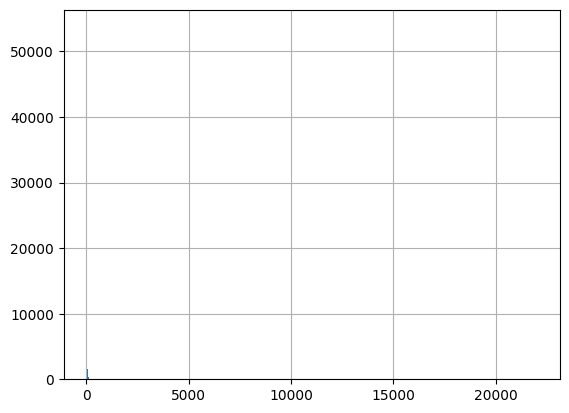

In [10]:
final_submission_df['price'].hist(bins=1000)

In [11]:
final_submission_df.max()

sample_id    299439.000000
price         22015.894531
dtype: float64

In [12]:
final_submission_df.min()

sample_id    1.000000
price        0.247791
dtype: float64

In [13]:
final_submission_df.mean()

sample_id    149387.988880
price            20.774773
dtype: float64

In [14]:
max_labels

[4.54978609085083,
 4.552565097808838,
 4.55949592590332,
 4.5548272132873535,
 4.551879405975342]

In [15]:
min_labels

[0.12221762537956238,
 0.12221762537956238,
 0.12221762537956238,
 0.12221762537956238,
 0.12221762537956238]

In [16]:
print(final_submission_df[final_submission_df['price']>=80])
df_train[df_train['price']>=80]

       sample_id       price
89        227957  117.207275
100       142744  127.394409
189       189285  169.898438
216       146944   90.308762
288        73645  116.011276
...          ...         ...
74764      16488  111.017944
74769     235486   80.930763
74817     142645   80.393776
74878     128824   96.547546
74934     148515   83.262802

[2034 rows x 2 columns]


,sample_id,catalog_content,image_link,price,qwen4b_emb,dino_emb,siglip2_emb_img,siglip2_emb_txt,price_bin
7,222007,Item Name: VineCo Original Series Chilean Sauv...,https://m.media-amazon.com/images/I/71JllaFpxM...,94.00,"[-0.029091042, 0.75464183, 5.7226086, -2.38661...","[-0.054041788, -0.008673684, -0.018911112, -0....","[-0.010113267, 0.028450415, -0.0021784701, -0....","[-0.0060313316, 0.025681382, -0.0013101429, -0...",0
15,266475,Item Name: Organic Vinegar; Apple Cider\nValue...,https://m.media-amazon.com/images/I/41SHfxsFz5...,81.44,"[-0.037762586, -1.082009, 1.0186181, -1.036805...","[-0.012997384, -0.023150215, -0.020251187, -0....","[-0.027941229, 0.00973249, 0.0008073059, -0.03...","[-0.015173069, 0.019159686, 0.01575885, -0.019...",0
18,271423,Item Name: BulkSupplements.com Trehalose Powde...,https://m.media-amazon.com/images/I/61S0ASqAuj...,109.97,"[-0.034215216, 0.6279087, 3.3330514, -3.889171...","[0.045318026, -0.013275877, 0.03034508, -0.077...","[0.013281817, -0.014919275, -0.012744329, -0.0...","[0.008280668, -0.020156829, 0.0030178153, -0.0...",0
20,267410,"Item Name: Food to Live Black-Eyed Peas, 25 Po...",https://m.media-amazon.com/images/I/418XGvkQe-...,98.99,"[-0.025577368, -0.32906243, 5.4095836, -2.8364...","[-0.025488079, 0.007972965, 0.0009681907, -0.0...","[-0.053788964, 0.0038697412, 0.0062264185, -0....","[-0.0040246183, 0.0032806844, 0.010789597, -0....",0
38,196576,Item Name: Buchu Leaf (Organic) Tea (Loose) (4...,https://m.media-amazon.com/images/I/41VxFtyBHk...,124.52,"[-0.034227047, -3.0629468, -0.5185706, -1.8252...","[-0.020624189, 0.035228595, 0.042763736, -0.03...","[0.0090611465, 0.01958376, -0.011462906, -0.03...","[0.017654087, -0.014796725, 0.012044621, -0.03...",0
...,...,...,...,...,...,...,...,...,...
74878,125690,"Item Name: Star Anise by Its Delish, (10 lbs)\...",https://m.media-amazon.com/images/I/91sHJqfv6w...,215.99,"[-0.034140132, 0.53445536, 2.7768834, -2.71587...","[-0.024285398, 0.03648553, 0.028327715, -0.011...","[-0.013216787, -0.023504294, 0.00015723918, -0...","[-0.00077391416, -0.022113431, -0.041951604, -...",1
74895,204173,Item Name: Tropical Mixed Dried Fruit Medley -...,https://m.media-amazon.com/images/I/618EbUAecR...,89.99,"[-0.029575005, 0.18956524, 3.357729, -3.384034...","[0.03258889, 0.009041448, -0.020530125, 0.0125...","[0.0014778794, 0.021817017, 0.022796351, -0.01...","[0.021168252, -0.01923669, 0.0125255585, -0.02...",0
74926,247833,Item Name: Bloomingmore | Fresh Cut Gypsophili...,https://m.media-amazon.com/images/I/71sBe+ZvMS...,105.98,"[-0.03683162, -3.3075793, 0.9898482, -2.511105...","[-0.04671262, -0.013868739, 0.02671827, -0.046...","[-0.04987664, 0.0045173718, 0.018821653, -0.00...","[-0.010494145, -0.009605146, 0.0235165, -0.038...",0
74959,52787,Item Name: Love and Quiches 1/4 Sheet Special ...,https://m.media-amazon.com/images/I/61K6mdY1br...,116.44,"[-0.030816842, -2.9136026, 3.020029, -0.486425...","[-0.017728377, -0.0015200294, -0.049064383, -0...","[-0.012172832, 0.012700691, -0.030819204, -0.0...","[-0.019512963, -0.0030066199, 0.008647835, -0....",0


95th percentile:  4.340306282043457
Min: 0.12221762537956238
Max: 7.155396461486816
95th percentile:  4.3369669914245605
Min: 0.12221762537956238
Max: 7.936302661895752
95th percentile:  4.34367561340332
Min: 0.12221762537956238
Max: 7.936302661895752
95th percentile:  4.343545913696289
Min: 0.12221762537956238
Max: 7.936302661895752
95th percentile:  4.334804058074951
Min: 0.12221762537956238
Max: 7.936302661895752


<Axes: >

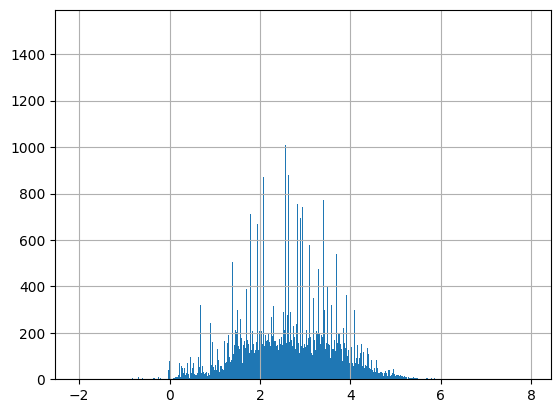

In [17]:
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train)):
        
        train_subset = Subset(full_dataset, train_idx)        
        val_subset = Subset(full_dataset, val_idx)

        train_labels = full_dataset.labels[train_idx]
        val_labels = full_dataset.labels[val_idx]
    
        # Compute min and max for each subset
        train_min = train_labels.min().item()
        train_max = train_labels.quantile(0.95).item()
        print("95th percentile: ",train_labels.quantile(0.95).item())
        print(f"Min: {train_labels.min().item()}")
        print(f"Max: {train_labels.max().item()}")


# df_train["price"].hist(bins = 1000)
df_train["log_price"] = np.log(df_train["price"])
(df_train["log_price"]).hist(bins = 1000)

<Axes: >

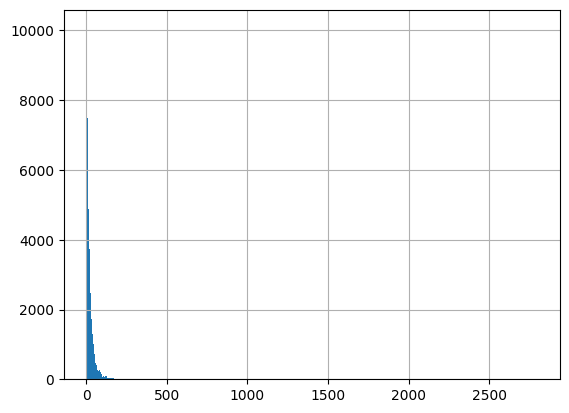

In [18]:
df_train["price"].hist(bins = 1000)
